# **Introduction**

In this section, two machine learning models will be used to classify the `obito_geral` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 0 if the person is alive and 1 if he / she died.

Four scenarios will be created using the column `obito_geral` as label. The first is the raw data for São Paulo and other states, as was generated in the previous section. The second scenario considers only patients with morphology with the last digit being 3, in addition, the `EC` column was removed.

The third and fourth scenarios use the years of diagnosis grouped, the last one also considering only morphologies with the final digit 3. The years will be grouped as follows: 2000 to 2003, 2004 to 2007, 2008 to 2011, 2012 to 2015 and 2016 until the end. So we will have 5 datasets for SP and another 5 for other states.

Reading the data from SP and other states.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(506037, 77)
(32891, 77)


In [ ]:
df_SP.head(3)

SEXO  IDADE  ESCOLARI UFRESID     IBGE  CATEATEND  CLINICA  DIAGPREV  \
0     1     26         2      SP  3529401          9        4         1   
1     1     50         9      SP  3531209          2       26         2   
2     1     23         9      SP  3542602          9       26         1   

   BASEDIAG  TOPO  ...               REC03  HABILIT2 ULTICONS ULTIDIAG  \
0         3  C491  ...  **Sem informação**         2     5852     5738   
1         3  C402  ...  **Sem informação**         2     1293     1331   
2         3  C402  ...  **Sem informação**         1     2053     1942   

  ULTITRAT obito_geral obito_cancer vivo_ano1 vivo_ano3 vivo_ano5  
0     5738           0            0         1         1         1  
1     1248           0            0         1         1         0  
2     1942           1            1         1         1         1  

[3 rows x 77 columns]

In [ ]:
df_fora.head(3)

SEXO  IDADE  ESCOLARI UFRESID     IBGE  CATEATEND  CLINICA  DIAGPREV  \
0     1     26         4      AC  1200401          2       24         2   
1     1     49         3      BA  2930709          2       26         1   
2     1     59         9      MG  3102605          9       32         1   

   BASEDIAG  TOPO  ...               REC03  HABILIT2 ULTICONS ULTIDIAG  \
0         3  C402  ...  **Sem informação**         2      669      710   
1         3  C402  ...  **Sem informação**         2     3163     3055   
2         3  C619  ...  **Sem informação**         2     1967     1967   

  ULTITRAT obito_geral obito_cancer vivo_ano1 vivo_ano3 vivo_ano5  
0      594           0            0         1         0         0  
1     2893           0            0         1         1         1  
2     1770           0            0         1         1         1  

[3 rows x 77 columns]

In [ ]:
# SP
df_SP.isna().sum().sort_values(ascending=False).head(6)

SEXO         0
IMUNOAPOS    0
FAIXAETAR    0
ANODIAG      0
DIAGTRAT     0
TRATCONS     0
dtype: int64

In [ ]:
# Other states
df_fora.isna().sum().sort_values(ascending=False).head(6)

SEXO         0
IMUNOAPOS    0
FAIXAETAR    0
ANODIAG      0
DIAGTRAT     0
TRATCONS     0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the `ULTINFO` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['obito_geral']).sort_values(ascending = False).head(20)

obito_geral     1.000000
ULTINFO         0.866060
obito_cancer    0.778975
vivo_ano3       0.365068
ULTIDIAG        0.340122
ULTICONS        0.336685
ULTITRAT        0.332492
vivo_ano5       0.294475
vivo_ano1       0.288888
ANODIAG         0.264297
CIRURGIA        0.260995
QUIMIO          0.226548
CATEATEND       0.220804
RECNENHUM       0.208701
MORFO           0.195059
IDADE           0.190838
RECREGIO        0.153588
GLEASON         0.152939
PSA             0.152179
SEXO            0.150677
Name: obito_geral, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['obito_geral']).sort_values(ascending = False).head(20)

obito_geral     1.000000
ULTINFO         0.866780
obito_cancer    0.847824
vivo_ano3       0.385518
ULTIDIAG        0.350399
ULTICONS        0.343164
ULTITRAT        0.338123
CIRURGIA        0.301963
vivo_ano5       0.301465
vivo_ano1       0.281608
QUIMIO          0.252260
ANODIAG         0.228325
CATEATEND       0.222303
MORFO           0.182062
GLEASON         0.151939
PSA             0.149539
ESCOLARI        0.142043
HORMONIO        0.141135
DIAGTRAT        0.135024
RECNENHUM       0.129595
Name: obito_geral, dtype: float64

Here we have the number of examples for each category of the label, it is possible to notice that there is an imbalance. 

In [ ]:
df_SP.obito_geral.value_counts()

0    276947
1    229090
Name: obito_geral, dtype: int64

In [ ]:
df_fora.obito_geral.value_counts()

0    20359
1    12532
Name: obito_geral, dtype: int64

# **First approach**

Approach with "raw data".

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'obito_cancer']

lb = 'obito_geral'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (379527, 66), X_test = (126510, 66)
y_train = (379527,), y_test = (126510,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (24668, 66), X_test = (8223, 66)
y_train = (24668,), y_test = (8223,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because teh model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.272}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.272}, criterion='entropy',
                       max_depth=10, random_state=10)

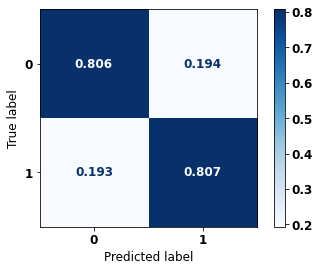


              precision    recall  f1-score   support

           0      0.834     0.806     0.820     69237
           1      0.774     0.807     0.790     57273

    accuracy                          0.806    126510
   macro avg      0.804     0.806     0.805    126510
weighted avg      0.807     0.806     0.806    126510



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


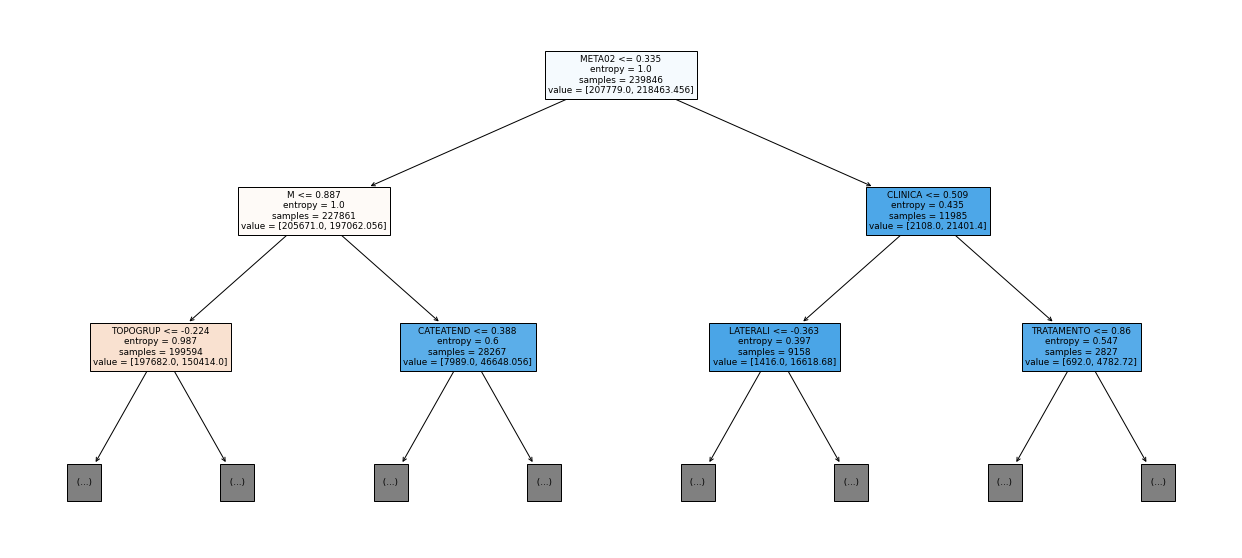

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

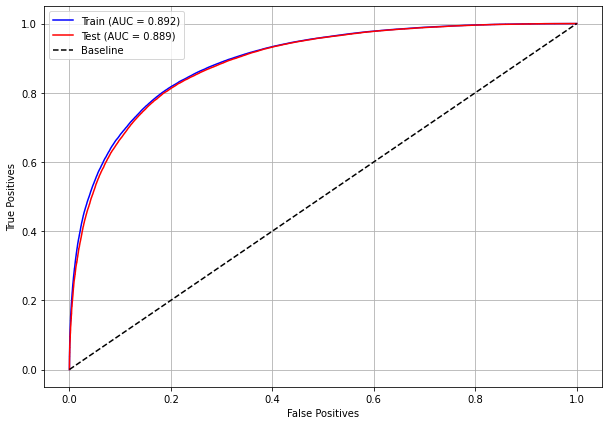

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

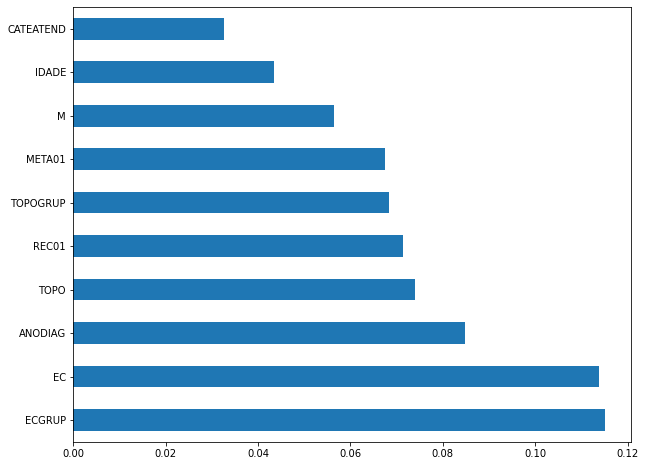

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `EC`, `ANODIAG` and `TOPO`.

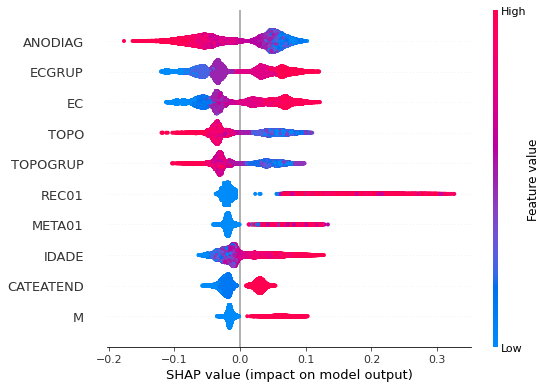

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1, 1:1.73},
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 1.73}, criterion='entropy',
                       max_depth=8, random_state=10)

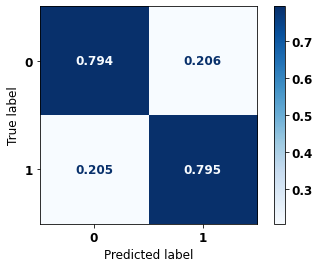


              precision    recall  f1-score   support

           0      0.863     0.794     0.827      5090
           1      0.704     0.795     0.747      3133

    accuracy                          0.795      8223
   macro avg      0.783     0.795     0.787      8223
weighted avg      0.802     0.795     0.797      8223



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 79% of accuracy.


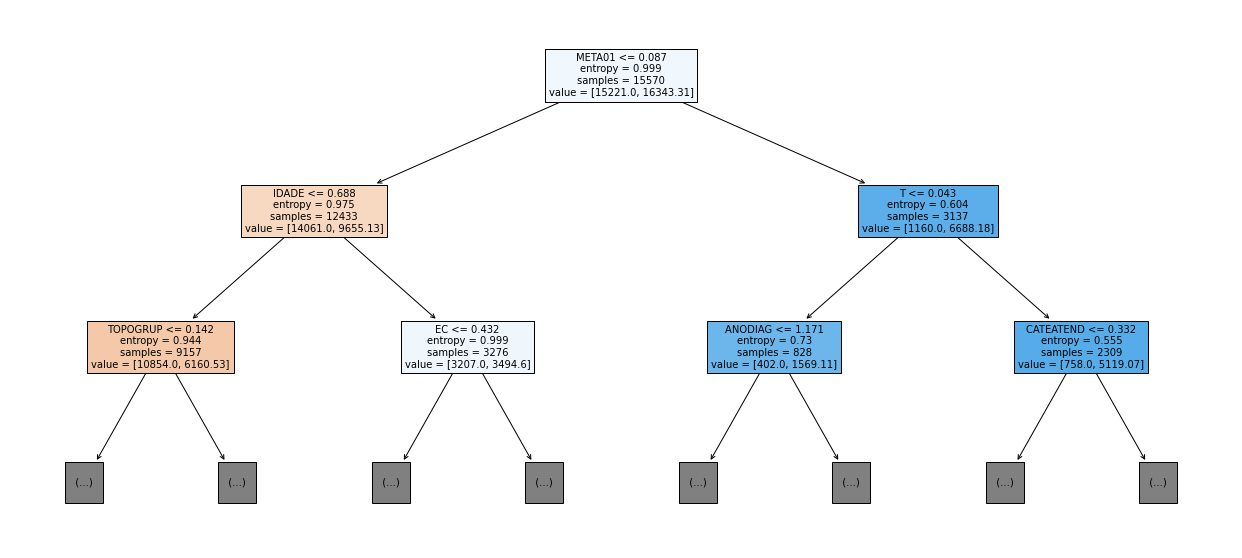

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

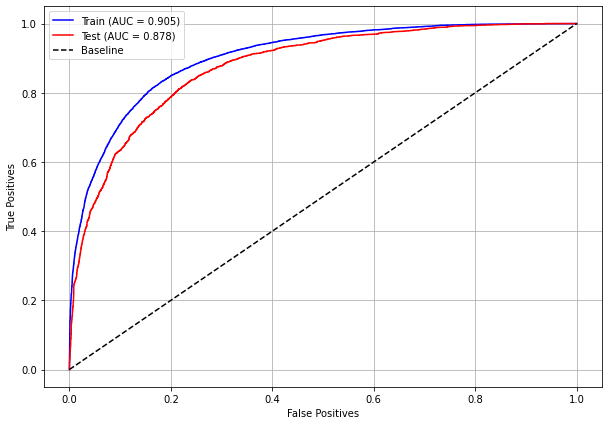

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

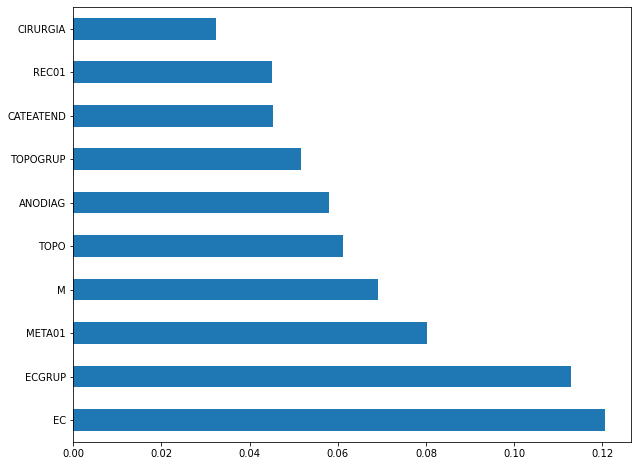

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `EC`, `ECGRUP`, `META01` and `M`.

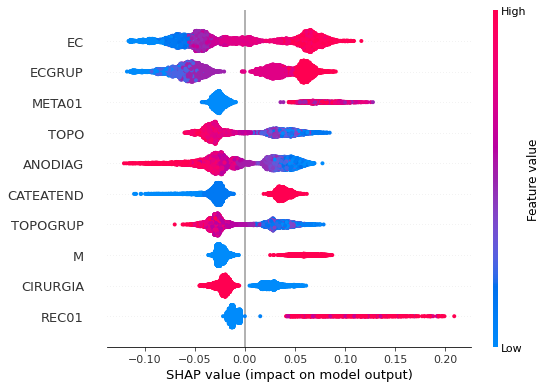

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperRF = {'n_estimators': [100, 150, 200, 250],
           'max_depth': [5, 8, 10, 12, 15],
           'min_samples_split': [2, 5, 10, 15],
           'min_samples_leaf': [1, 2, 5, 10]} 

rf = RandomForestClassifier(random_state=seed, criterion='entropy')

randRS = RandomizedSearchCV(rf, hyperRF, n_iter=20, cv=5, n_jobs=-1, 
                            random_state=seed)

In [ ]:
# SP
bestSP = randRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 15}

In [ ]:
# SP
rf_sp_opt = bestSP.best_estimator_
rf_sp_opt.set_params(class_weight={0:1, 1:1.25})

rf_sp_opt.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.25}, criterion='entropy',
                       max_depth=15, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=10)

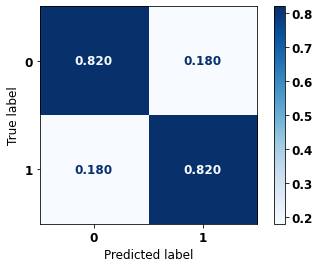


              precision    recall  f1-score   support

           0      0.847     0.820     0.833     69237
           1      0.790     0.820     0.805     57273

    accuracy                          0.820    126510
   macro avg      0.819     0.820     0.819    126510
weighted avg      0.821     0.820     0.820    126510



In [ ]:
display_confusion_matrix(rf_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = randRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 15}

In [ ]:
# Other states
rf_fora_opt = bestOS.best_estimator_
rf_fora_opt.set_params(class_weight={0:1, 1:2.1})

rf_fora_opt.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 2.1}, criterion='entropy',
                       max_depth=15, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=10)

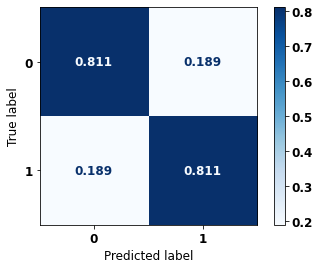


              precision    recall  f1-score   support

           0      0.874     0.811     0.842      5090
           1      0.725     0.811     0.766      3133

    accuracy                          0.811      8223
   macro avg      0.800     0.811     0.804      8223
weighted avg      0.818     0.811     0.813      8223



In [ ]:
display_confusion_matrix(rf_fora_opt, X_test_OS, y_test_OS)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                           scale_pos_weight=1.25,
                           random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.25)

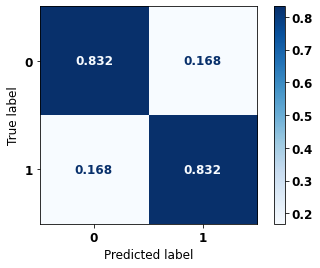


              precision    recall  f1-score   support

           0      0.857     0.832     0.844     69237
           1      0.804     0.832     0.818     57273

    accuracy                          0.832    126510
   macro avg      0.830     0.832     0.831    126510
weighted avg      0.833     0.832     0.832    126510



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 83% of accuracy.


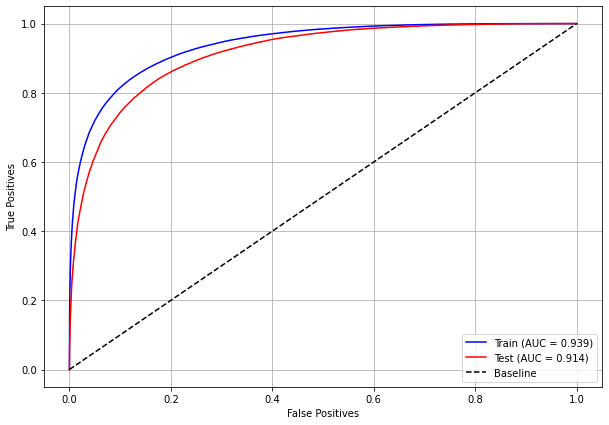

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

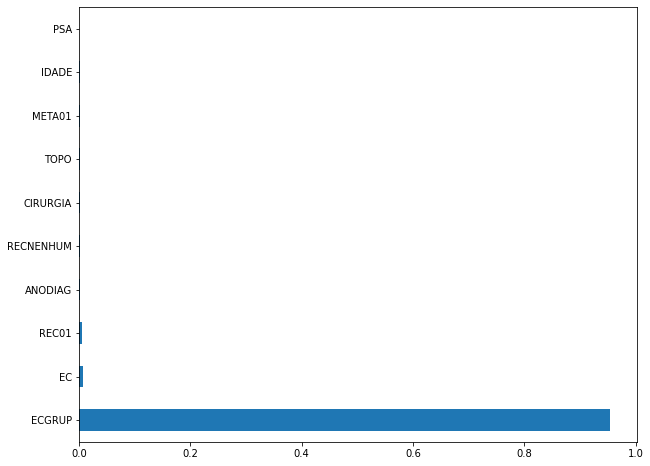

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `EC`, `REC01` and `ANODIAG`.

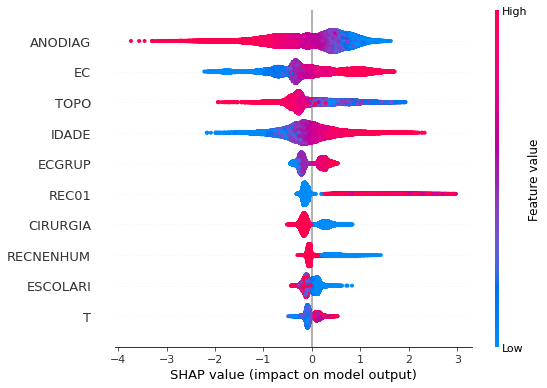

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. 

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=6, 
                             scale_pos_weight=1.68,
                             random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.68)

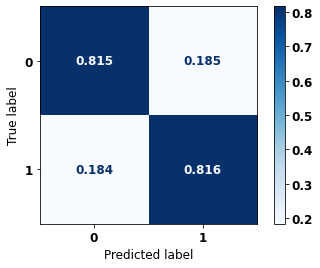


              precision    recall  f1-score   support

           0      0.878     0.815     0.845      5090
           1      0.731     0.816     0.771      3133

    accuracy                          0.815      8223
   macro avg      0.804     0.816     0.808      8223
weighted avg      0.822     0.815     0.817      8223



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 81% of accuracy.


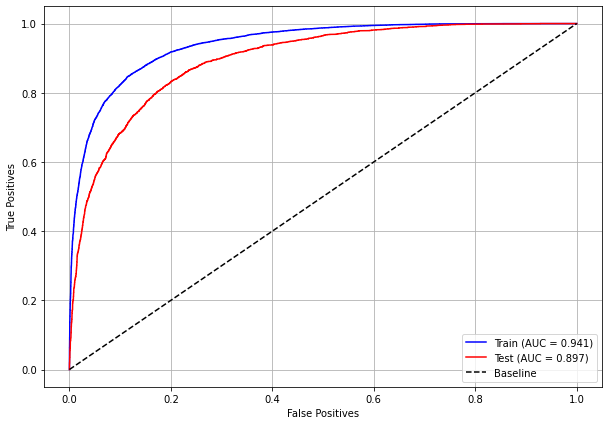

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

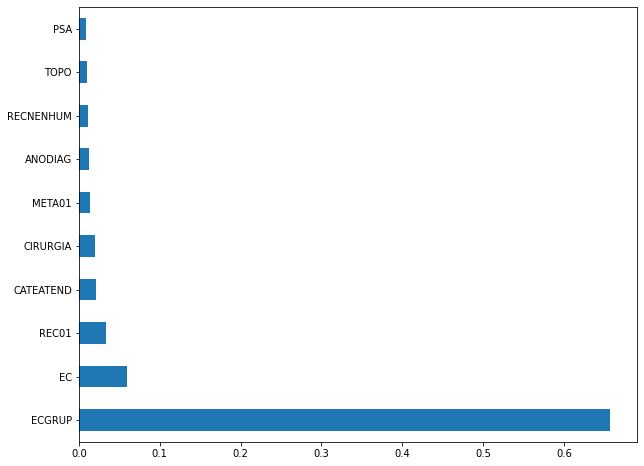

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `EC`, `REC01` and `CATEATEND`.

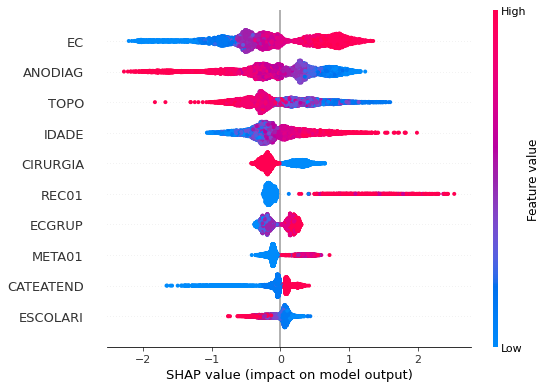

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperXGB = {'learning_rate': [0.05, 0.10, 0.15, 0.20],
            'max_depth': [5, 8, 10, 12, 15],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.0, 0.1, 0.2 , 0.3],
            'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
            'n_estimators': [100, 150, 200, 250]}

xgboost = XGBClassifier(random_state=seed)
xgbRS = RandomizedSearchCV(xgboost, hyperXGB, n_iter=20, cv=5, n_jobs=-1, 
                           random_state=seed)

In [ ]:
# SP
bestSP = xgbRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

{'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [ ]:
# SP
xgb_sp_opt = bestSP.best_estimator_
xgb_sp_opt.set_params(scale_pos_weight=1.26)

xgb_sp_opt.fit(X_train_SP, y_train_SP)

XGBClassifier(colsample_bytree=0.4, gamma=0.2, max_depth=10, min_child_weight=5,
              n_estimators=200, random_state=10, scale_pos_weight=1.26)

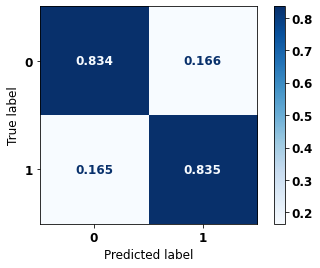


              precision    recall  f1-score   support

           0      0.860     0.834     0.847     69237
           1      0.806     0.835     0.820     57273

    accuracy                          0.835    126510
   macro avg      0.833     0.835     0.833    126510
weighted avg      0.835     0.835     0.835    126510



In [ ]:
display_confusion_matrix(xgb_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = xgbRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

{'n_estimators': 150,
 'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [ ]:
# Other states
xgb_fora_opt = bestOS.best_estimator_
xgb_fora_opt.set_params(scale_pos_weight=1.76)

xgb_fora_opt.fit(X_train_OS, y_train_OS)

XGBClassifier(colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8,
              min_child_weight=7, n_estimators=150, random_state=10,
              scale_pos_weight=1.76)

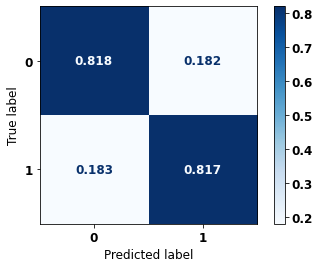


              precision    recall  f1-score   support

           0      0.879     0.818     0.848      5090
           1      0.735     0.817     0.774      3133

    accuracy                          0.818      8223
   macro avg      0.807     0.818     0.811      8223
weighted avg      0.824     0.818     0.820      8223



In [ ]:
display_confusion_matrix(xgb_fora_opt, X_test_OS, y_test_OS)

# **Second approach**

Approach using only morphologies with final digit equal to 3 and without `EC` column as a feature.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_cancer']

lb = 'obito_geral'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP, list_drop, lb, 
                                                                           morpho3=True, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (351486, 65), X_test = (117163, 65)
y_train = (351486,), y_test = (117163,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora, list_drop, lb, 
                                                                           morpho3=True, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (23079, 65), X_test = (7693, 65)
y_train = (23079,), y_test = (7693,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0:1, 1:1.161},
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.161}, criterion='entropy',
                       max_depth=10, random_state=10)

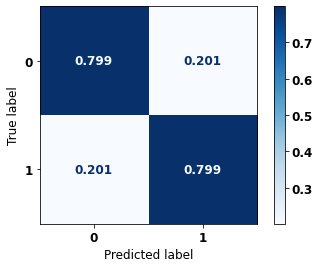


              precision    recall  f1-score   support

           0      0.811     0.799     0.805     60836
           1      0.786     0.799     0.793     56327

    accuracy                          0.799    117163
   macro avg      0.799     0.799     0.799    117163
weighted avg      0.799     0.799     0.799    117163



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, also shows a good performance of the model, with 80% of accuracy.


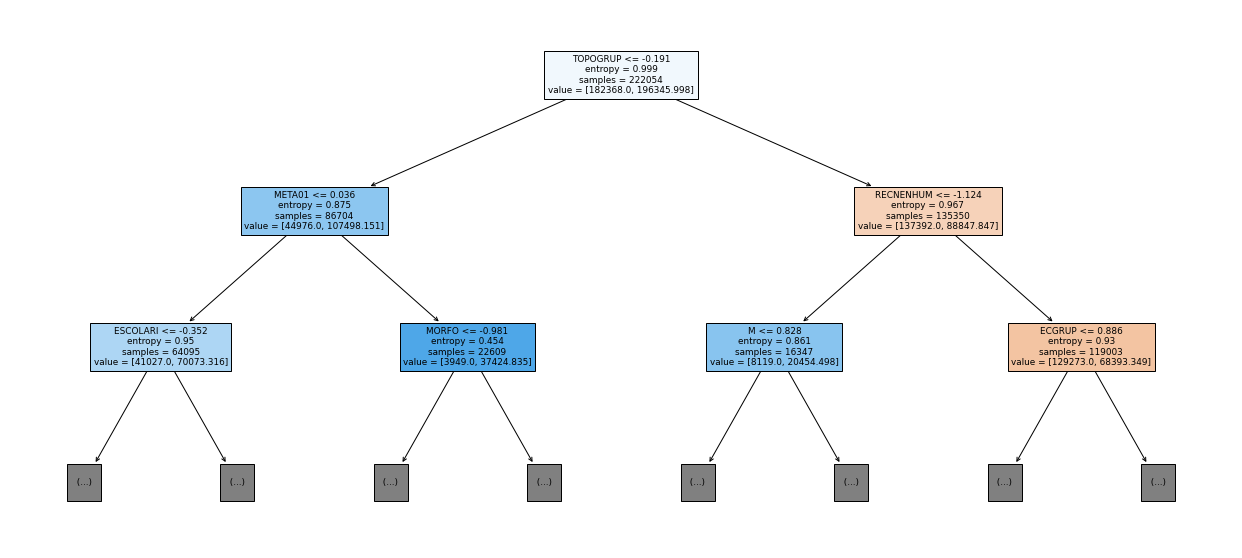

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

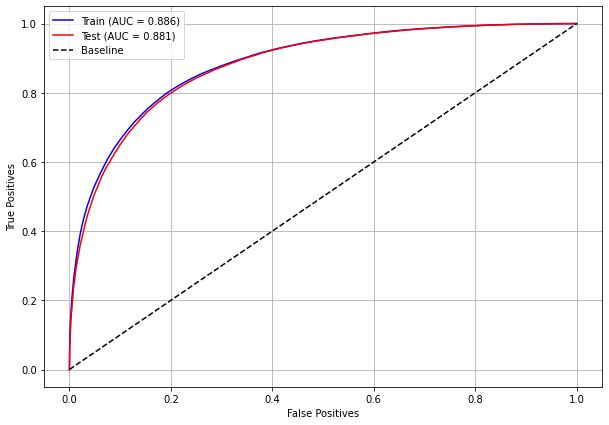

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

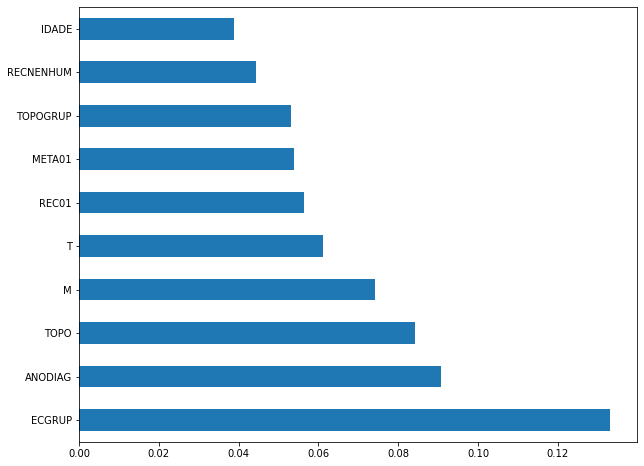

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `TOPO` and `M`.

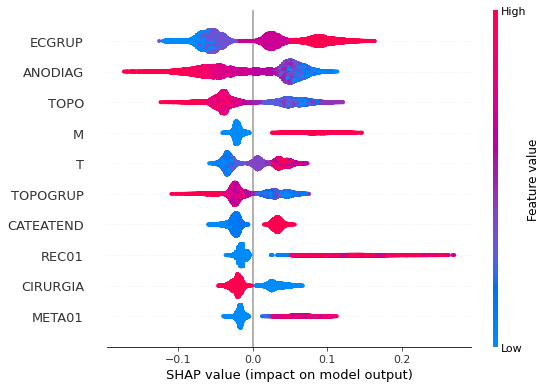

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0:1, 1:1.54},
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 1.54}, criterion='entropy',
                       max_depth=8, random_state=10)

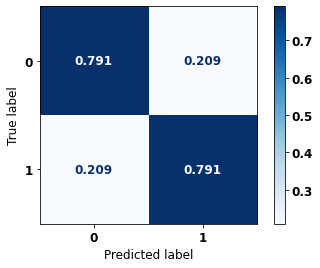


              precision    recall  f1-score   support

           0      0.848     0.791     0.819      4588
           1      0.719     0.791     0.753      3105

    accuracy                          0.791      7693
   macro avg      0.784     0.791     0.786      7693
weighted avg      0.796     0.791     0.792      7693



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm with other states data shows a good performance of the model, because the model achieves a 79% of accuracy.


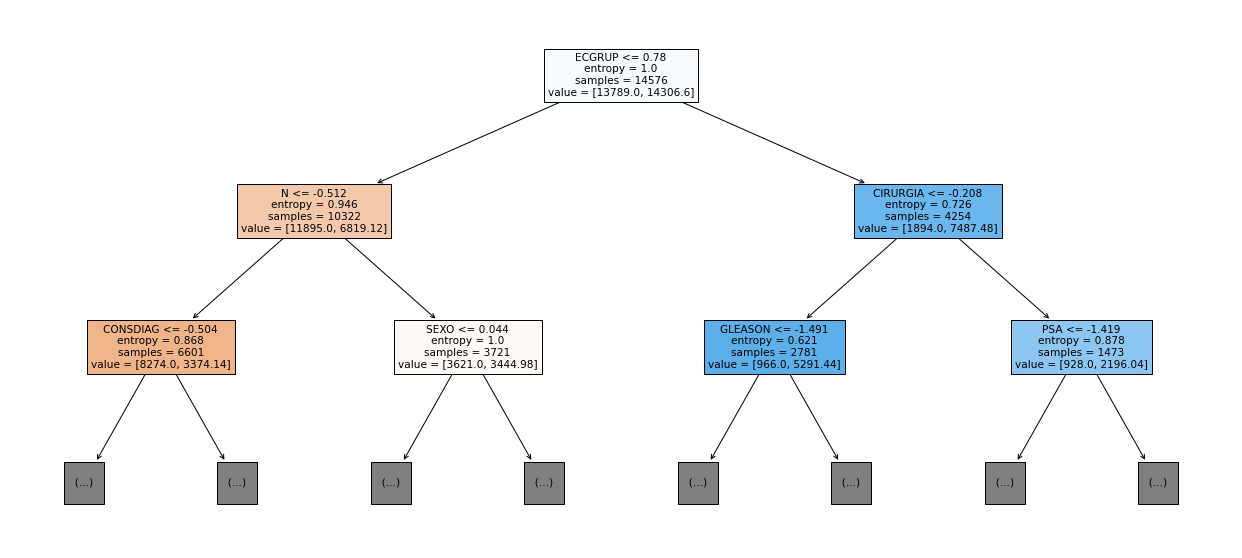

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

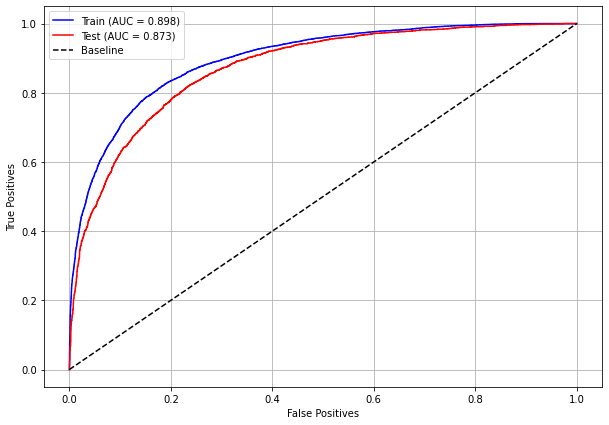

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

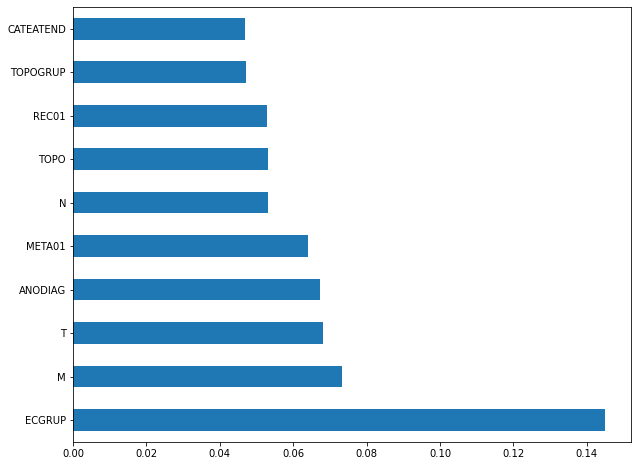

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `ANODIAG`.

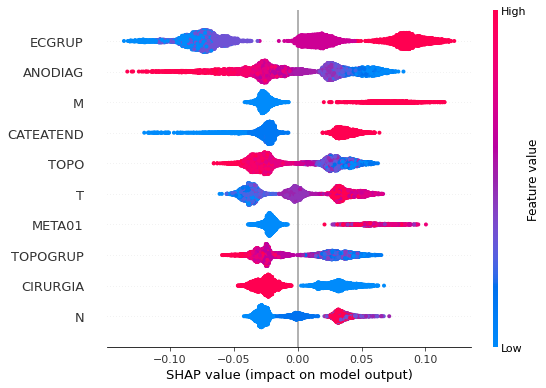

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                           scale_pos_weight=1.13,
                           random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.13)

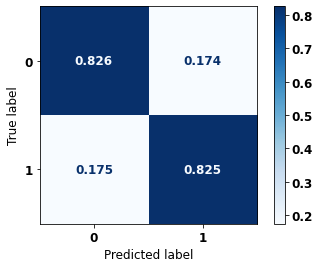


              precision    recall  f1-score   support

           0      0.836     0.826     0.831     60836
           1      0.815     0.825     0.820     56327

    accuracy                          0.826    117163
   macro avg      0.825     0.826     0.825    117163
weighted avg      0.826     0.826     0.826    117163



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, also shows a good performance of the model, with 83% of accuracy.


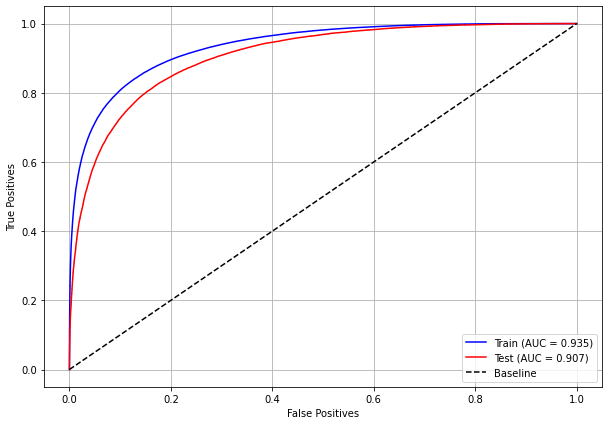

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

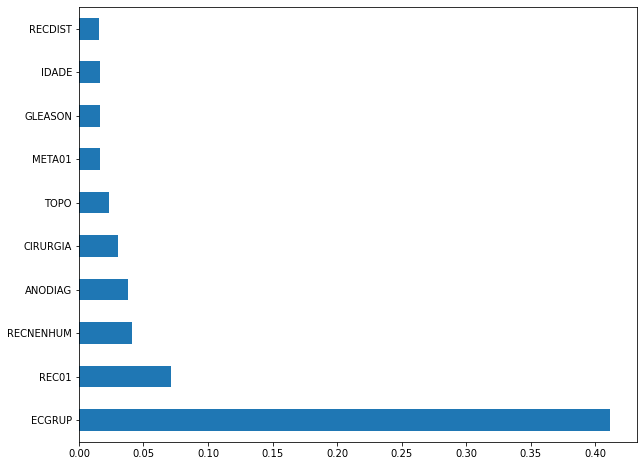

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `REC01`, `RECNENHUM` and `ANODIAG`.

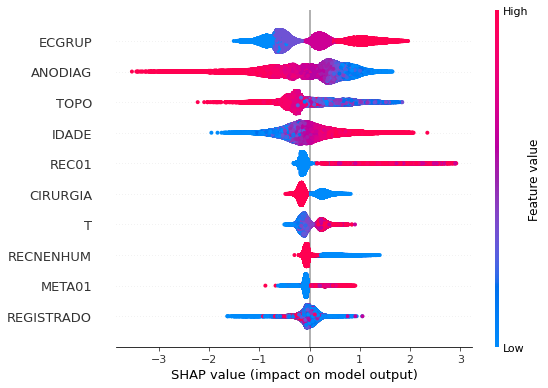

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=6, 
                             scale_pos_weight=1.471,
                             random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.471)

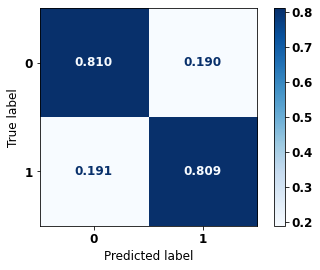


              precision    recall  f1-score   support

           0      0.862     0.810     0.836      4588
           1      0.743     0.809     0.774      3105

    accuracy                          0.810      7693
   macro avg      0.802     0.810     0.805      7693
weighted avg      0.814     0.810     0.811      7693



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm with SP data shows a good performance of the model, because the model achieves a 81% of accuracy.


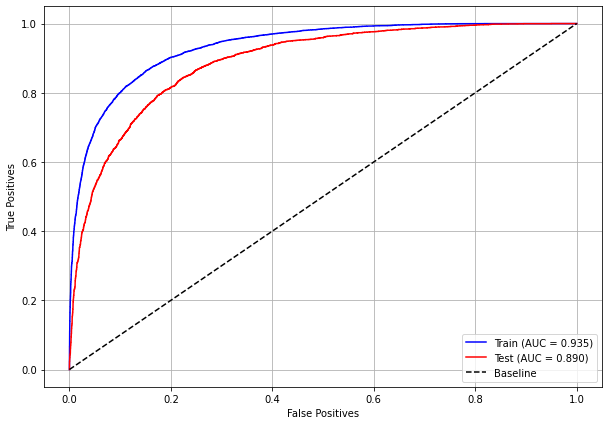

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

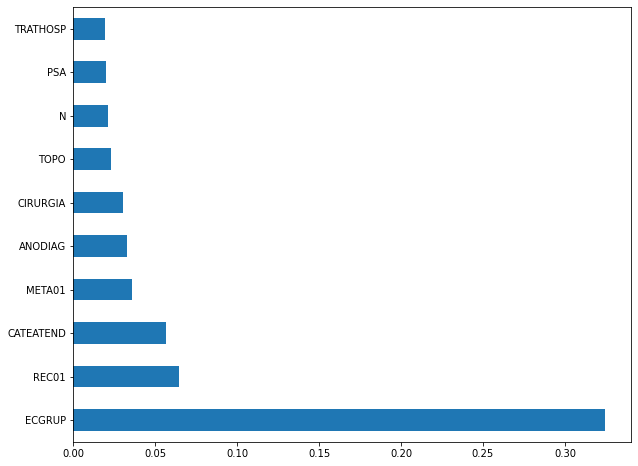

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `REC01`, `CATEATEND` and `META01`.

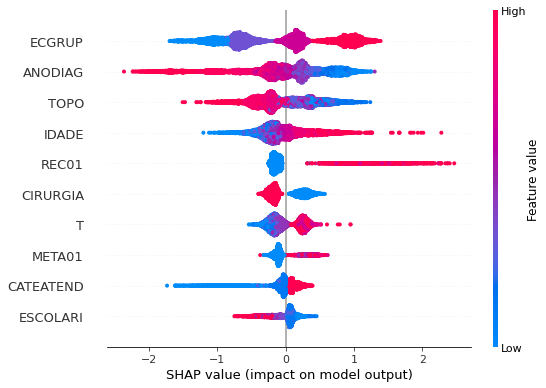

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

# **Third approach**

Approach with grouped years and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_cancer']

lb = 'obito_geral'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (49873, 65), X_test = (16625, 65)
y_train = (49873,), y_test = (16625,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (62658, 65), X_test = (20887, 65)
y_train = (62658,), y_test = (20887,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (83228, 65), X_test = (27743, 65)
y_train = (83228,), y_test = (27743,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (103890, 65), X_test = (34630, 65)
y_train = (103890,), y_test = (34630,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2021, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (79877, 65), X_test = (26626, 65)
y_train = (79877,), y_test = (26626,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2802, 65), X_test = (935, 65)
y_train = (2802,), y_test = (935,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3942, 65), X_test = (1315, 65)
y_train = (3942,), y_test = (1315,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4842, 65), X_test = (1614, 65)
y_train = (4842,), y_test = (1614,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6456, 65), X_test = (2153, 65)
y_train = (6456,), y_test = (2153,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2020, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6624, 65), X_test = (2208, 65)
y_train = (6624,), y_test = (2208,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.905, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1.905, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

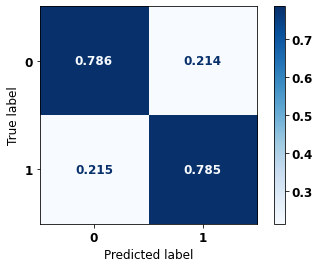


              precision    recall  f1-score   support

           0      0.665     0.786     0.720      5851
           1      0.871     0.785     0.826     10774

    accuracy                          0.785     16625
   macro avg      0.768     0.785     0.773     16625
weighted avg      0.798     0.785     0.789     16625



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 78% of accuracy.


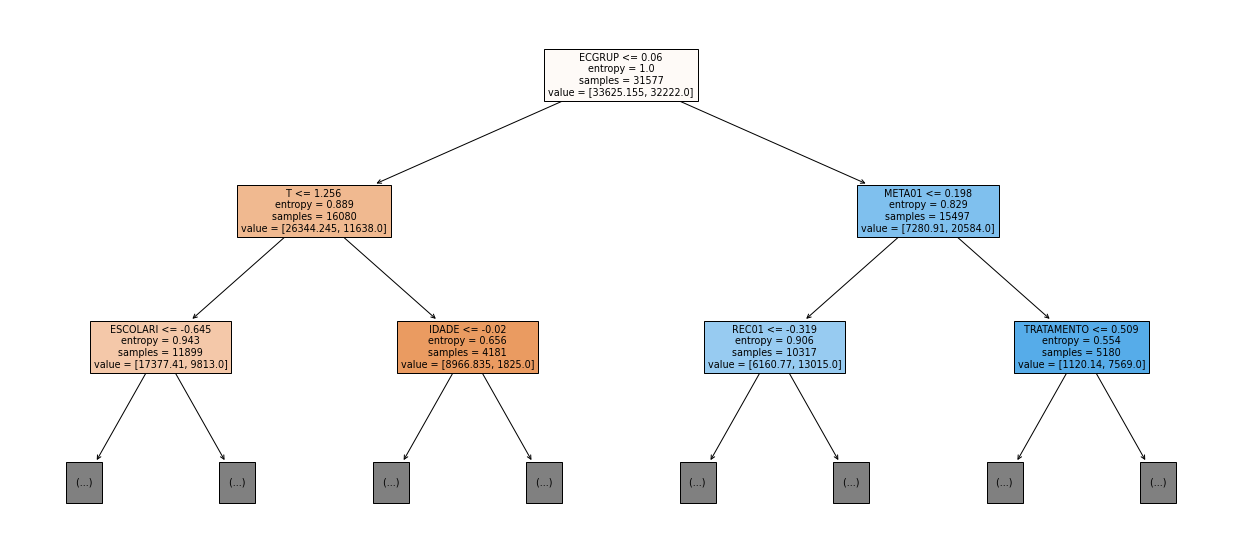

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

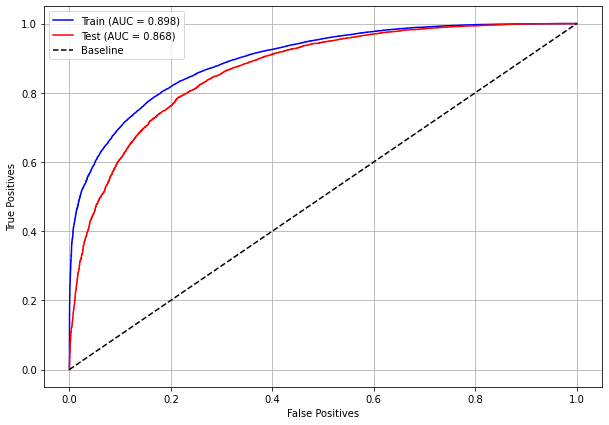

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

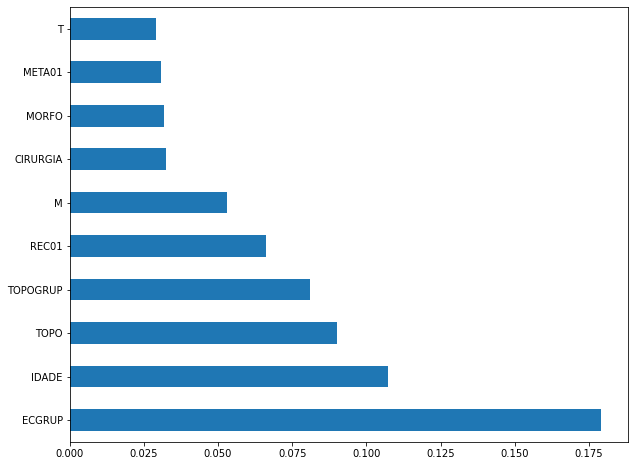

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `IDADE`, `TOPO`, and `TOPOGRUP`. 

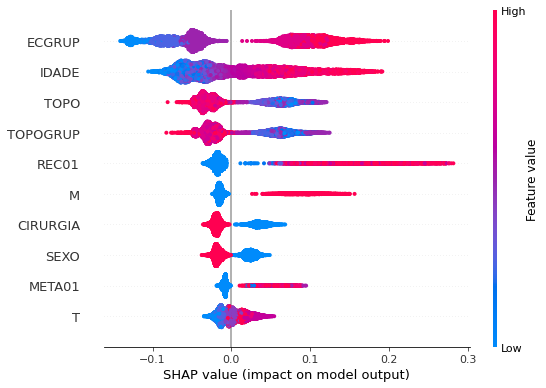

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.25007, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.25007, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

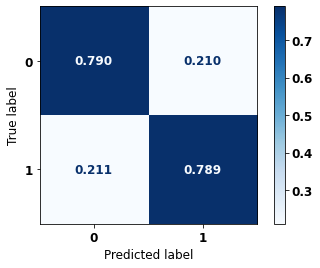


              precision    recall  f1-score   support

           0      0.734     0.790     0.761      8851
           1      0.837     0.789     0.812     12036

    accuracy                          0.790     20887
   macro avg      0.785     0.790     0.787     20887
weighted avg      0.793     0.790     0.791     20887



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.


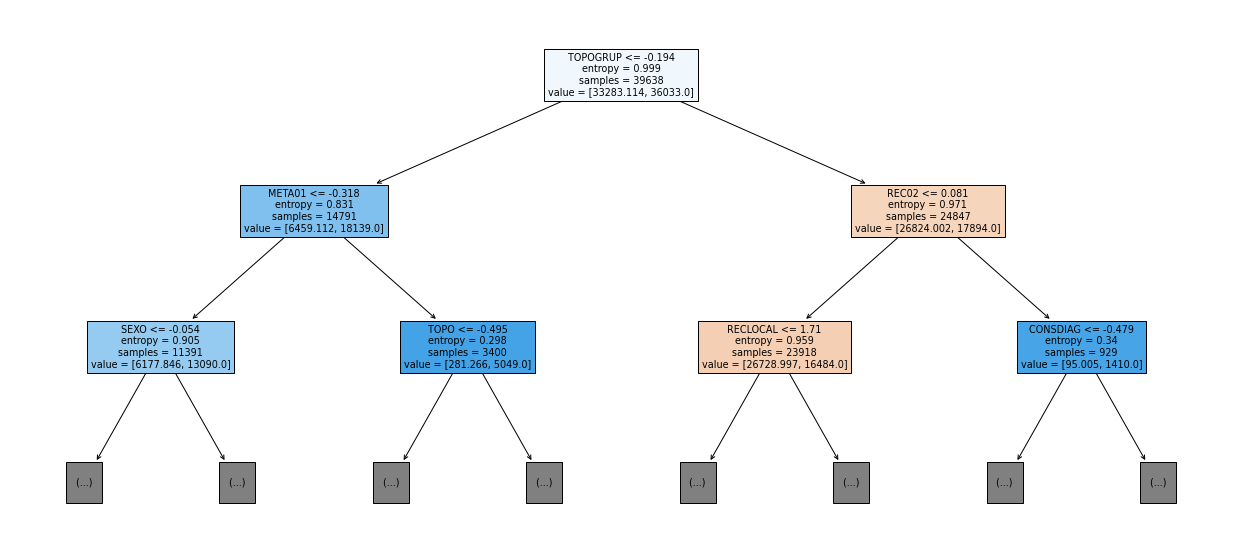

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

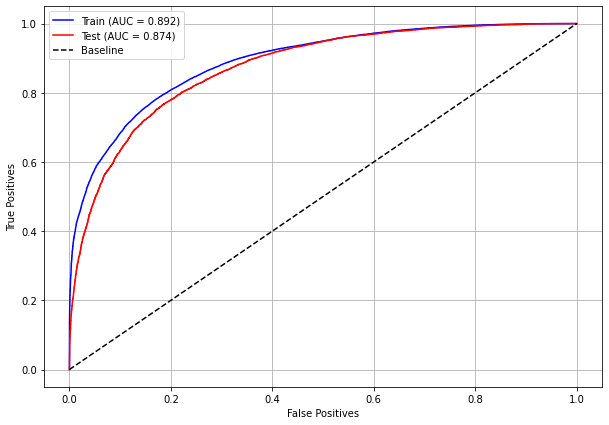

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

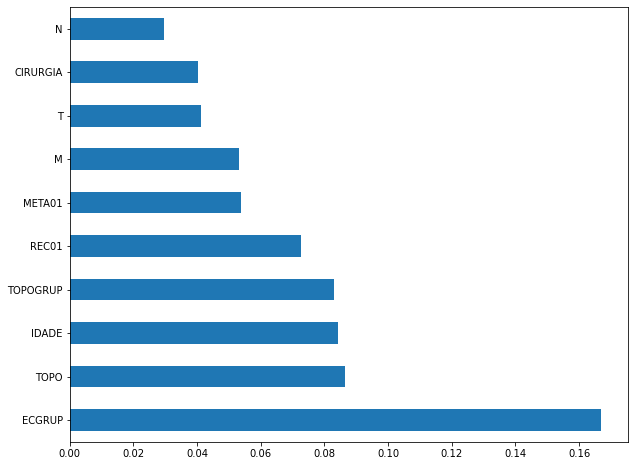

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPO`, `IDADE`, and `TOPOGRUP`. 

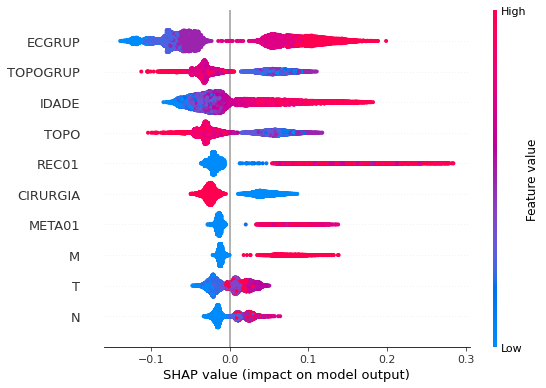

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.184},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.184}, criterion='entropy',
                       max_depth=10, random_state=10)

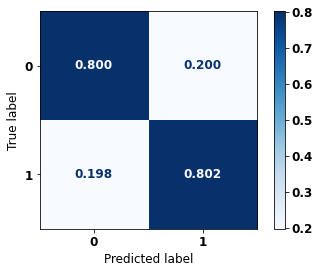


              precision    recall  f1-score   support

           0      0.797     0.800     0.798     13681
           1      0.805     0.802     0.803     14062

    accuracy                          0.801     27743
   macro avg      0.801     0.801     0.801     27743
weighted avg      0.801     0.801     0.801     27743



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 80% of accuracy.

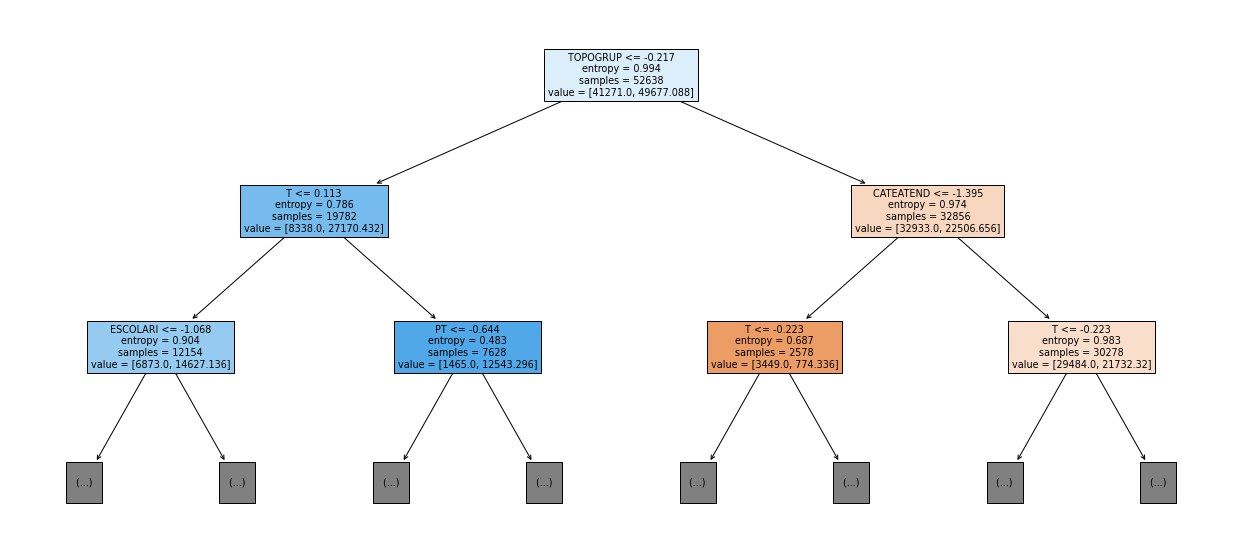

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

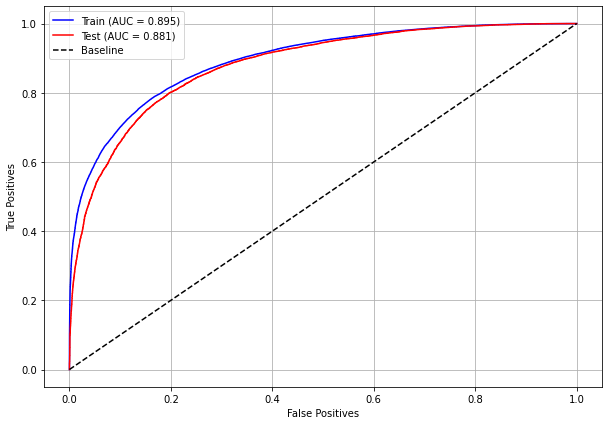

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

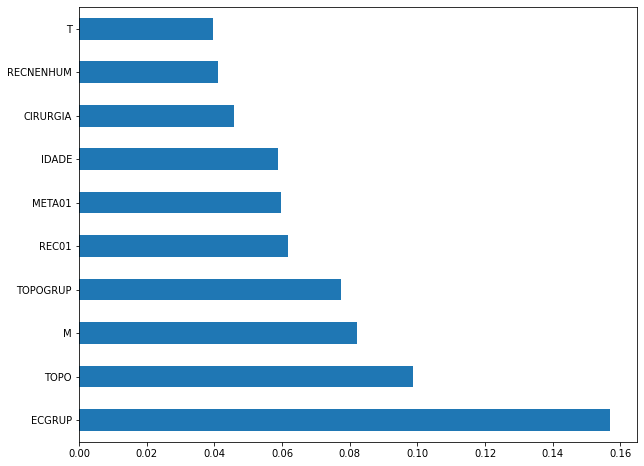

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `TOPO`, `M` and `TOPOGRUP`.

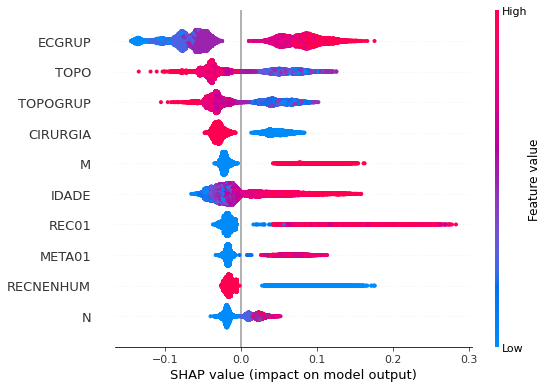

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.97},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 1.97}, criterion='entropy',
                       max_depth=10, random_state=10)

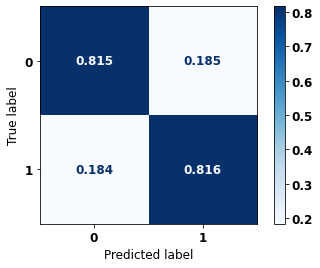


              precision    recall  f1-score   support

           0      0.877     0.815     0.845     21356
           1      0.733     0.816     0.772     13274

    accuracy                          0.815     34630
   macro avg      0.805     0.815     0.808     34630
weighted avg      0.822     0.815     0.817     34630



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 81% of accuracy.

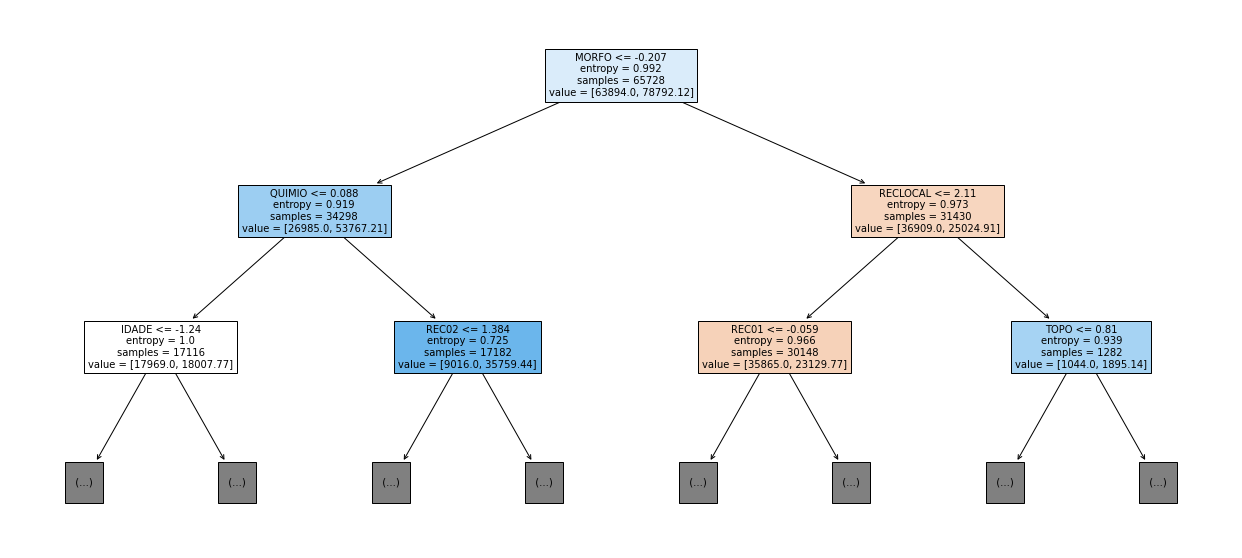

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

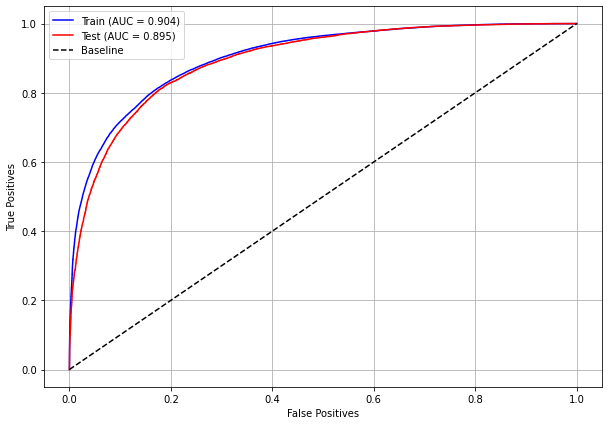

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

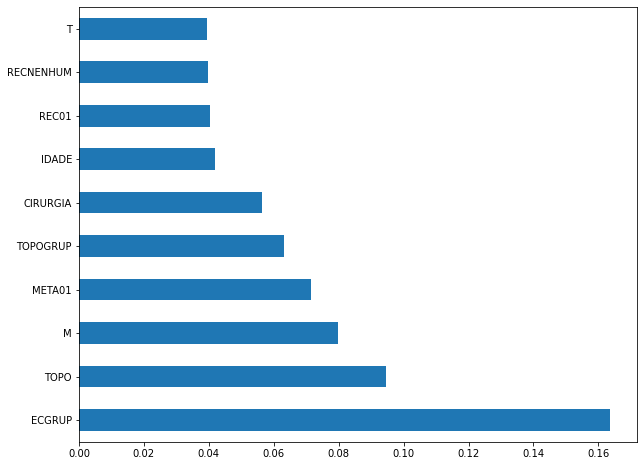

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `TOPO`, `M` and `META01`.

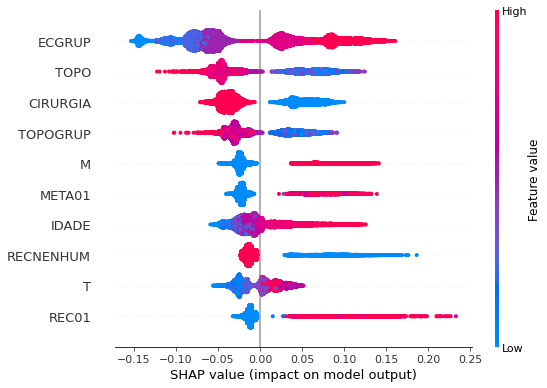

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:3},
                                     criterion='entropy', 
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 3}, criterion='entropy',
                       max_depth=10, random_state=10)

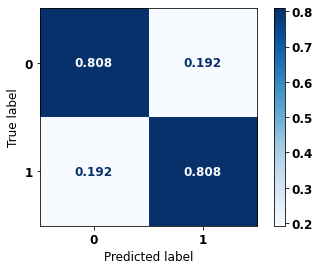


              precision    recall  f1-score   support

           0      0.920     0.808     0.861     19497
           1      0.606     0.808     0.693      7129

    accuracy                          0.808     26626
   macro avg      0.763     0.808     0.777     26626
weighted avg      0.836     0.808     0.816     26626



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.

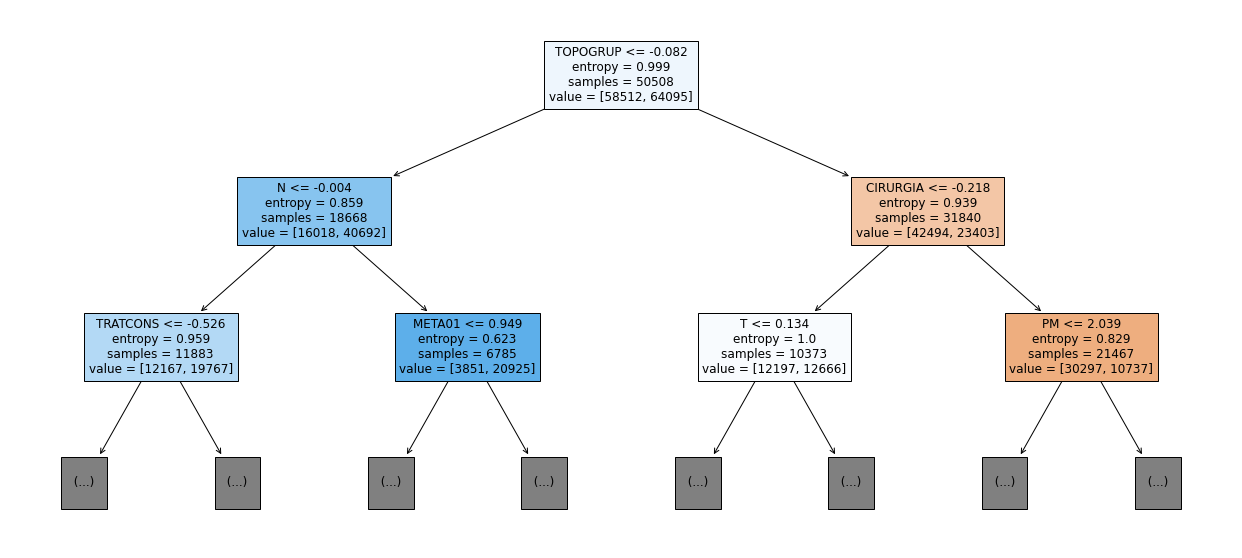

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

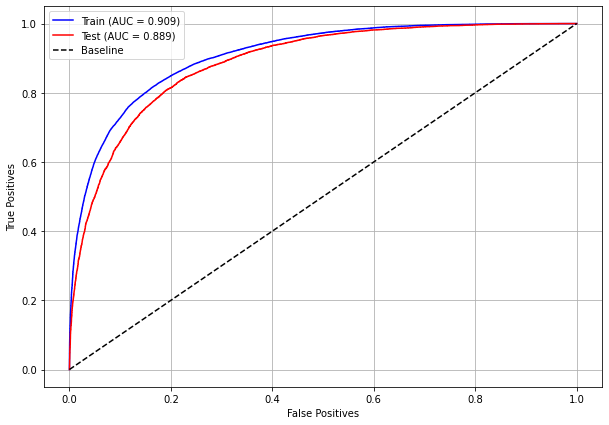

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

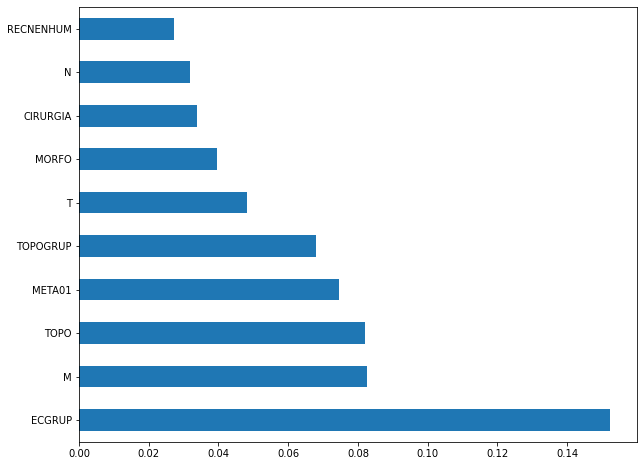

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO`, and `META01`.



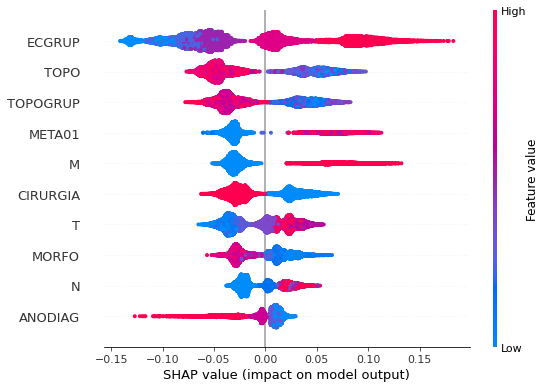

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.2, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.2, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

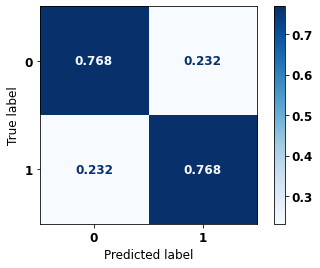


              precision    recall  f1-score   support

           0      0.709     0.768     0.737       396
           1      0.818     0.768     0.792       539

    accuracy                          0.768       935
   macro avg      0.763     0.768     0.765       935
weighted avg      0.772     0.768     0.769       935



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 77% of accuracy.

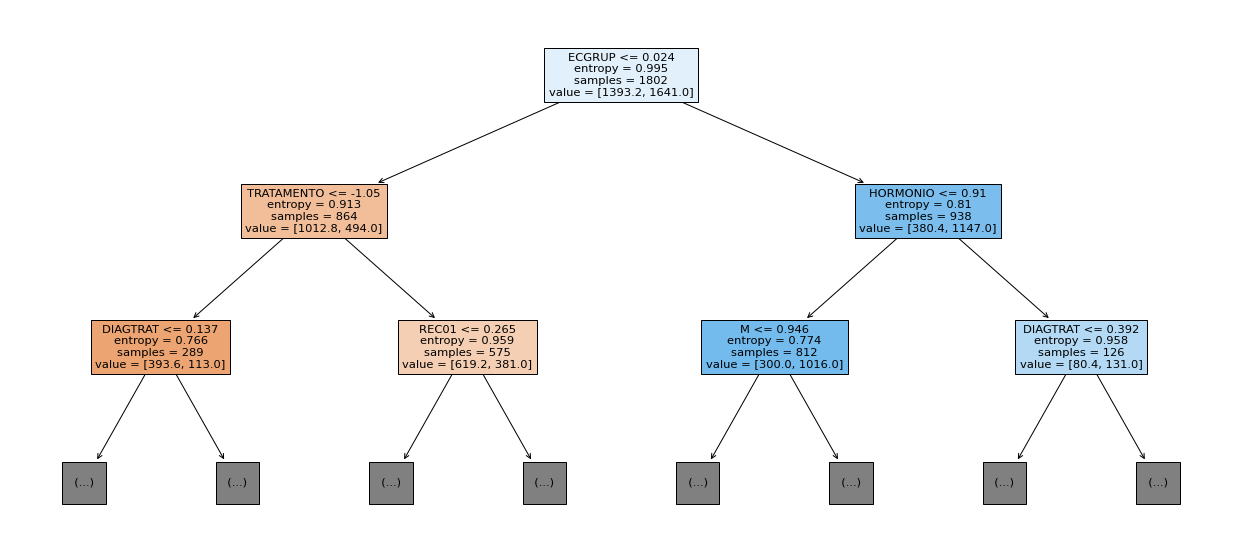

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

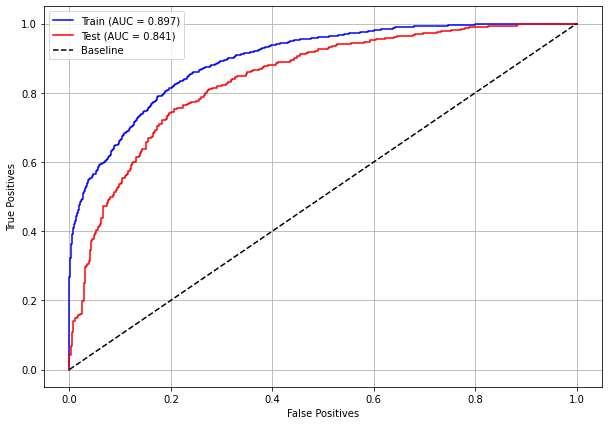

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

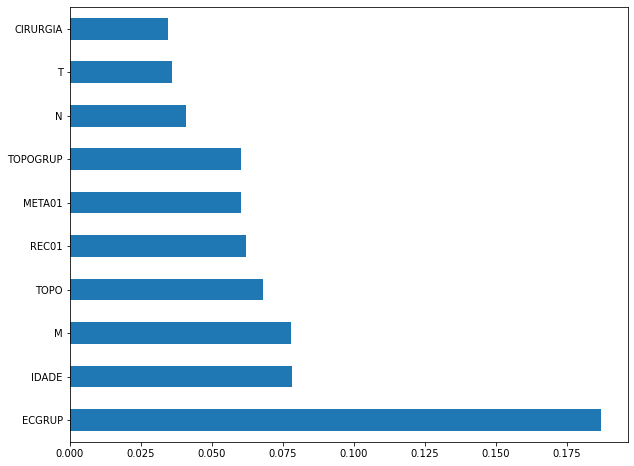

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `IDADE`, `M` and `TOPO`.

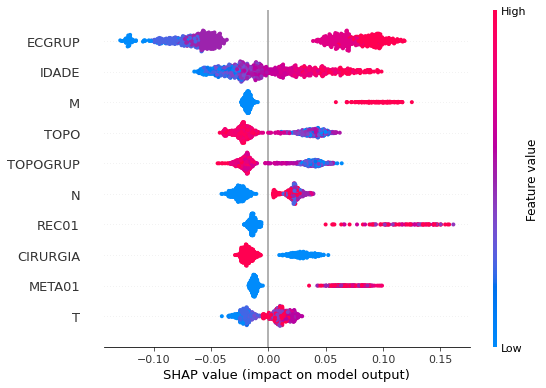

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.23},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.23}, criterion='entropy',
                       max_depth=6, random_state=10)

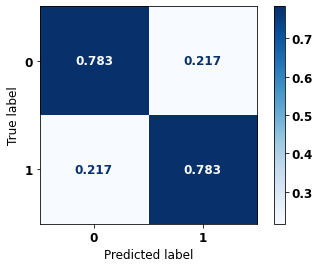


              precision    recall  f1-score   support

           0      0.794     0.783     0.788       678
           1      0.772     0.783     0.778       637

    accuracy                          0.783      1315
   macro avg      0.783     0.783     0.783      1315
weighted avg      0.783     0.783     0.783      1315



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 78% of accuracy.


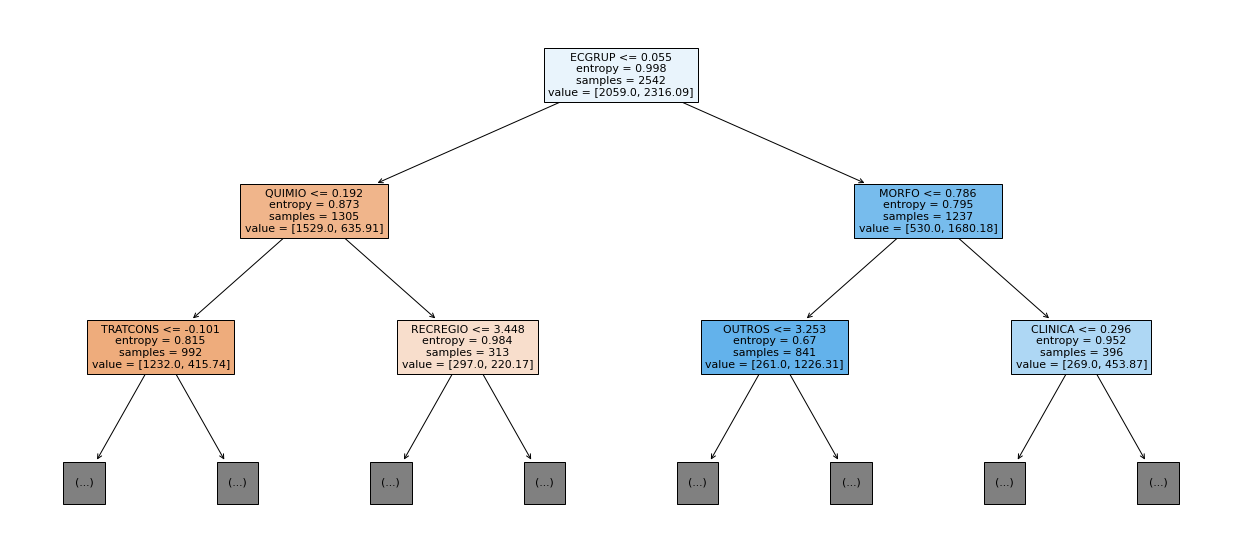

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

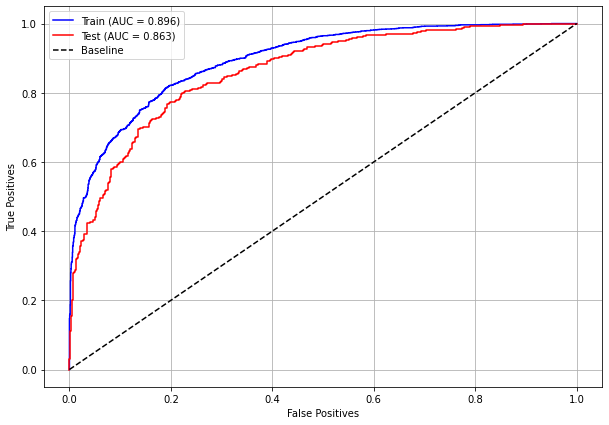

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

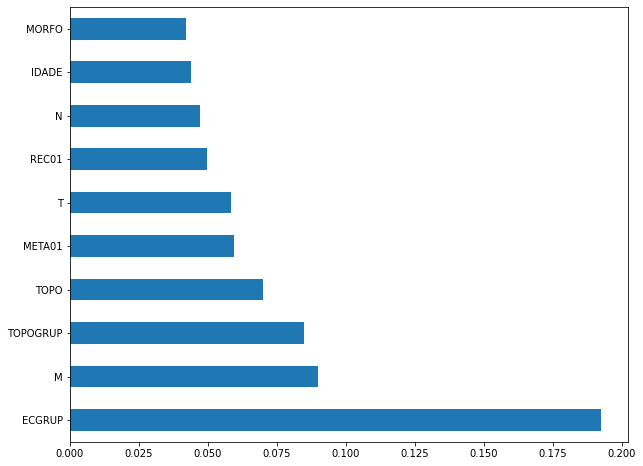

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `M`, `TOPOGRUP` and `TOPO`.

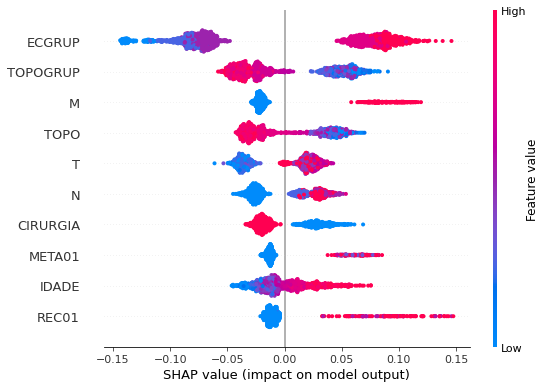

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.55},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.55}, criterion='entropy',
                       max_depth=6, random_state=10)

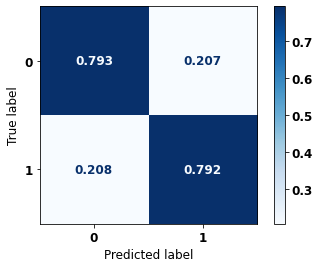


              precision    recall  f1-score   support

           0      0.835     0.793     0.813       921
           1      0.742     0.792     0.766       693

    accuracy                          0.792      1614
   macro avg      0.789     0.792     0.790      1614
weighted avg      0.795     0.792     0.793      1614



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 79% of accuracy.


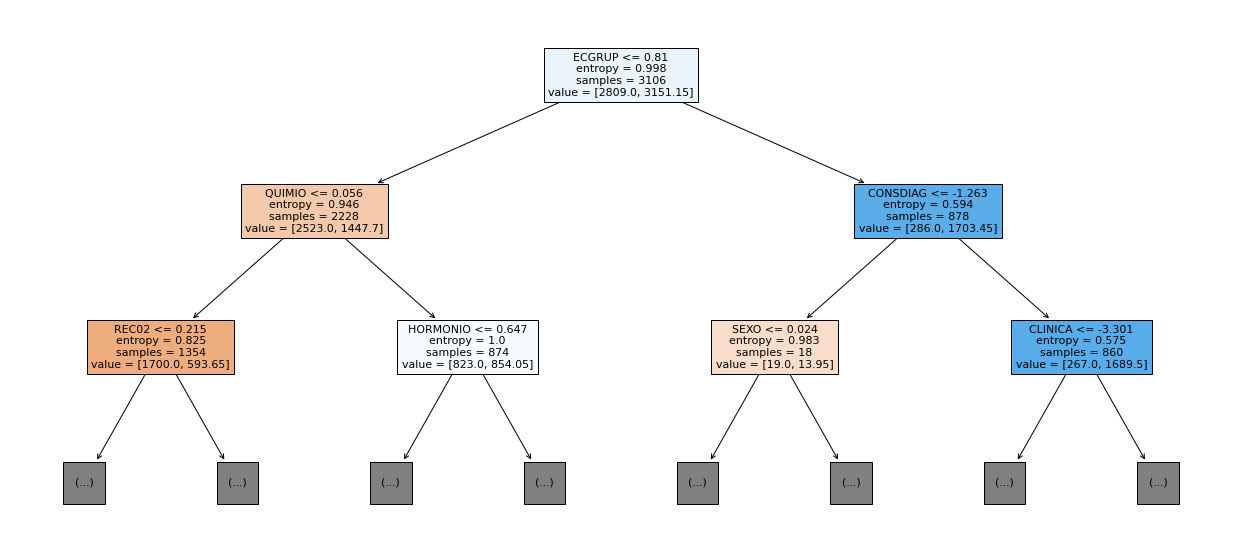

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

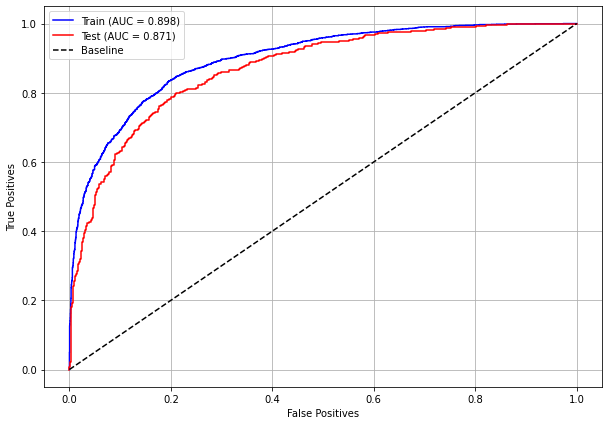

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

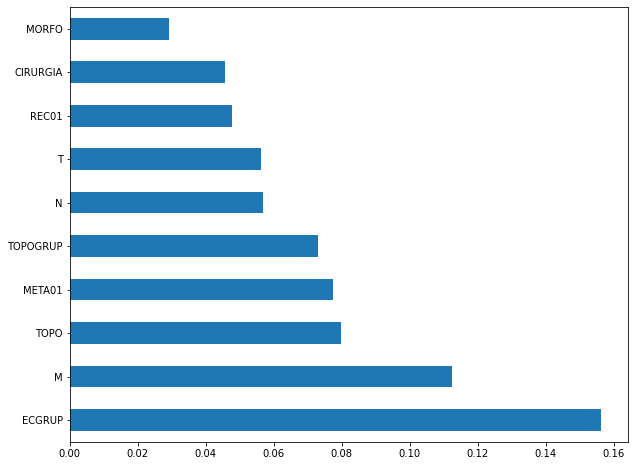

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `META01`.

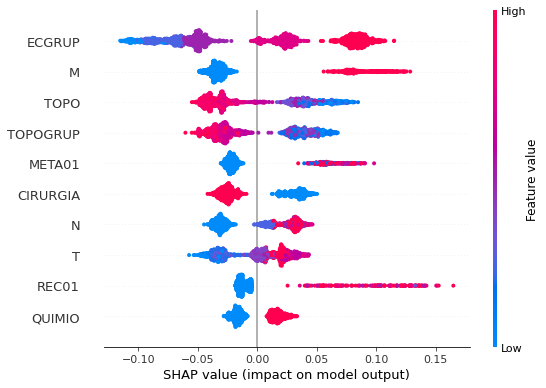

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.907},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.907}, criterion='entropy',
                       max_depth=8, random_state=10)

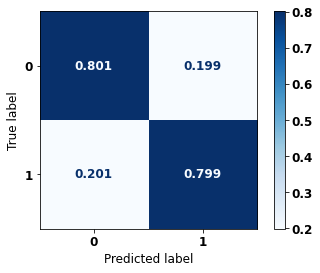


              precision    recall  f1-score   support

           0      0.892     0.801     0.844      1452
           1      0.660     0.799     0.723       701

    accuracy                          0.800      2153
   macro avg      0.776     0.800     0.783      2153
weighted avg      0.816     0.800     0.804      2153



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 80% of accuracy.


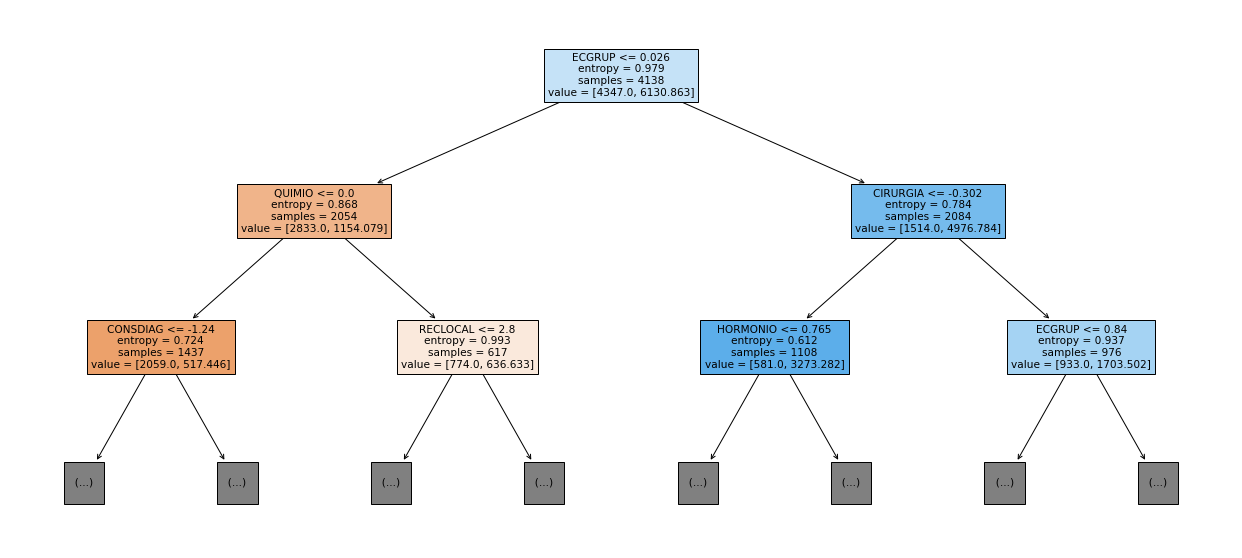

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

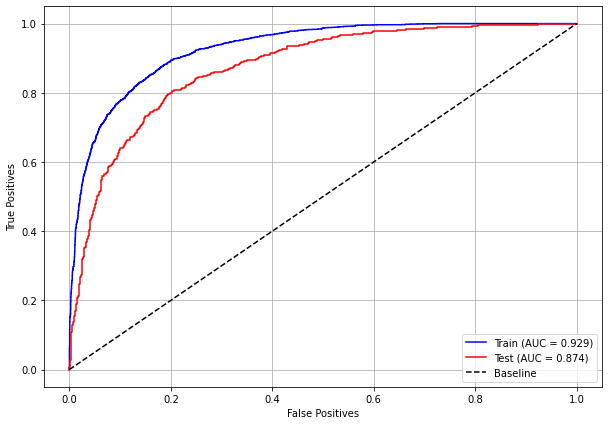

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

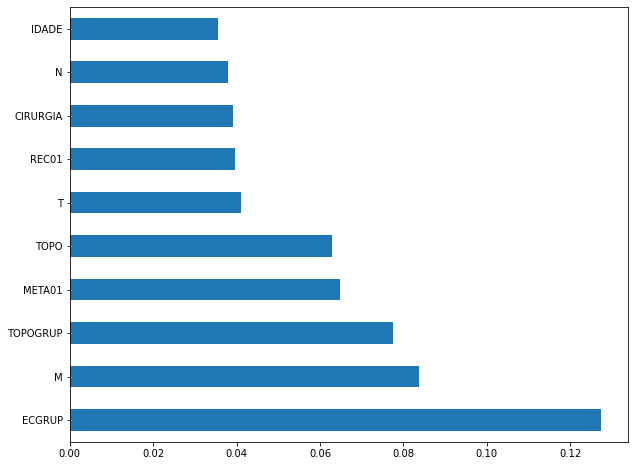

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPOGRUP` and `META01`.

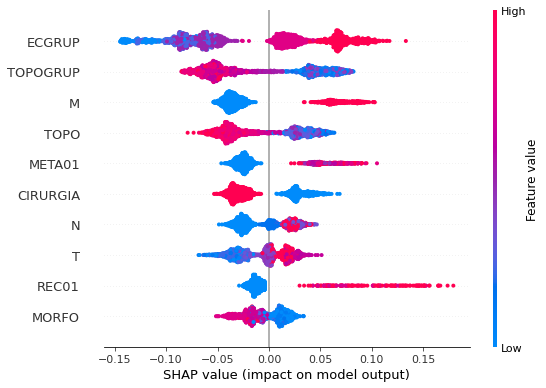

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.65},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 2.65}, criterion='entropy',
                       max_depth=8, random_state=10)

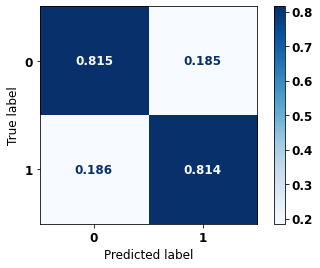


              precision    recall  f1-score   support

           0      0.927     0.815     0.868      1643
           1      0.602     0.814     0.692       565

    accuracy                          0.815      2208
   macro avg      0.765     0.815     0.780      2208
weighted avg      0.844     0.815     0.823      2208



In [ ]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 81% of accuracy.


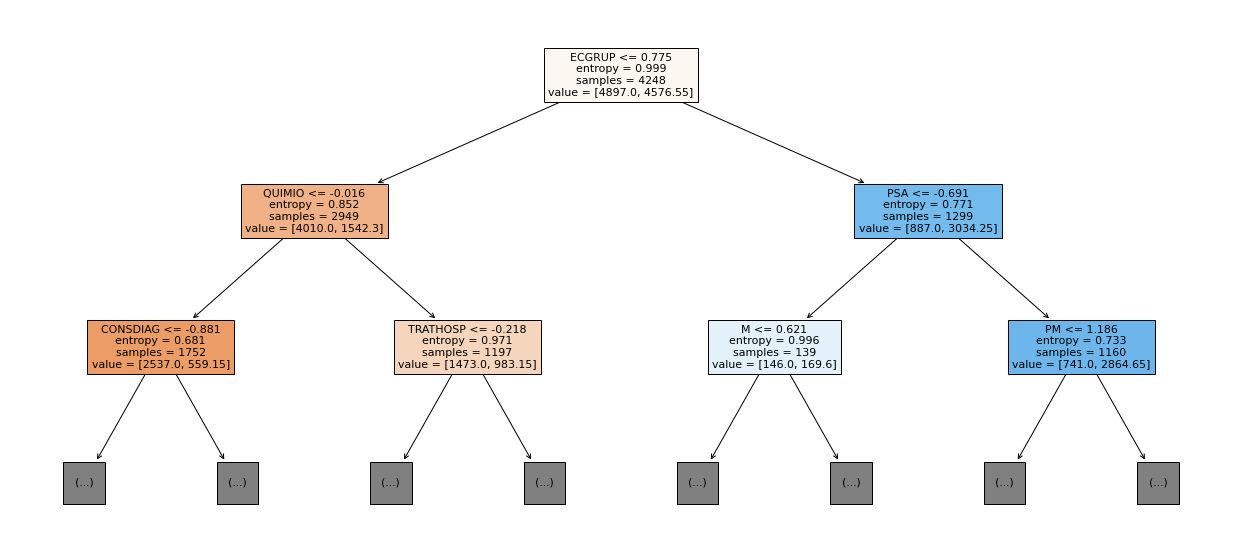

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 2)

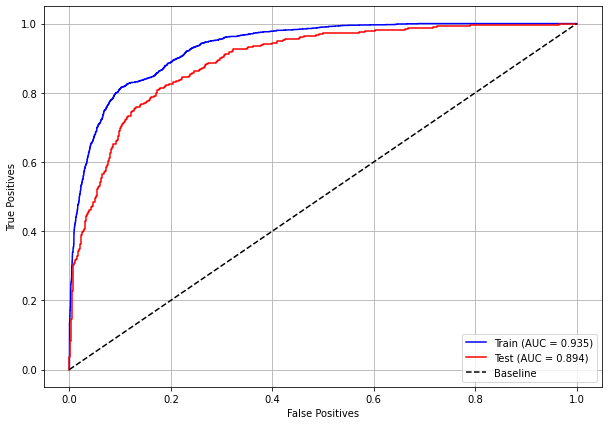

In [ ]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

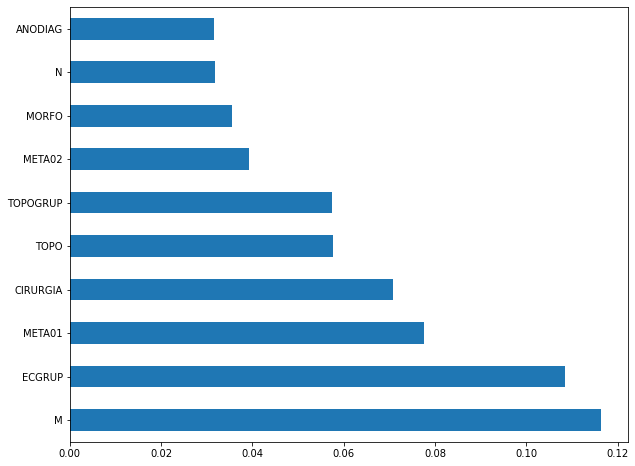

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `M`, `ECGRUP`, `META01` and `CIRURGIA`.

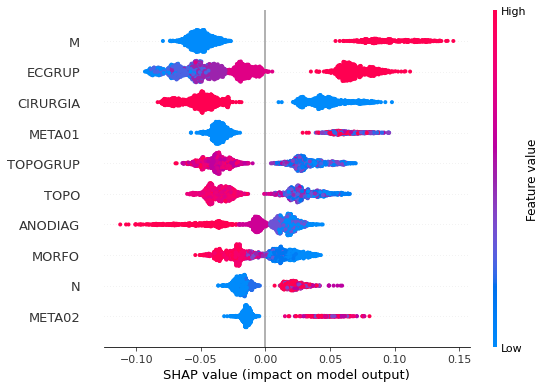

In [ ]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `M` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0.

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.5)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.5)

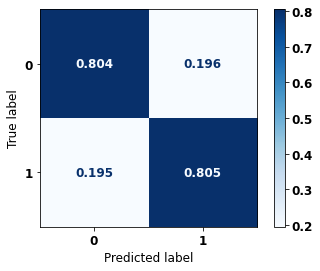


              precision    recall  f1-score   support

           0      0.692     0.804     0.744      5851
           1      0.883     0.805     0.843     10774

    accuracy                          0.805     16625
   macro avg      0.788     0.805     0.793     16625
weighted avg      0.816     0.805     0.808     16625



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 80% of accuracy.

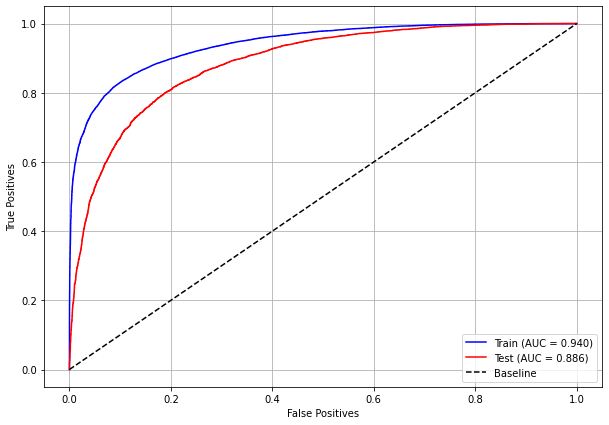

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

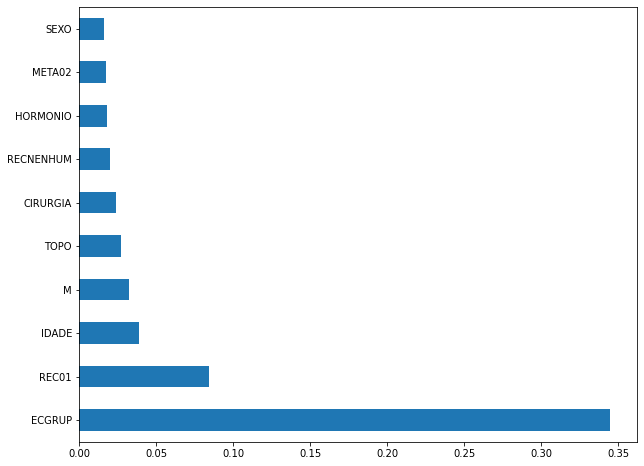

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `REC01`, `IDADE` and `M`.

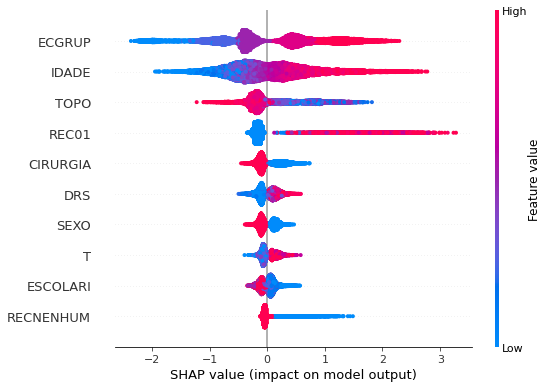

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.727)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.727)

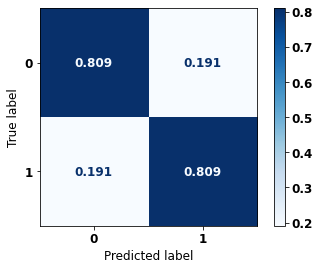


              precision    recall  f1-score   support

           0      0.757     0.809     0.782      8851
           1      0.852     0.809     0.830     12036

    accuracy                          0.809     20887
   macro avg      0.804     0.809     0.806     20887
weighted avg      0.812     0.809     0.809     20887



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.


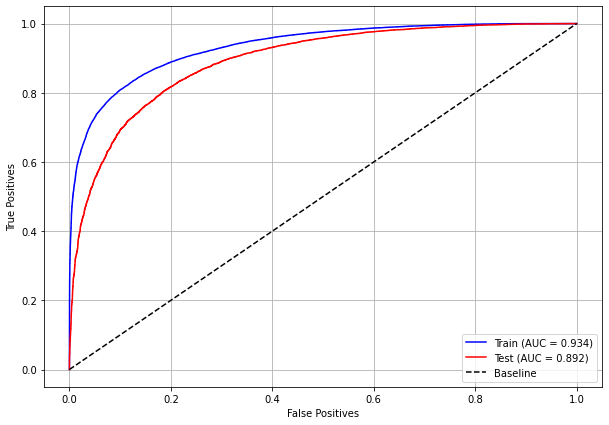

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

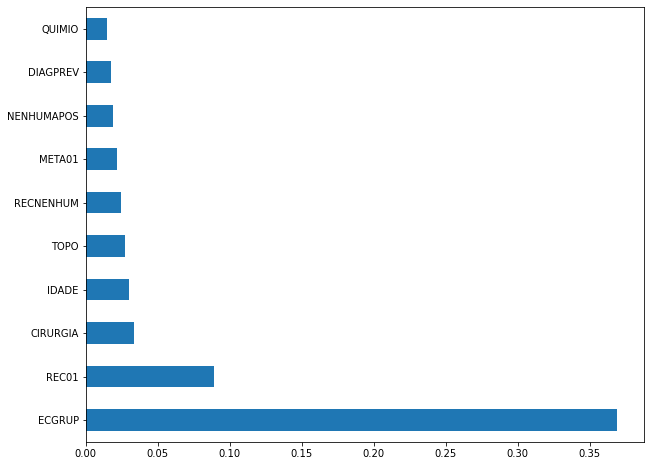

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `CIRURGIA` and `IDADE`. 

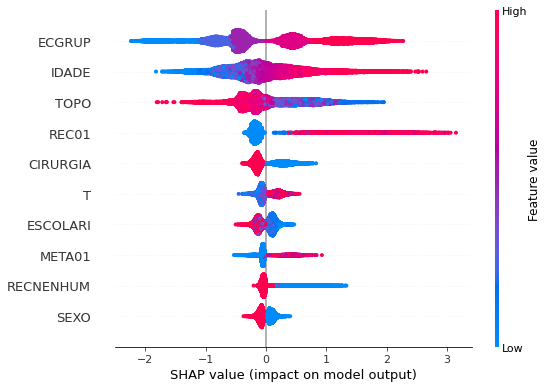

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = XGBClassifier(max_depth=8, 
                             scale_pos_weight=1.15,
                             random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.15)

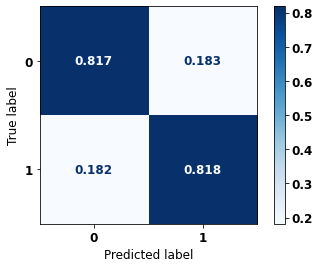


              precision    recall  f1-score   support

           0      0.814     0.817     0.816     13681
           1      0.822     0.818     0.820     14062

    accuracy                          0.818     27743
   macro avg      0.818     0.818     0.818     27743
weighted avg      0.818     0.818     0.818     27743



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 82% of accuracy.

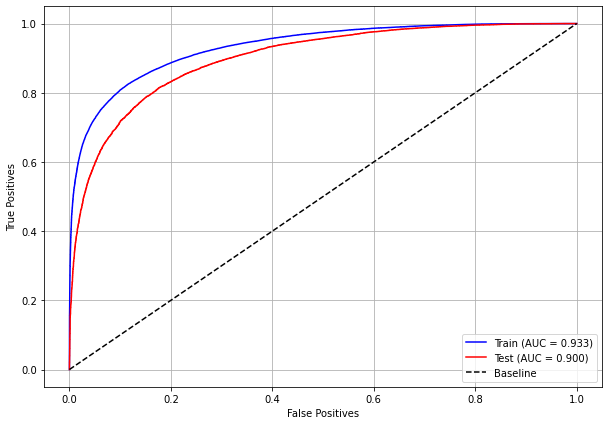

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

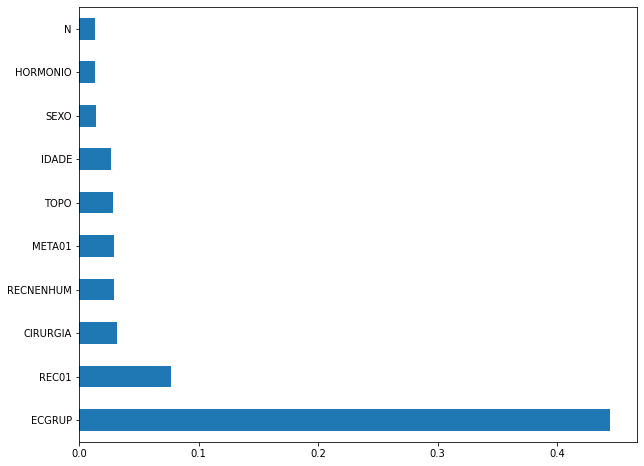

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `CIRURGIA` and `RECNENHUM`. 

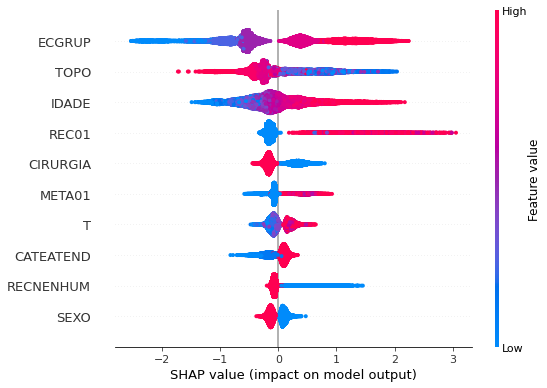

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = XGBClassifier(max_depth=8, 
                             random_state=seed,
                             scale_pos_weight=1.79)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.79)

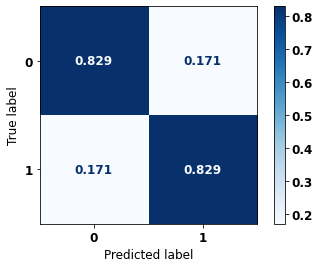


              precision    recall  f1-score   support

           0      0.887     0.829     0.857     21356
           1      0.750     0.829     0.788     13274

    accuracy                          0.829     34630
   macro avg      0.818     0.829     0.822     34630
weighted avg      0.834     0.829     0.830     34630



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 83% of accuracy.

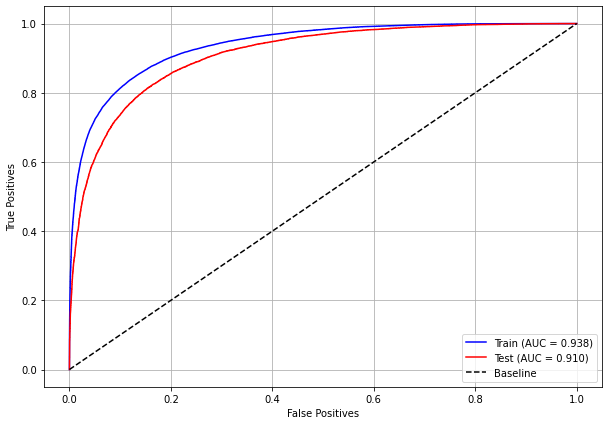

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

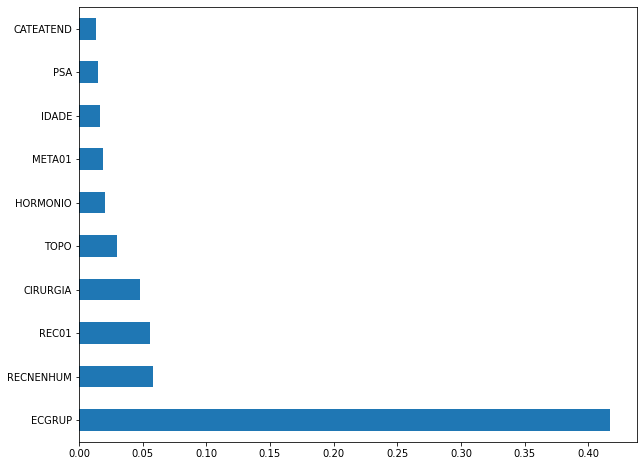

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `RECNENHUM`, `REC01` and `CIRURGIA`. 

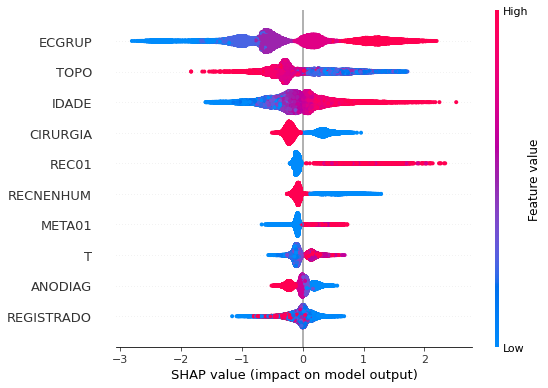

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=3)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=3)

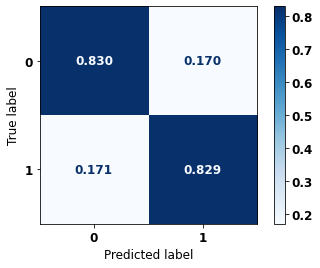


              precision    recall  f1-score   support

           0      0.930     0.830     0.877     19497
           1      0.641     0.829     0.723      7129

    accuracy                          0.830     26626
   macro avg      0.785     0.829     0.800     26626
weighted avg      0.852     0.830     0.836     26626



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, with SP data from 2016 to 2021, shows a good performance of the model, with 83% of accuracy.


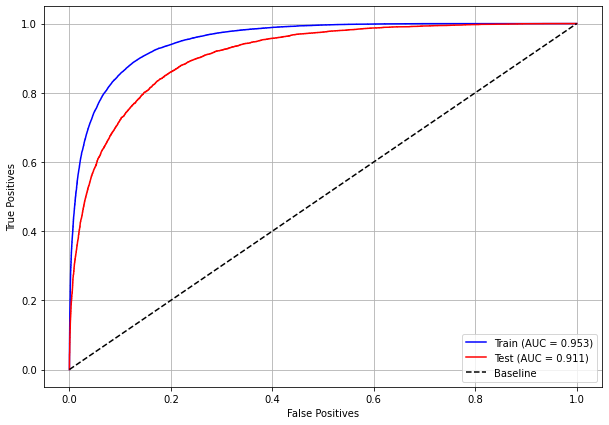

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

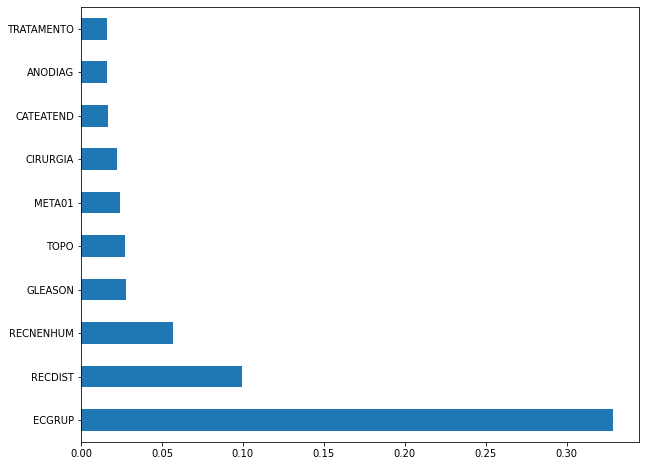

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `RECDIST`, `RECNENHUM` and `GLEASON`.

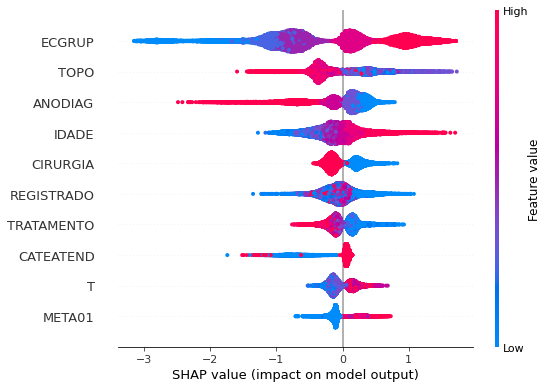

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.705,
                               random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.705)

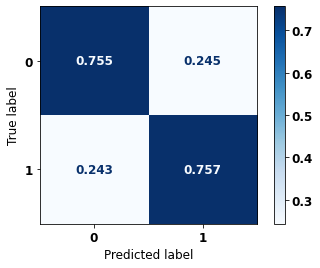


              precision    recall  f1-score   support

           0      0.695     0.755     0.724       396
           1      0.808     0.757     0.782       539

    accuracy                          0.756       935
   macro avg      0.752     0.756     0.753       935
weighted avg      0.760     0.756     0.757       935



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 76% of accuracy.

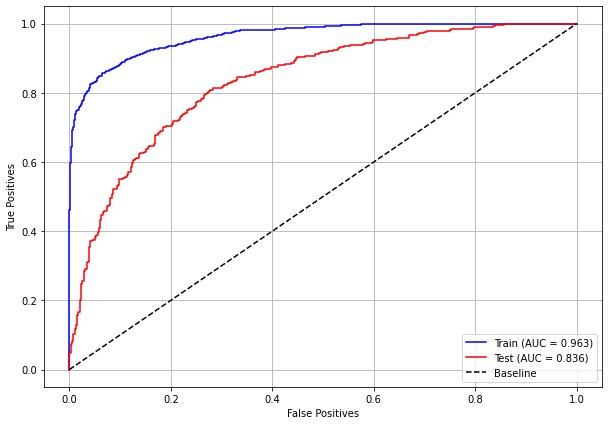

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

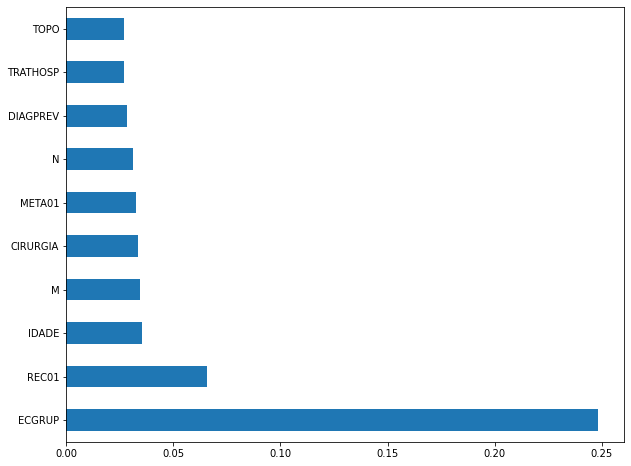

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `IDADE` and `M`.

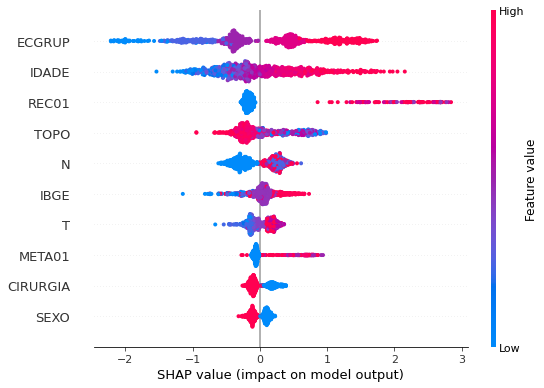

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.13,
                               random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.13)

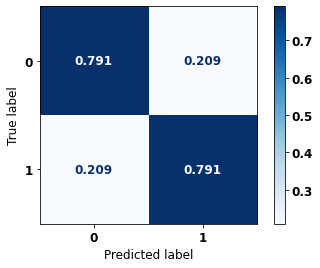


              precision    recall  f1-score   support

           0      0.801     0.791     0.796       678
           1      0.780     0.791     0.786       637

    accuracy                          0.791      1315
   macro avg      0.791     0.791     0.791      1315
weighted avg      0.791     0.791     0.791      1315



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 79% of accuracy.

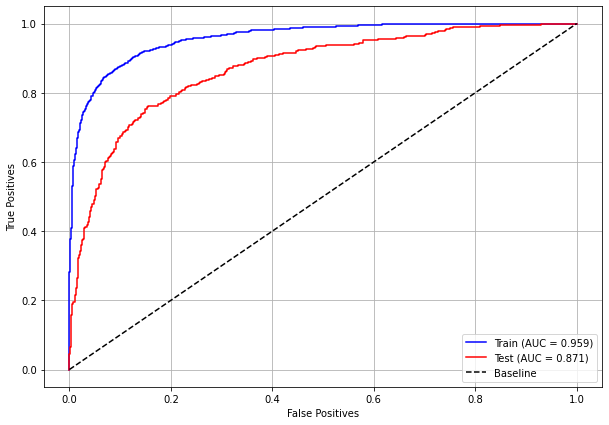

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

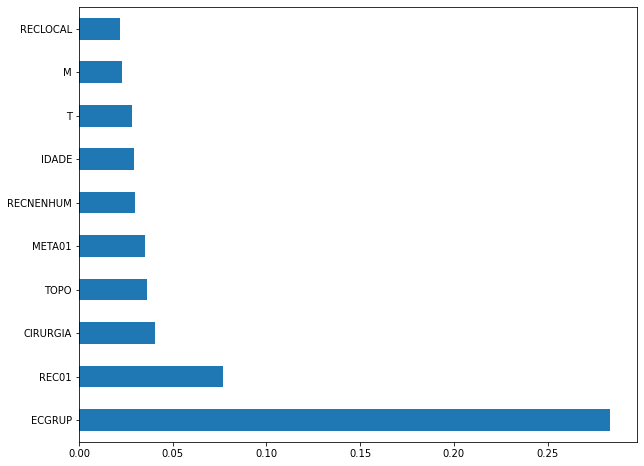

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `CIRURGIA` and `TOPO`.

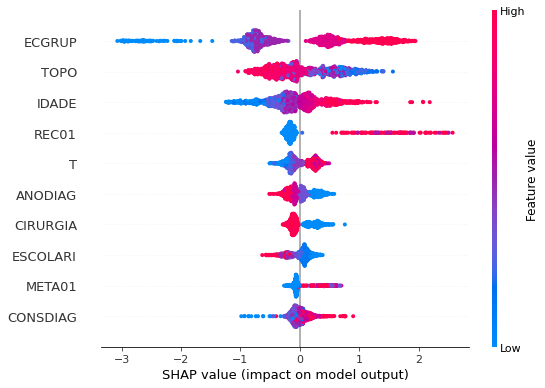

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.27,
                               random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.27)

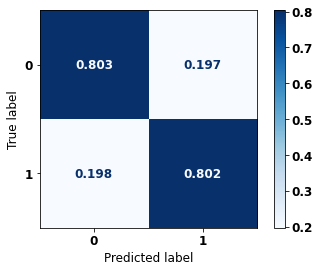


              precision    recall  f1-score   support

           0      0.844     0.803     0.823       921
           1      0.754     0.802     0.778       693

    accuracy                          0.803      1614
   macro avg      0.799     0.803     0.800      1614
weighted avg      0.805     0.803     0.804      1614



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 80% of accuracy.

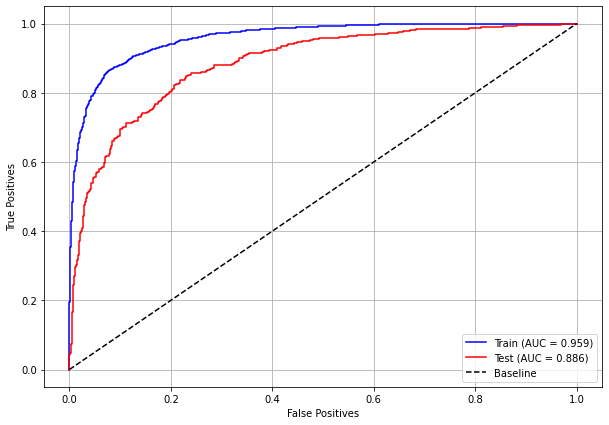

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

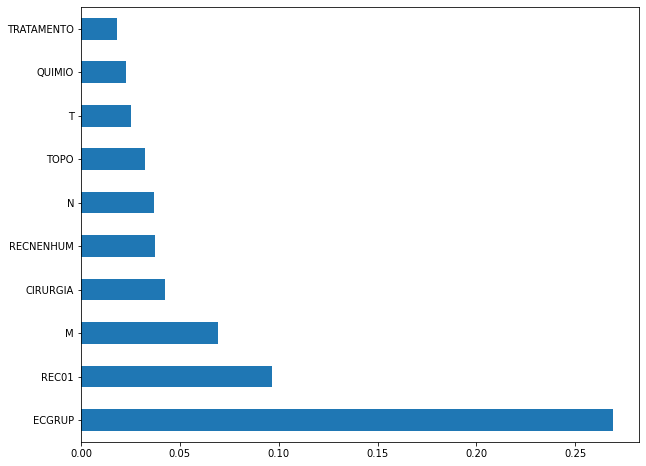

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, with a lot advantage. The following most important features were `REC01`, `M` and `CIRURGIA`.

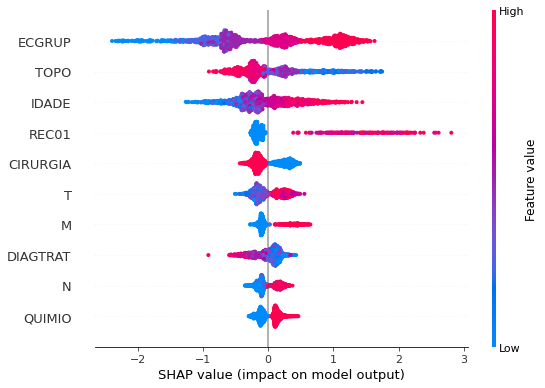

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=2.835,
                               random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=2.835)

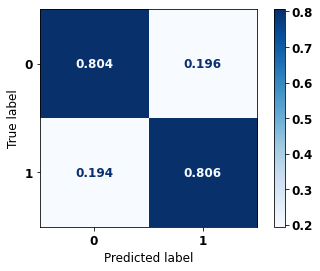


              precision    recall  f1-score   support

           0      0.896     0.804     0.848      1452
           1      0.665     0.806     0.729       701

    accuracy                          0.805      2153
   macro avg      0.781     0.805     0.788      2153
weighted avg      0.821     0.805     0.809      2153



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 80% of accuracy.

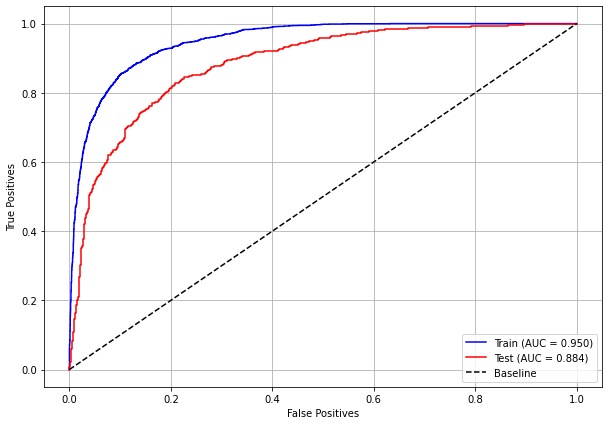

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

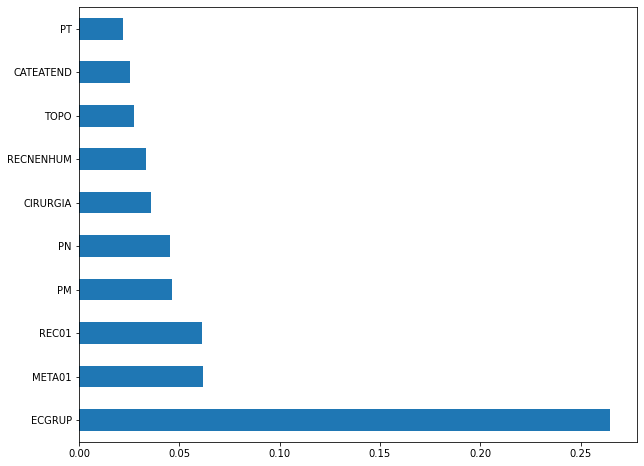

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `META01`, `REC01` and `PM`.

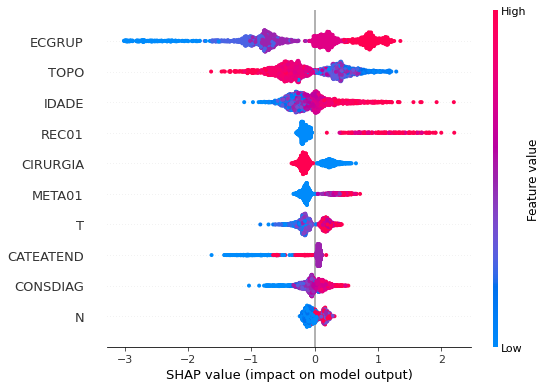

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=3.2,
                               random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=3.2)

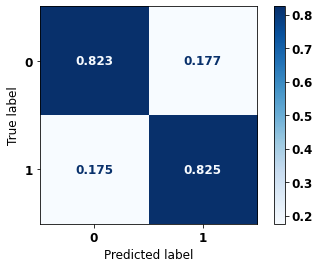


              precision    recall  f1-score   support

           0      0.932     0.823     0.874      1643
           1      0.616     0.825     0.706       565

    accuracy                          0.824      2208
   macro avg      0.774     0.824     0.790      2208
weighted avg      0.851     0.824     0.831      2208



In [ ]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states data from 2016 to 2020, shows the best performance comparing with the other models, with 82% of accuracy.

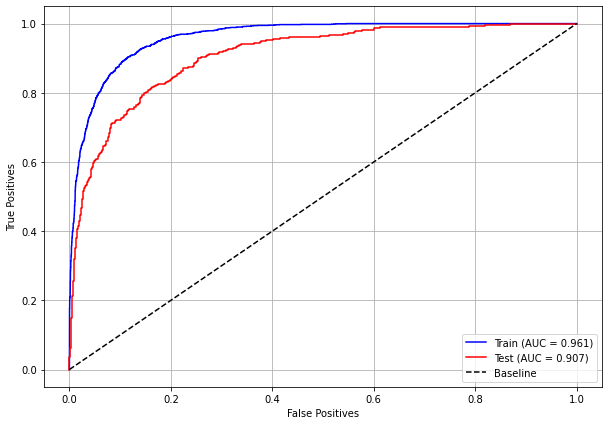

In [ ]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

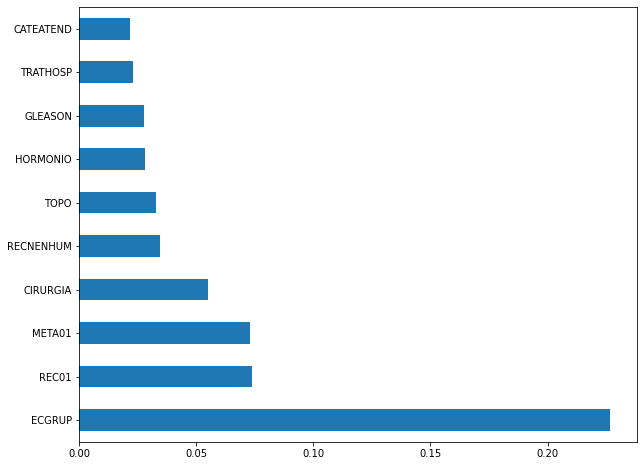

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `ECGRUP`, `REC01`, `META01` and `CIRURGIA`.

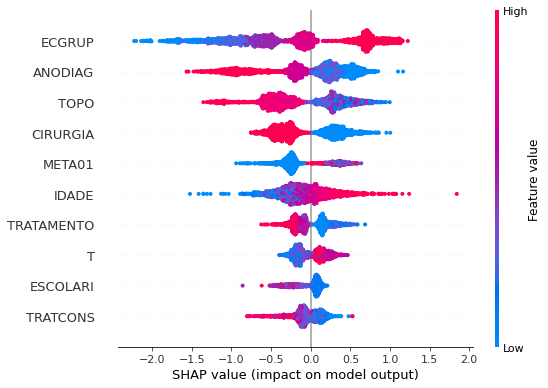

In [ ]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

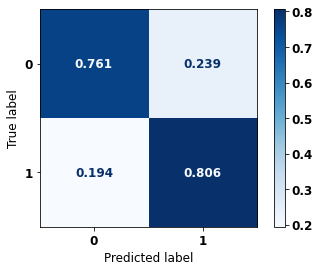


              precision    recall  f1-score   support

           0      0.743     0.761     0.752      8851
           1      0.821     0.806     0.814     12036

    accuracy                          0.787     20887
   macro avg      0.782     0.784     0.783     20887
weighted avg      0.788     0.787     0.787     20887



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

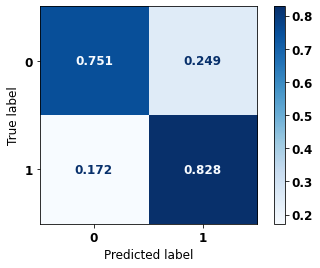


              precision    recall  f1-score   support

           0      0.809     0.751     0.779     13681
           1      0.773     0.828     0.800     14062

    accuracy                          0.790     27743
   macro avg      0.791     0.789     0.789     27743
weighted avg      0.791     0.790     0.789     27743



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

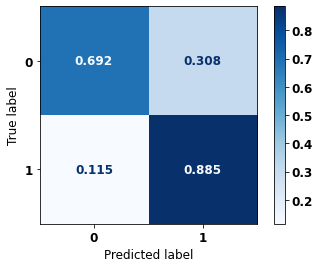


              precision    recall  f1-score   support

           0      0.907     0.692     0.785     21356
           1      0.641     0.885     0.744     13274

    accuracy                          0.766     34630
   macro avg      0.774     0.789     0.765     34630
weighted avg      0.805     0.766     0.769     34630



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

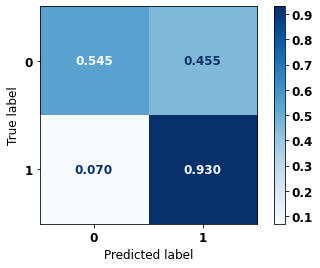


              precision    recall  f1-score   support

           0      0.955     0.545     0.694     19497
           1      0.428     0.930     0.586      7129

    accuracy                          0.649     26626
   macro avg      0.692     0.738     0.640     26626
weighted avg      0.814     0.649     0.665     26626



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

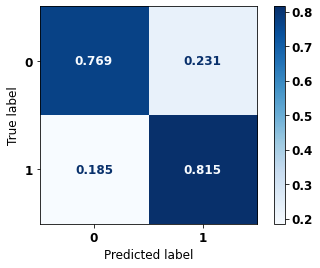


              precision    recall  f1-score   support

           0      0.754     0.769     0.761      8851
           1      0.828     0.815     0.821     12036

    accuracy                          0.796     20887
   macro avg      0.791     0.792     0.791     20887
weighted avg      0.796     0.796     0.796     20887



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

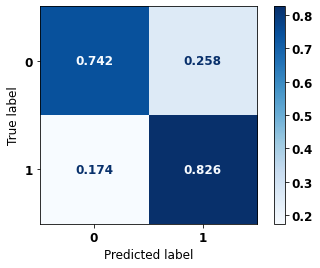


              precision    recall  f1-score   support

           0      0.805     0.742     0.772     13681
           1      0.767     0.826     0.795     14062

    accuracy                          0.784     27743
   macro avg      0.786     0.784     0.784     27743
weighted avg      0.786     0.784     0.784     27743



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

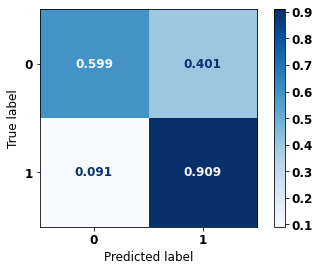


              precision    recall  f1-score   support

           0      0.914     0.599     0.724     21356
           1      0.585     0.909     0.712     13274

    accuracy                          0.718     34630
   macro avg      0.749     0.754     0.718     34630
weighted avg      0.788     0.718     0.719     34630



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

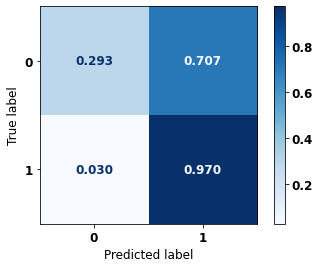


              precision    recall  f1-score   support

           0      0.964     0.293     0.449     19497
           1      0.334     0.970     0.497      7129

    accuracy                          0.474     26626
   macro avg      0.649     0.631     0.473     26626
weighted avg      0.795     0.474     0.462     26626



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

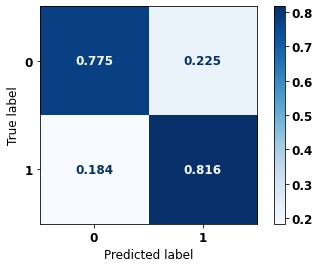


              precision    recall  f1-score   support

           0      0.804     0.775     0.790     13681
           1      0.789     0.816     0.802     14062

    accuracy                          0.796     27743
   macro avg      0.797     0.796     0.796     27743
weighted avg      0.796     0.796     0.796     27743



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

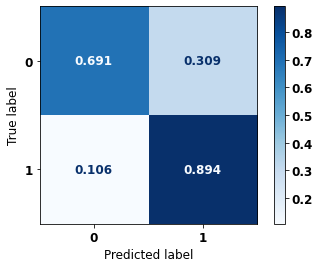


              precision    recall  f1-score   support

           0      0.913     0.691     0.787     21356
           1      0.643     0.894     0.748     13274

    accuracy                          0.769     34630
   macro avg      0.778     0.792     0.767     34630
weighted avg      0.809     0.769     0.772     34630



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

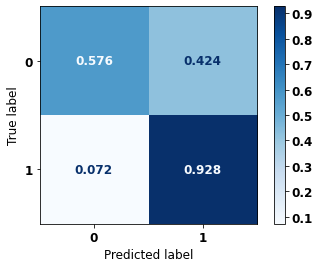


              precision    recall  f1-score   support

           0      0.956     0.576     0.719     19497
           1      0.444     0.928     0.601      7129

    accuracy                          0.670     26626
   macro avg      0.700     0.752     0.660     26626
weighted avg      0.819     0.670     0.687     26626



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

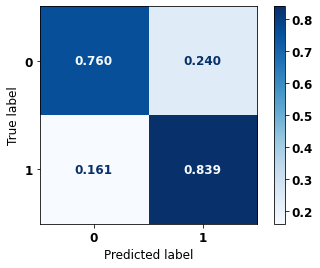


              precision    recall  f1-score   support

           0      0.821     0.760     0.789     13681
           1      0.782     0.839     0.810     14062

    accuracy                          0.800     27743
   macro avg      0.802     0.799     0.799     27743
weighted avg      0.801     0.800     0.800     27743



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

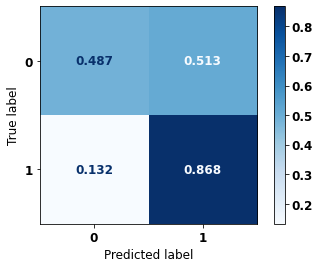


              precision    recall  f1-score   support

           0      0.855     0.487     0.621     21356
           1      0.513     0.868     0.644     13274

    accuracy                          0.633     34630
   macro avg      0.684     0.677     0.633     34630
weighted avg      0.724     0.633     0.630     34630



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

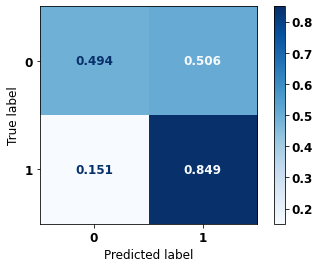


              precision    recall  f1-score   support

           0      0.900     0.494     0.638     19497
           1      0.380     0.849     0.525      7129

    accuracy                          0.589     26626
   macro avg      0.640     0.672     0.582     26626
weighted avg      0.761     0.589     0.608     26626



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

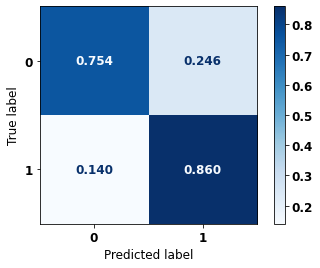


              precision    recall  f1-score   support

           0      0.896     0.754     0.819     21356
           1      0.685     0.860     0.762     13274

    accuracy                          0.794     34630
   macro avg      0.790     0.807     0.791     34630
weighted avg      0.815     0.794     0.797     34630



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

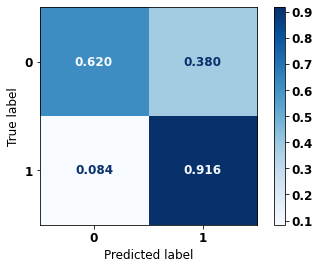


              precision    recall  f1-score   support

           0      0.953     0.620     0.751     19497
           1      0.469     0.916     0.620      7129

    accuracy                          0.699     26626
   macro avg      0.711     0.768     0.686     26626
weighted avg      0.823     0.699     0.716     26626



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

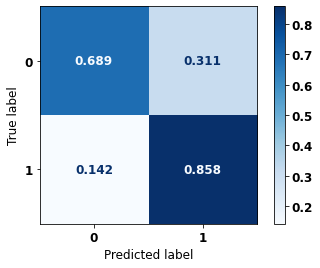


              precision    recall  f1-score   support

           0      0.886     0.689     0.775     21356
           1      0.632     0.858     0.727     13274

    accuracy                          0.754     34630
   macro avg      0.759     0.773     0.751     34630
weighted avg      0.789     0.754     0.757     34630



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

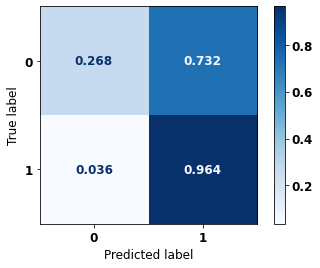


              precision    recall  f1-score   support

           0      0.953     0.268     0.418     19497
           1      0.325     0.964     0.486      7129

    accuracy                          0.454     26626
   macro avg      0.639     0.616     0.452     26626
weighted avg      0.785     0.454     0.436     26626



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

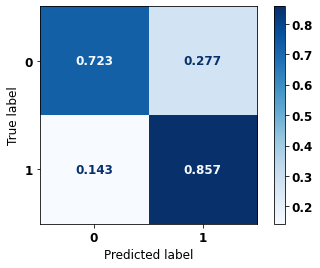


              precision    recall  f1-score   support

           0      0.933     0.723     0.815     19497
           1      0.531     0.857     0.656      7129

    accuracy                          0.759     26626
   macro avg      0.732     0.790     0.735     26626
weighted avg      0.825     0.759     0.772     26626



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

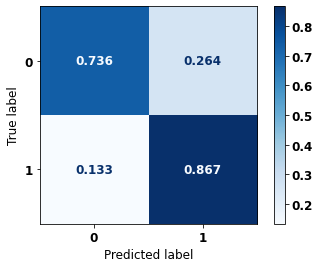


              precision    recall  f1-score   support

           0      0.938     0.736     0.825     19497
           1      0.546     0.867     0.670      7129

    accuracy                          0.771     26626
   macro avg      0.742     0.801     0.747     26626
weighted avg      0.833     0.771     0.783     26626



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

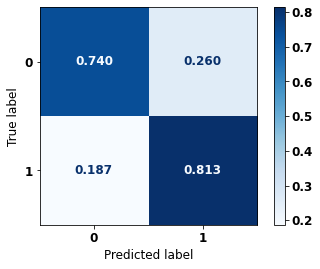


              precision    recall  f1-score   support

           0      0.808     0.740     0.773       678
           1      0.746     0.813     0.778       637

    accuracy                          0.776      1315
   macro avg      0.777     0.777     0.776      1315
weighted avg      0.778     0.776     0.776      1315



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

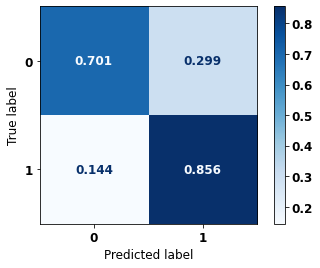


              precision    recall  f1-score   support

           0      0.866     0.701     0.775       921
           1      0.683     0.856     0.760       693

    accuracy                          0.768      1614
   macro avg      0.775     0.779     0.767      1614
weighted avg      0.787     0.768     0.768      1614



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

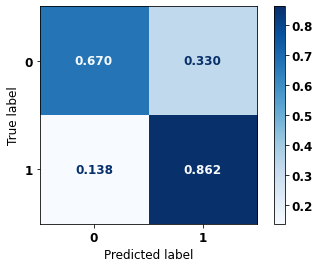


              precision    recall  f1-score   support

           0      0.909     0.670     0.772      1452
           1      0.558     0.862     0.677       701

    accuracy                          0.732      2153
   macro avg      0.734     0.766     0.724      2153
weighted avg      0.795     0.732     0.741      2153



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

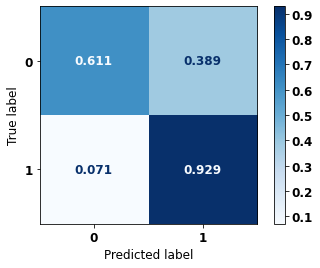


              precision    recall  f1-score   support

           0      0.962     0.611     0.747      1643
           1      0.451     0.929     0.607       565

    accuracy                          0.692      2208
   macro avg      0.706     0.770     0.677      2208
weighted avg      0.831     0.692     0.711      2208



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

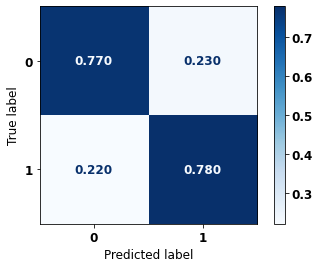


              precision    recall  f1-score   support

           0      0.789     0.770     0.779       678
           1      0.761     0.780     0.771       637

    accuracy                          0.775      1315
   macro avg      0.775     0.775     0.775      1315
weighted avg      0.775     0.775     0.775      1315



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

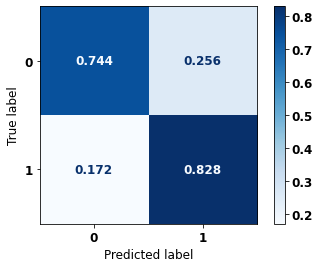


              precision    recall  f1-score   support

           0      0.852     0.744     0.794       921
           1      0.709     0.828     0.764       693

    accuracy                          0.780      1614
   macro avg      0.780     0.786     0.779      1614
weighted avg      0.790     0.780     0.781      1614



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

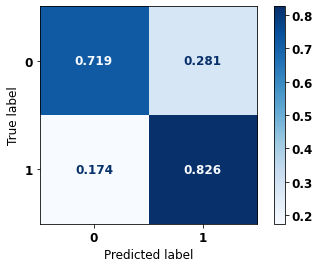


              precision    recall  f1-score   support

           0      0.895     0.719     0.798      1452
           1      0.587     0.826     0.686       701

    accuracy                          0.754      2153
   macro avg      0.741     0.772     0.742      2153
weighted avg      0.795     0.754     0.761      2153



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

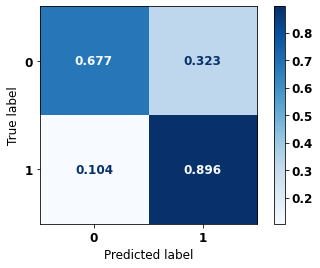


              precision    recall  f1-score   support

           0      0.950     0.677     0.791      1643
           1      0.488     0.896     0.632       565

    accuracy                          0.733      2208
   macro avg      0.719     0.786     0.711      2208
weighted avg      0.832     0.733     0.750      2208



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

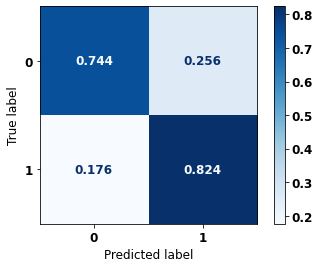


              precision    recall  f1-score   support

           0      0.849     0.744     0.793       921
           1      0.708     0.824     0.761       693

    accuracy                          0.778      1614
   macro avg      0.778     0.784     0.777      1614
weighted avg      0.788     0.778     0.779      1614



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

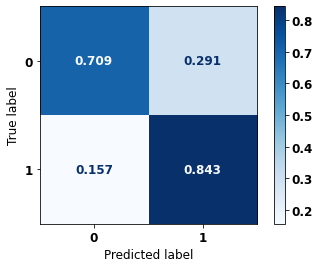


              precision    recall  f1-score   support

           0      0.903     0.709     0.794      1452
           1      0.583     0.843     0.689       701

    accuracy                          0.752      2153
   macro avg      0.743     0.776     0.742      2153
weighted avg      0.799     0.752     0.760      2153



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

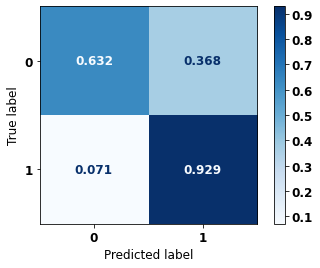


              precision    recall  f1-score   support

           0      0.963     0.632     0.763      1643
           1      0.465     0.929     0.620       565

    accuracy                          0.708      2208
   macro avg      0.714     0.781     0.692      2208
weighted avg      0.836     0.708     0.727      2208



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

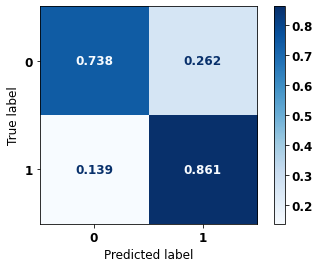


              precision    recall  f1-score   support

           0      0.876     0.738     0.801       921
           1      0.712     0.861     0.780       693

    accuracy                          0.791      1614
   macro avg      0.794     0.800     0.791      1614
weighted avg      0.806     0.791     0.792      1614



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

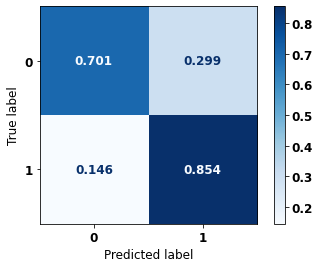


              precision    recall  f1-score   support

           0      0.909     0.701     0.792      1452
           1      0.580     0.854     0.691       701

    accuracy                          0.751      2153
   macro avg      0.744     0.778     0.741      2153
weighted avg      0.802     0.751     0.759      2153



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

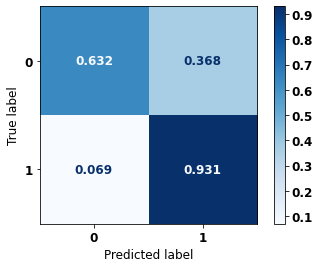


              precision    recall  f1-score   support

           0      0.964     0.632     0.764      1643
           1      0.465     0.931     0.621       565

    accuracy                          0.709      2208
   macro avg      0.715     0.782     0.692      2208
weighted avg      0.836     0.709     0.727      2208



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

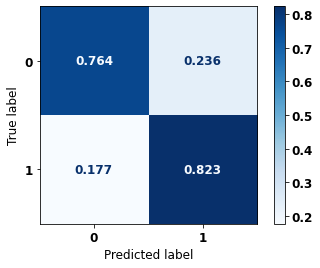


              precision    recall  f1-score   support

           0      0.900     0.764     0.827      1452
           1      0.628     0.823     0.712       701

    accuracy                          0.784      2153
   macro avg      0.764     0.794     0.769      2153
weighted avg      0.811     0.784     0.789      2153



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

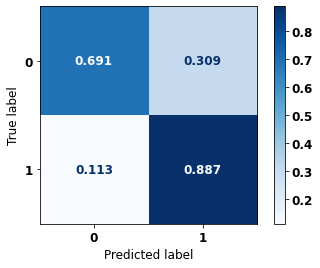


              precision    recall  f1-score   support

           0      0.947     0.691     0.799      1643
           1      0.497     0.887     0.637       565

    accuracy                          0.741      2208
   macro avg      0.722     0.789     0.718      2208
weighted avg      0.832     0.741     0.758      2208



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

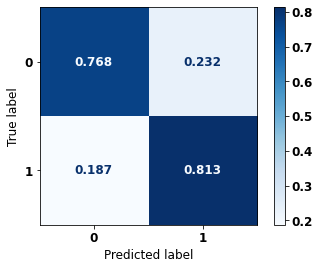


              precision    recall  f1-score   support

           0      0.895     0.768     0.827      1452
           1      0.628     0.813     0.709       701

    accuracy                          0.783      2153
   macro avg      0.762     0.791     0.768      2153
weighted avg      0.808     0.783     0.788      2153



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

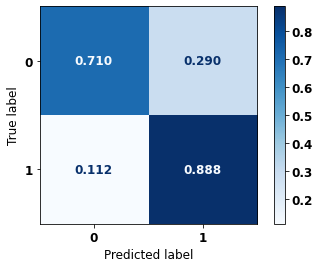


              precision    recall  f1-score   support

           0      0.949     0.710     0.812      1643
           1      0.513     0.888     0.650       565

    accuracy                          0.755      2208
   macro avg      0.731     0.799     0.731      2208
weighted avg      0.837     0.755     0.771      2208



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

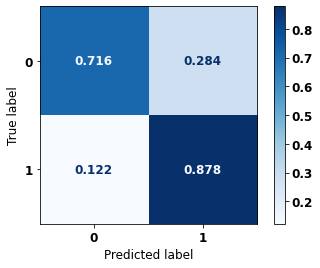


              precision    recall  f1-score   support

           0      0.945     0.716     0.814      1643
           1      0.515     0.878     0.649       565

    accuracy                          0.757      2208
   macro avg      0.730     0.797     0.732      2208
weighted avg      0.835     0.757     0.772      2208



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

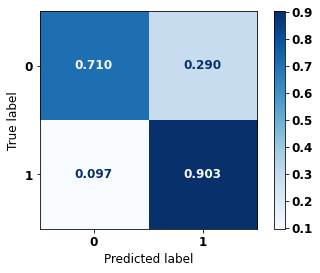


              precision    recall  f1-score   support

           0      0.955     0.710     0.815      1643
           1      0.517     0.903     0.658       565

    accuracy                          0.760      2208
   macro avg      0.736     0.806     0.736      2208
weighted avg      0.843     0.760     0.774      2208



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)

# **Fourth approach**

Approach with grouped years, using only morphologies with final digit equal to 3 and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_cancer']

lb = 'obito_geral'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, 
                                                                                                last_year=2003, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (46098, 65), X_test = (15367, 65)
y_train = (46098,), y_test = (15367,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (58169, 65), X_test = (19390, 65)
y_train = (58169,), y_test = (19390,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (77412, 65), X_test = (25804, 65)
y_train = (77412,), y_test = (25804,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (96124, 65), X_test = (32042, 65)
y_train = (96124,), y_test = (32042,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2021, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (73682, 65), X_test = (24561, 65)
y_train = (73682,), y_test = (24561,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2000,
                                                                                                last_year=2003, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2592, 65), X_test = (865, 65)
y_train = (2592,), y_test = (865,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3694, 65), X_test = (1232, 65)
y_train = (3694,), y_test = (1232,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4536, 65), X_test = (1513, 65)
y_train = (4536,), y_test = (1513,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6069, 65), X_test = (2024, 65)
y_train = (6069,), y_test = (2024,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2020, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6185, 65), X_test = (2062, 65)
y_train = (6185,), y_test = (2062,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:2.156, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 2.156, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

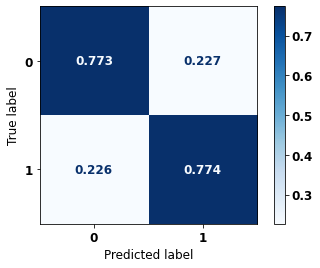


              precision    recall  f1-score   support

           0      0.607     0.773     0.680      4788
           1      0.883     0.774     0.825     10579

    accuracy                          0.774     15367
   macro avg      0.745     0.773     0.752     15367
weighted avg      0.797     0.774     0.780     15367



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 77% of accuracy.


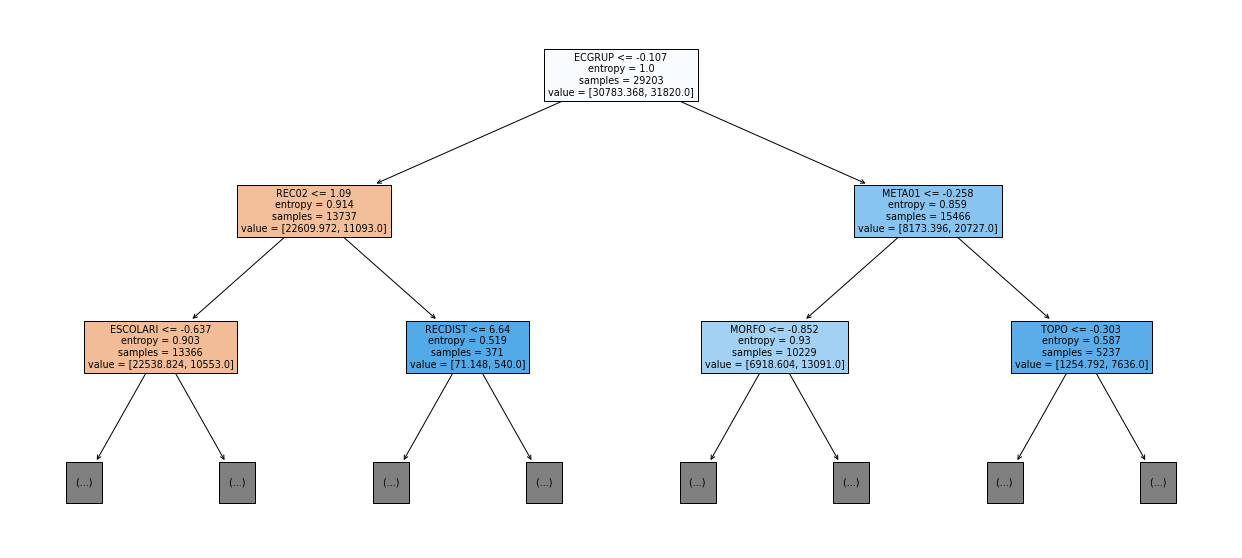

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

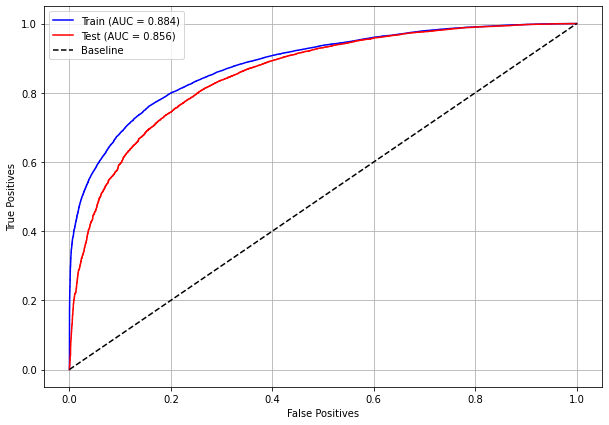

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

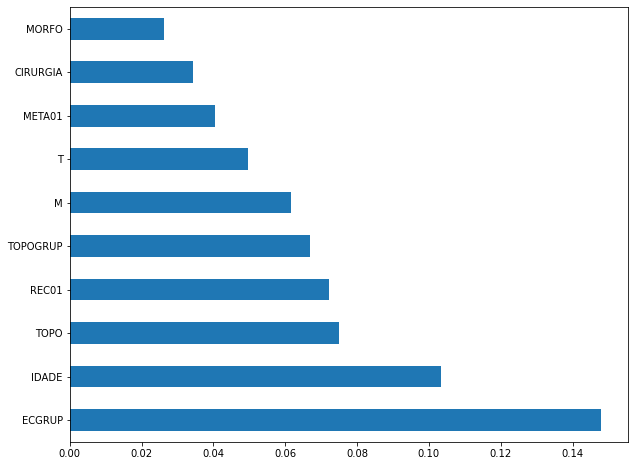

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `IDADE`, `TOPO`, and `REC01`.

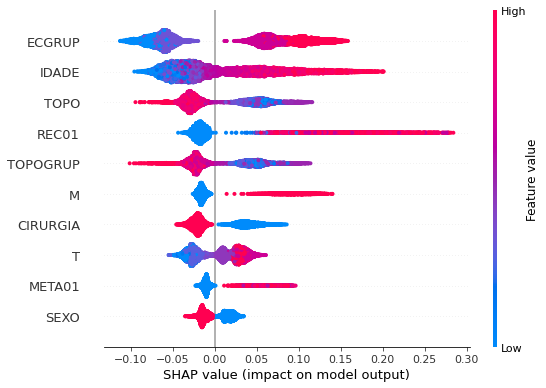

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.28, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.28, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

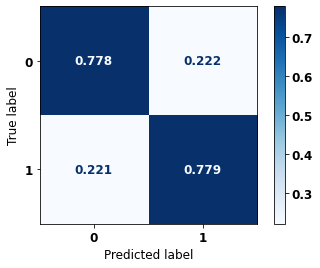


              precision    recall  f1-score   support

           0      0.693     0.778     0.733      7582
           1      0.845     0.779     0.811     11808

    accuracy                          0.778     19390
   macro avg      0.769     0.778     0.772     19390
weighted avg      0.786     0.778     0.780     19390



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 78% of accuracy.

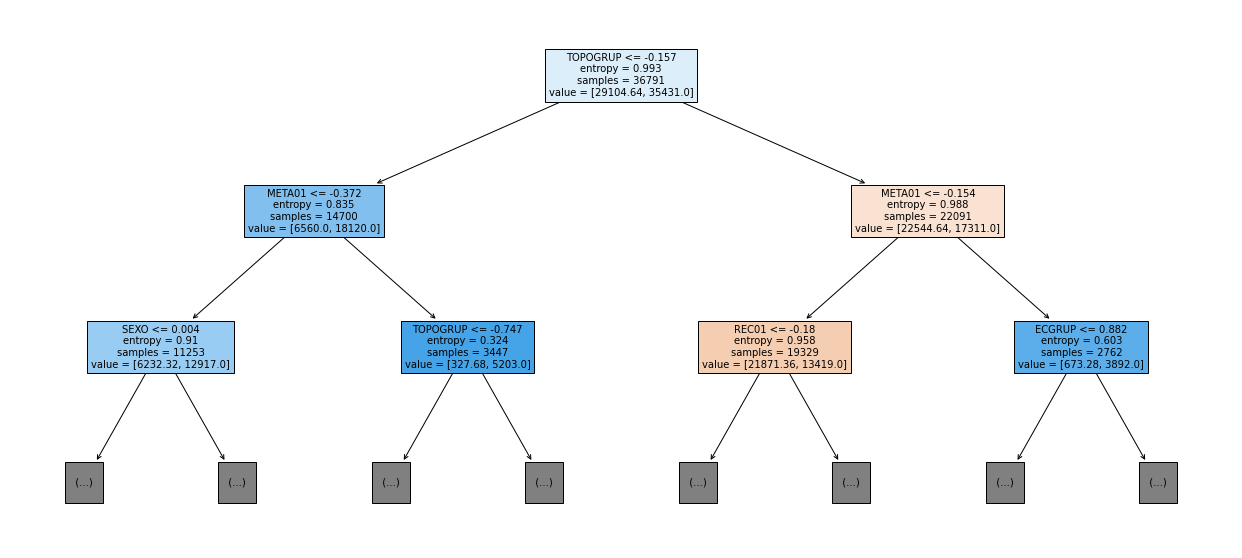

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

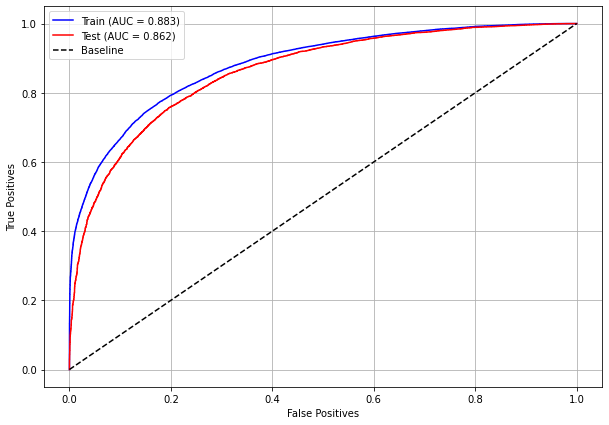

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

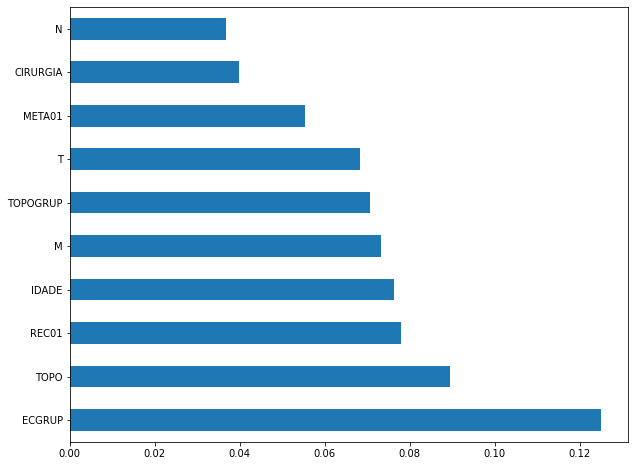

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPO`, `REC01` and `IDADE`.

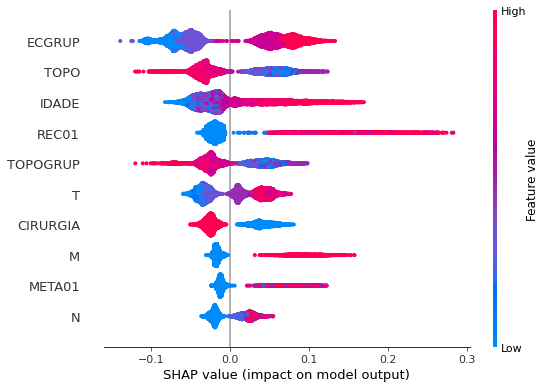

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.0655},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.0655}, criterion='entropy',
                       max_depth=10, random_state=10)

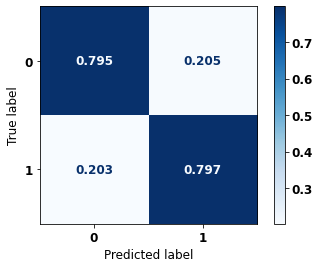


              precision    recall  f1-score   support

           0      0.774     0.795     0.784     12014
           1      0.817     0.797     0.807     13790

    accuracy                          0.796     25804
   macro avg      0.795     0.796     0.795     25804
weighted avg      0.797     0.796     0.796     25804



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 80% of accuray.

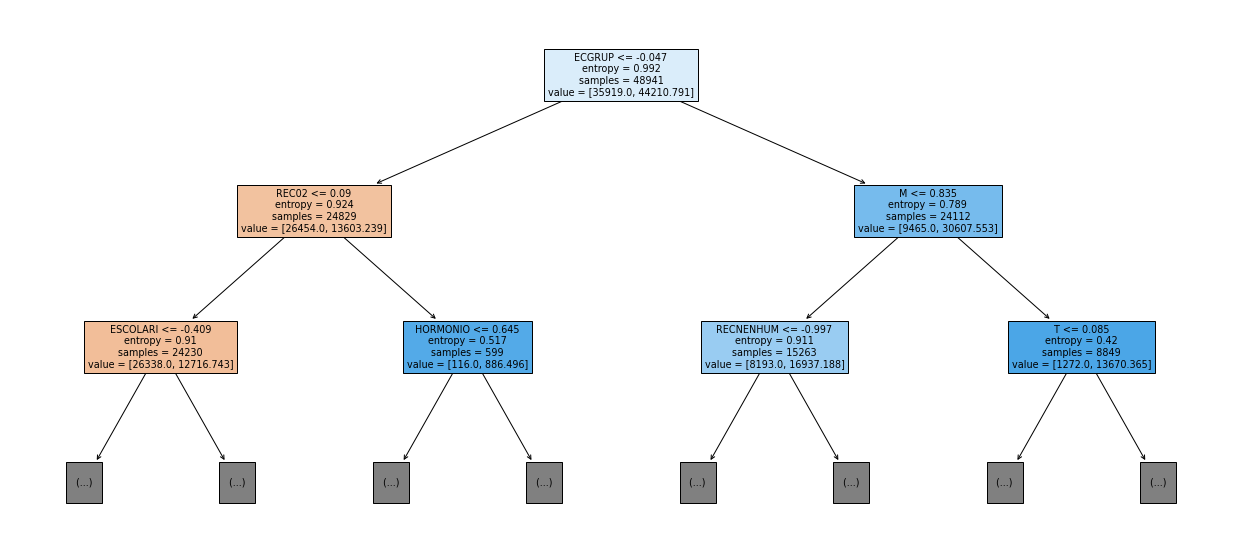

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

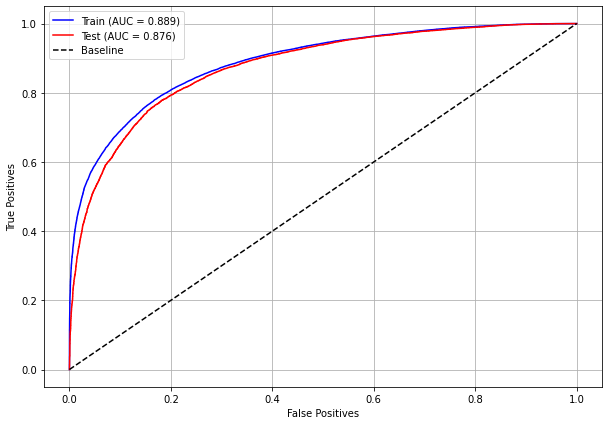

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

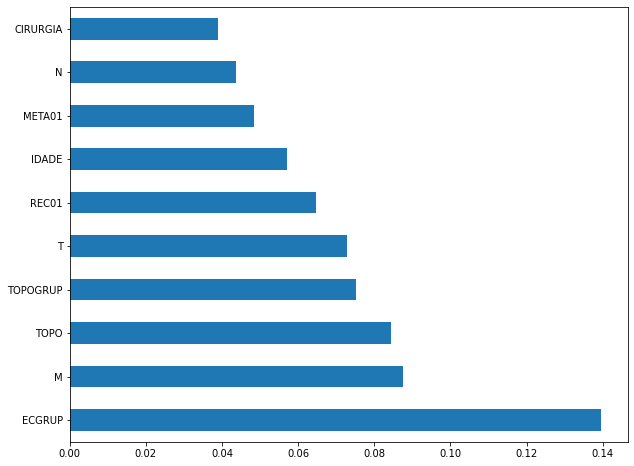

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `TOPOGRUP`.

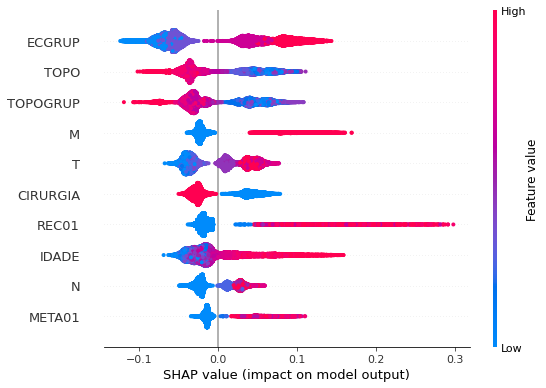

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.778},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 1.778}, criterion='entropy',
                       max_depth=10, random_state=10)

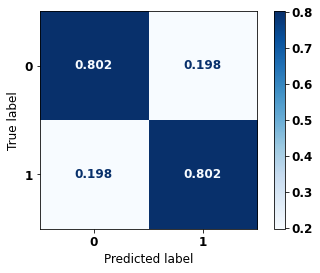


              precision    recall  f1-score   support

           0      0.854     0.802     0.827     18944
           1      0.737     0.802     0.768     13098

    accuracy                          0.802     32042
   macro avg      0.795     0.802     0.798     32042
weighted avg      0.806     0.802     0.803     32042



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 80% of accuracy.

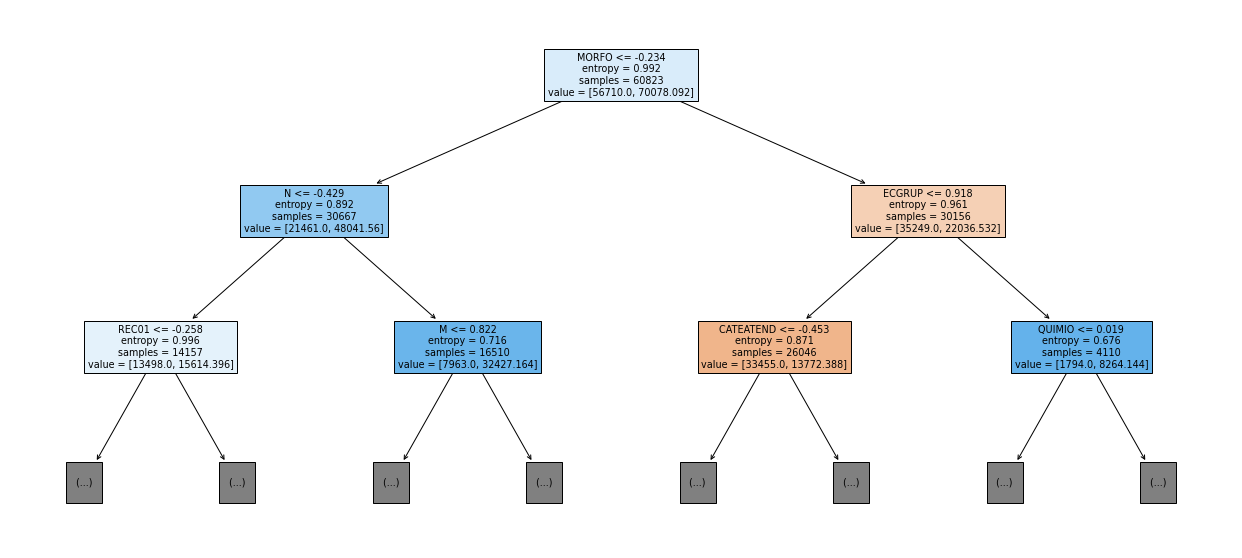

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

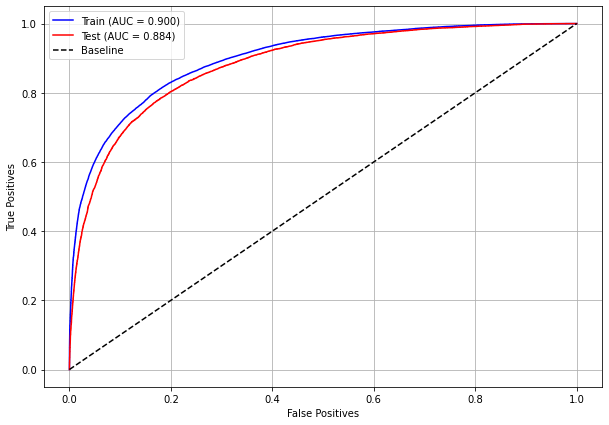

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

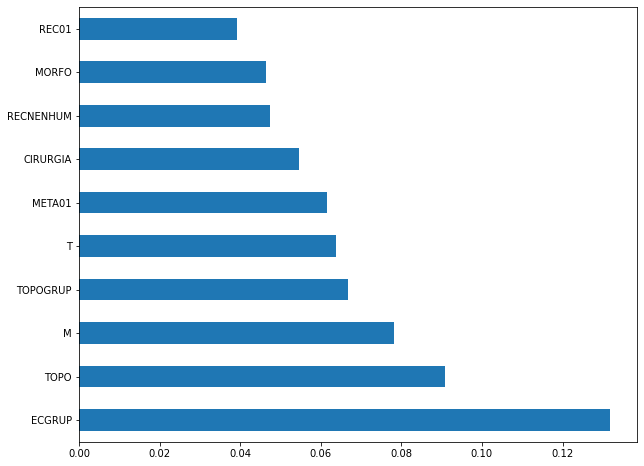

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `TOPO`, `M` and `TOPOGRUP`.

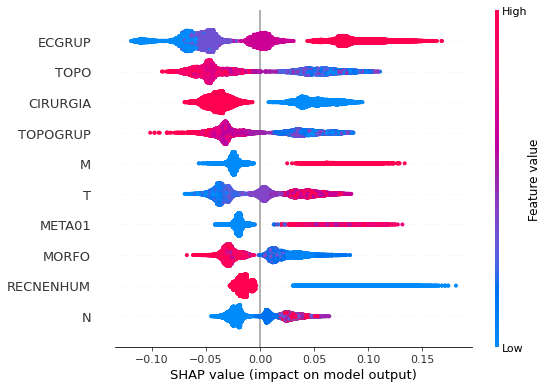

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2.58},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 2.58}, criterion='entropy',
                       max_depth=10, random_state=10)

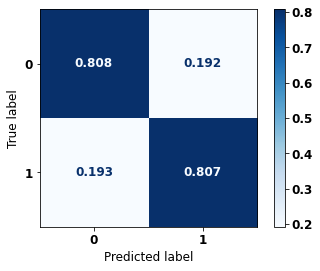


              precision    recall  f1-score   support

           0      0.912     0.808     0.857     17508
           1      0.628     0.807     0.707      7053

    accuracy                          0.808     24561
   macro avg      0.770     0.808     0.782     24561
weighted avg      0.831     0.808     0.814     24561



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.

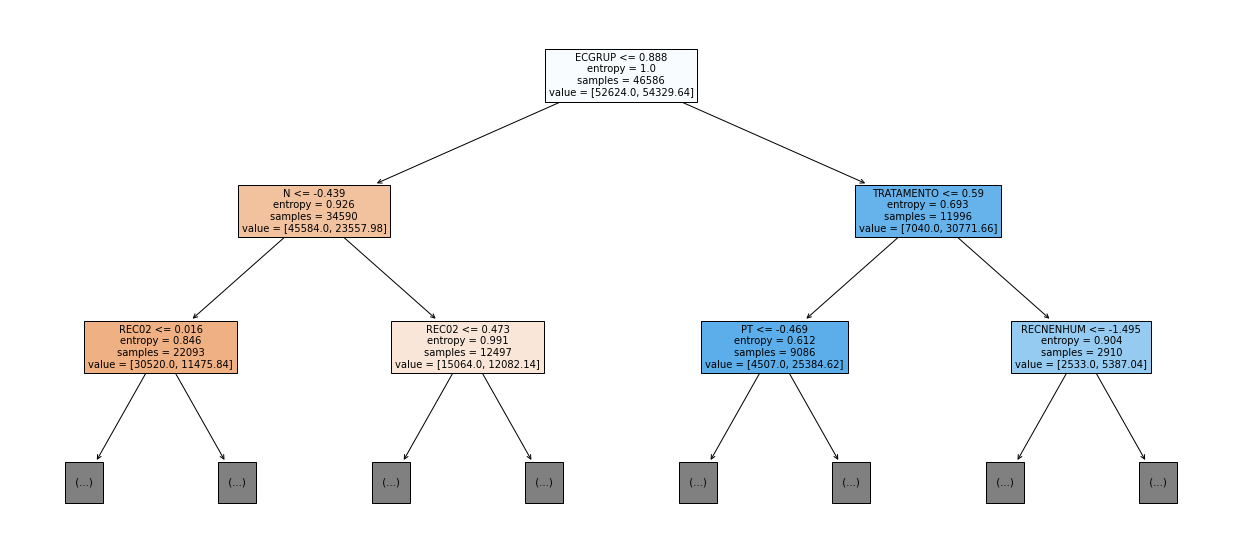

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

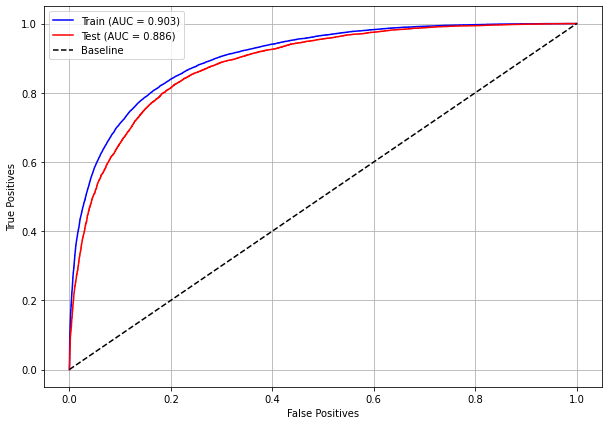

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

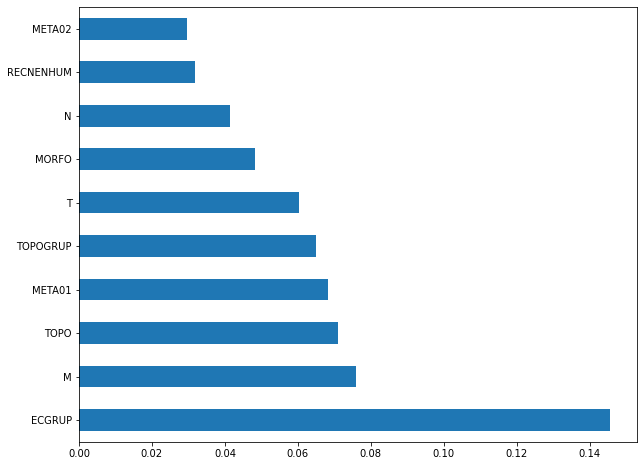

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO`, and `META01`.



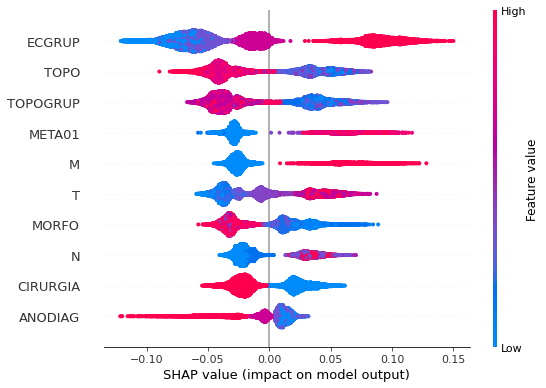

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.285, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.285, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

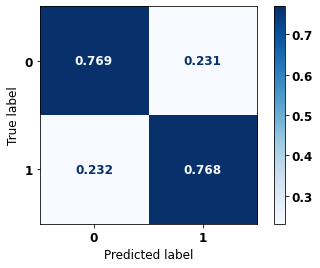


              precision    recall  f1-score   support

           0      0.676     0.769     0.720       334
           1      0.841     0.768     0.803       531

    accuracy                          0.769       865
   macro avg      0.759     0.769     0.762       865
weighted avg      0.778     0.769     0.771       865



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 77% of accuracy.

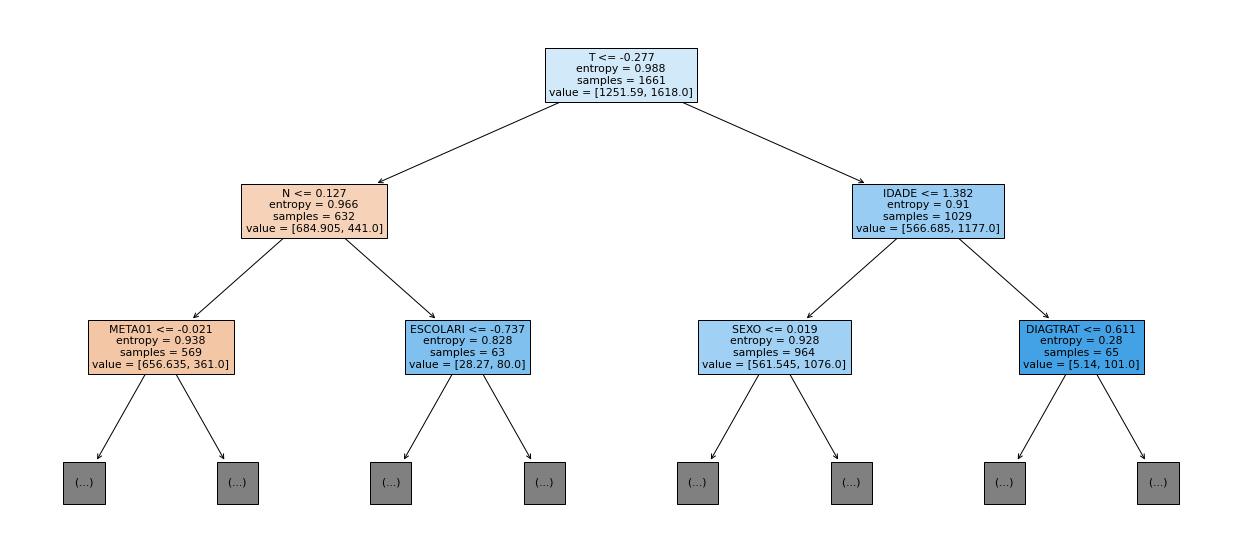

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

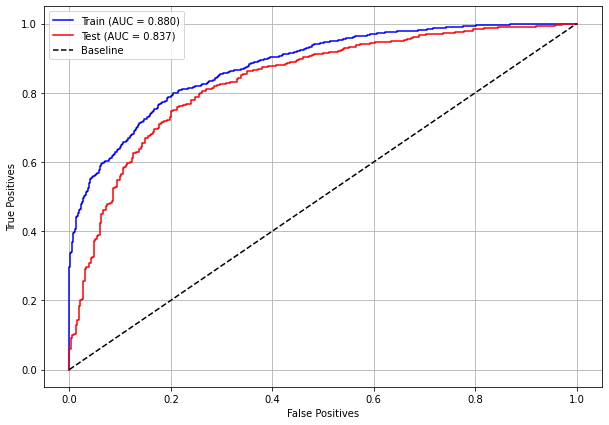

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

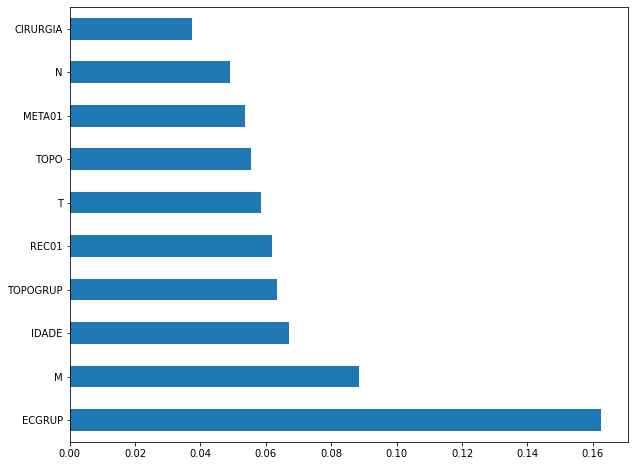

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `M`, `IDADE` and `TOPOGRUP`.

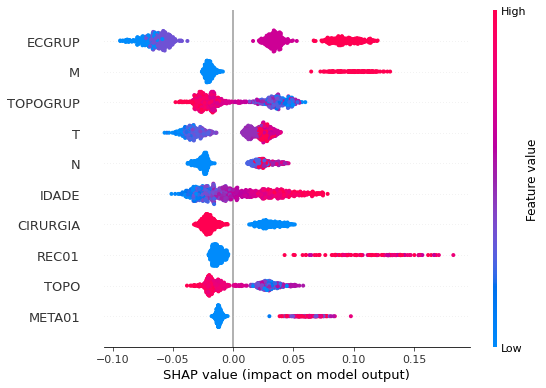

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.174},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.174}, criterion='entropy',
                       max_depth=6, random_state=10)

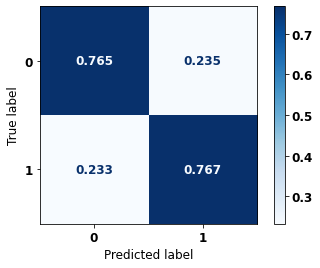


              precision    recall  f1-score   support

           0      0.757     0.765     0.761       600
           1      0.775     0.767     0.771       632

    accuracy                          0.766      1232
   macro avg      0.766     0.766     0.766      1232
weighted avg      0.766     0.766     0.766      1232



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 77% of accuracy.


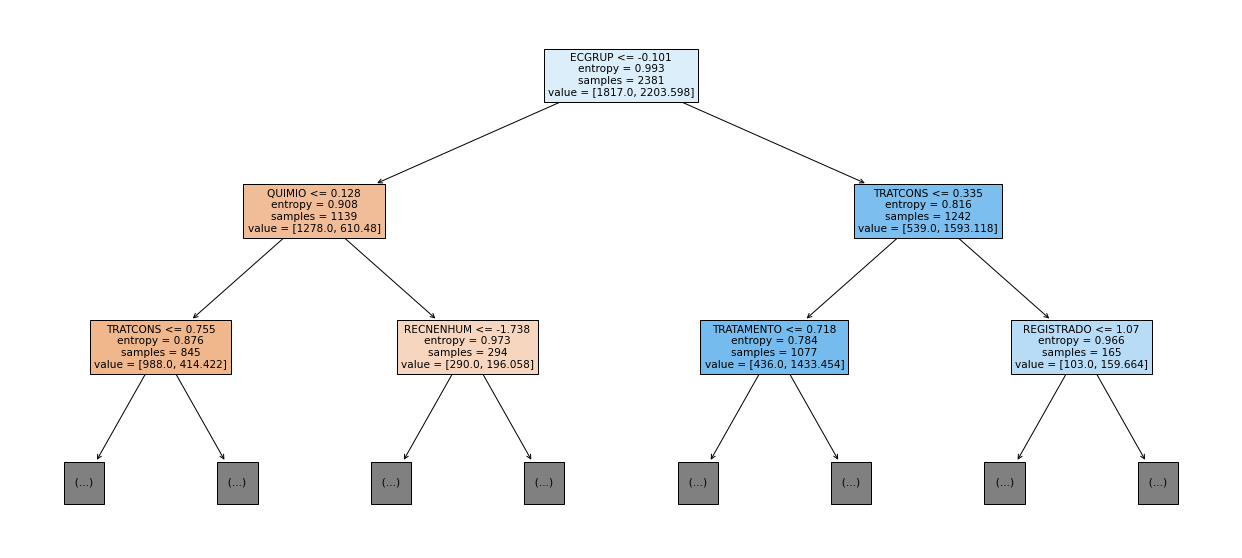

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

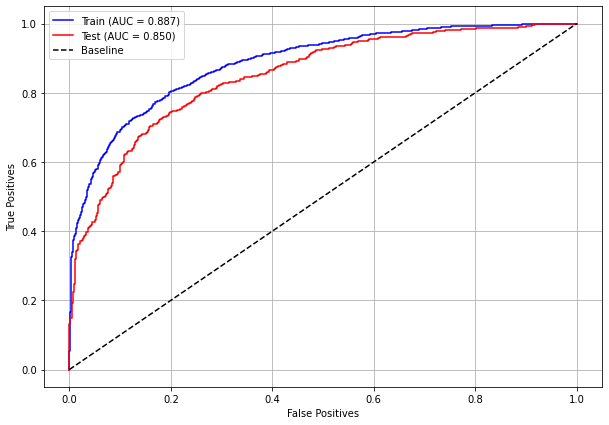

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

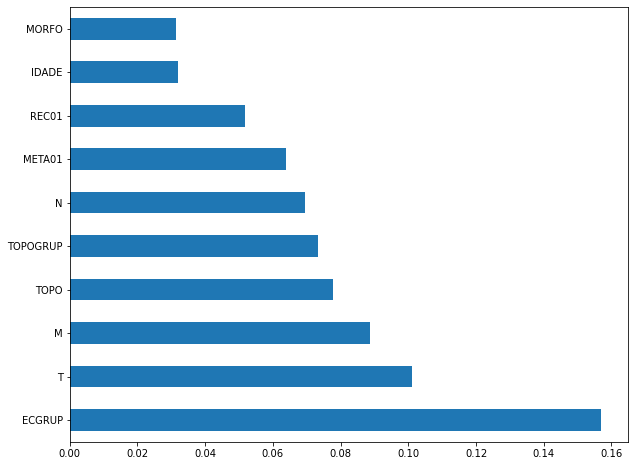

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `T`, `M` and `TOPO`.

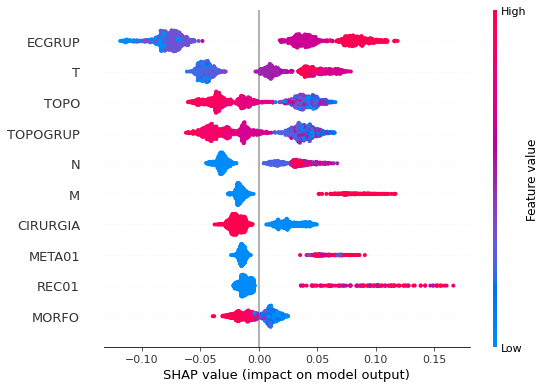

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed,
                                       class_weight={0:1, 1:1.3},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.3}, criterion='entropy',
                       max_depth=6, random_state=10)

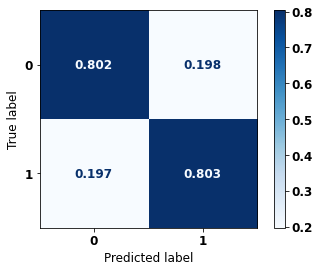


              precision    recall  f1-score   support

           0      0.831     0.802     0.816       827
           1      0.771     0.803     0.787       686

    accuracy                          0.802      1513
   macro avg      0.801     0.802     0.801      1513
weighted avg      0.804     0.802     0.803      1513



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 80% of accuracy.


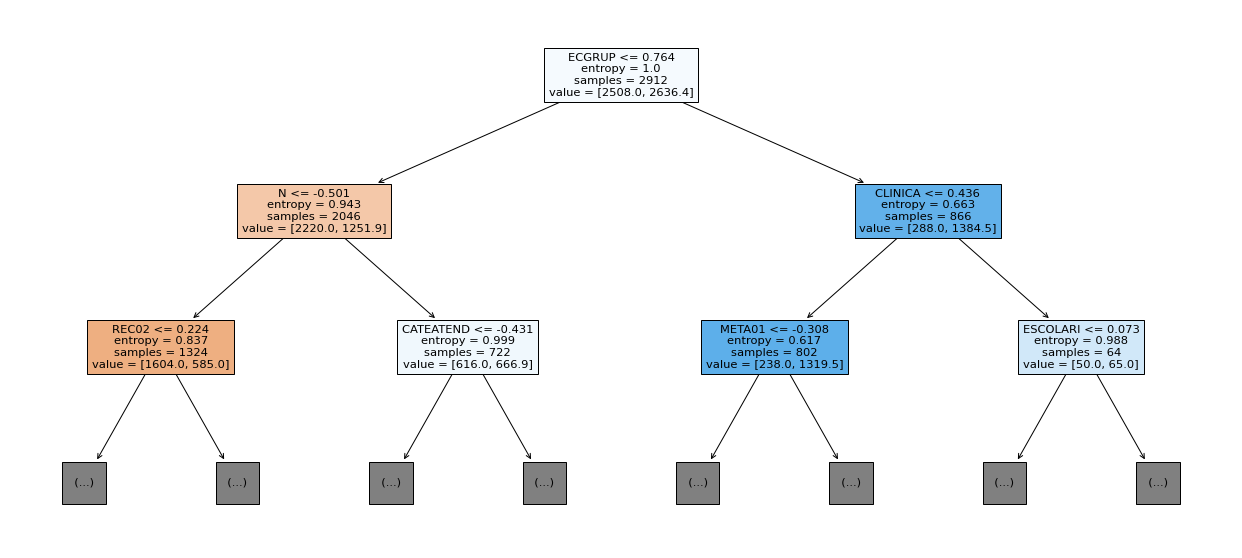

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

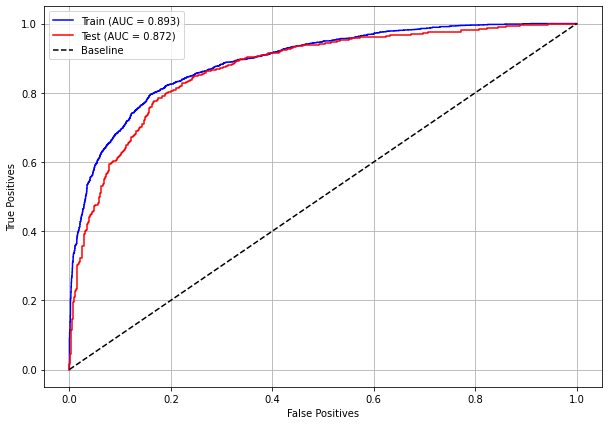

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

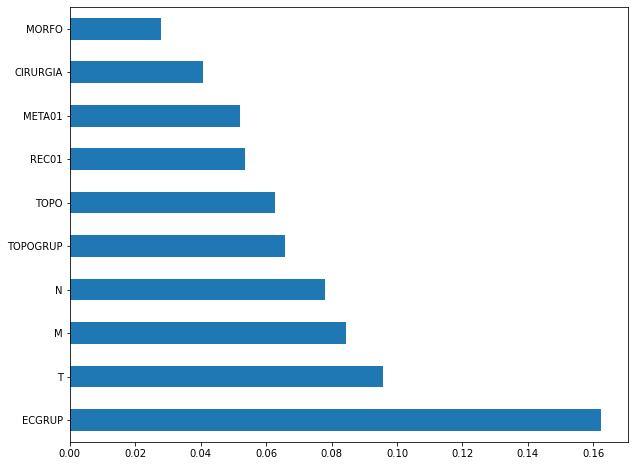

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `T`, `M` and `N`.

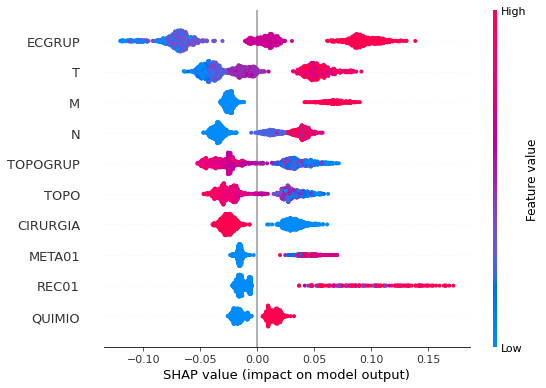

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.35},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.35}, criterion='entropy',
                       max_depth=6, random_state=10)

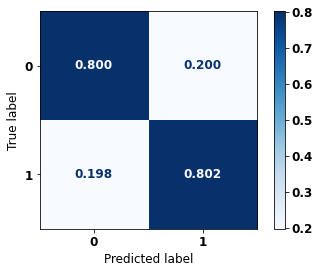


              precision    recall  f1-score   support

           0      0.885     0.800     0.841      1327
           1      0.678     0.802     0.735       697

    accuracy                          0.801      2024
   macro avg      0.782     0.801     0.788      2024
weighted avg      0.814     0.801     0.804      2024



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 80% of accuracy.


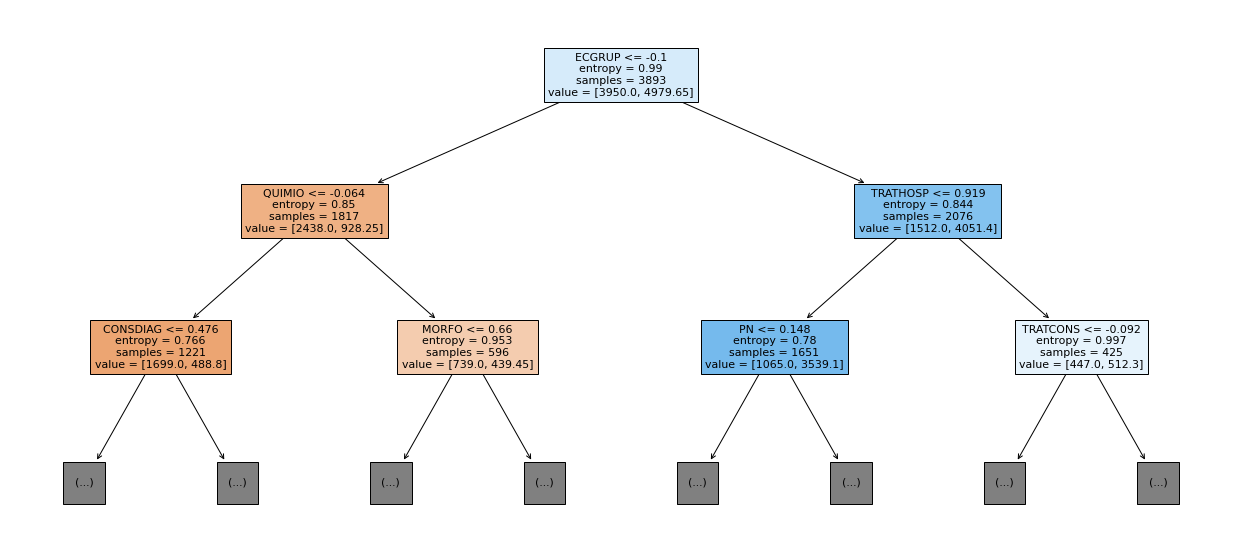

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

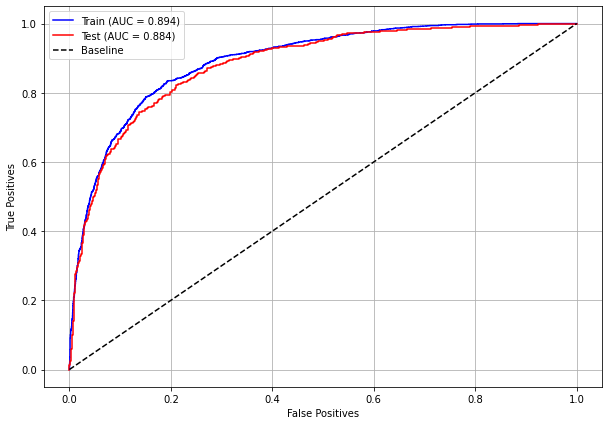

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

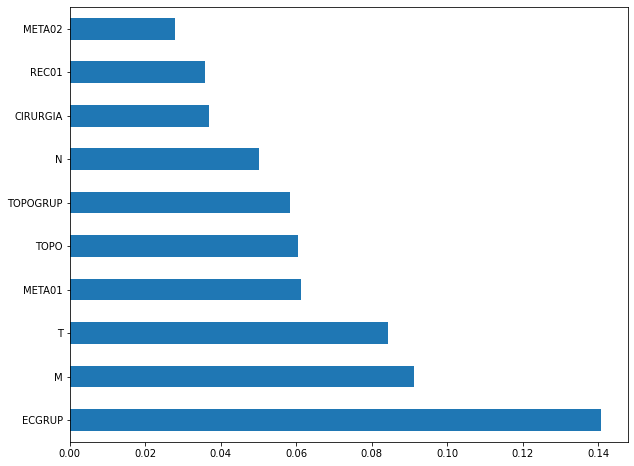

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `META01`.

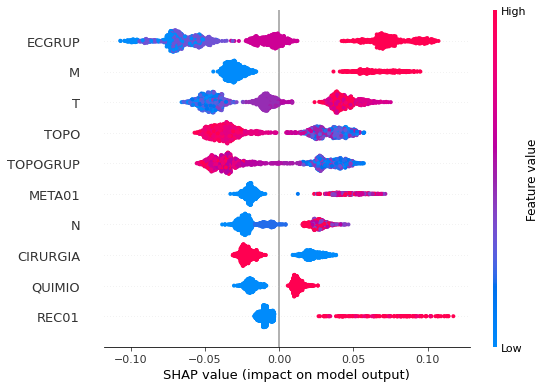

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:3.05},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 3.05}, criterion='entropy',
                       max_depth=8, random_state=10)

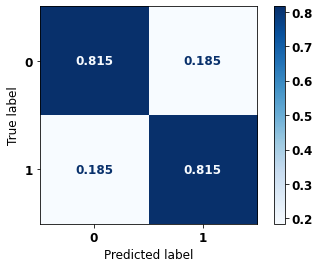


              precision    recall  f1-score   support

           0      0.922     0.815     0.865      1501
           1      0.623     0.815     0.706       561

    accuracy                          0.815      2062
   macro avg      0.772     0.815     0.786      2062
weighted avg      0.840     0.815     0.822      2062



In [ ]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 81% of accuracy.


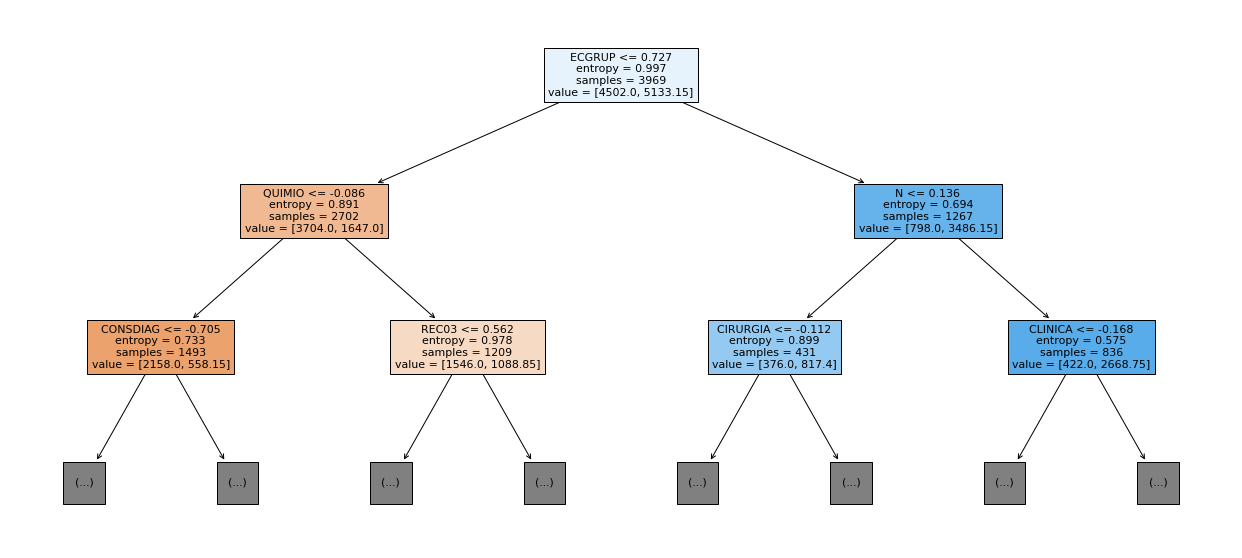

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 2)

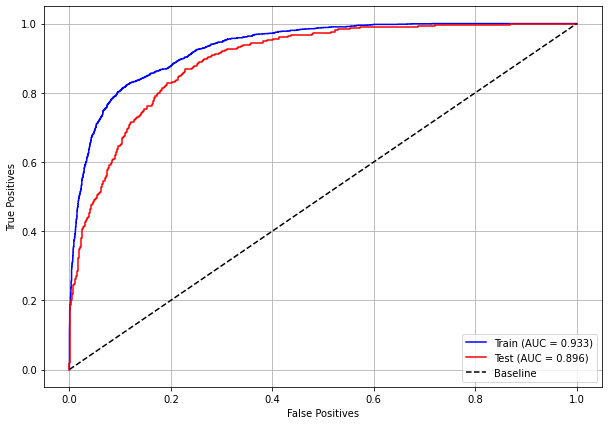

In [ ]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

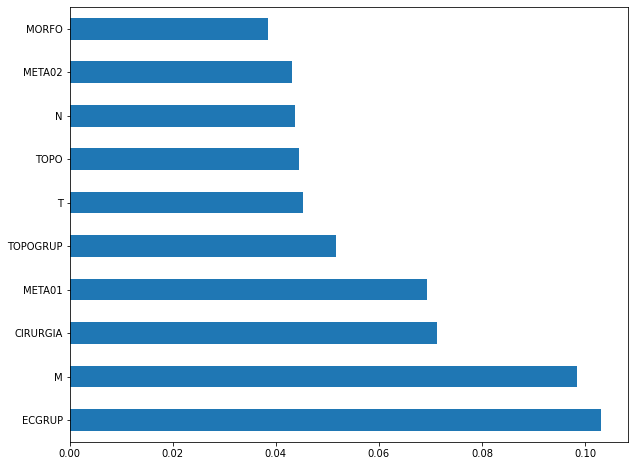

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ECGRUP`, `M`, `CIRURGIA` and `META01`.

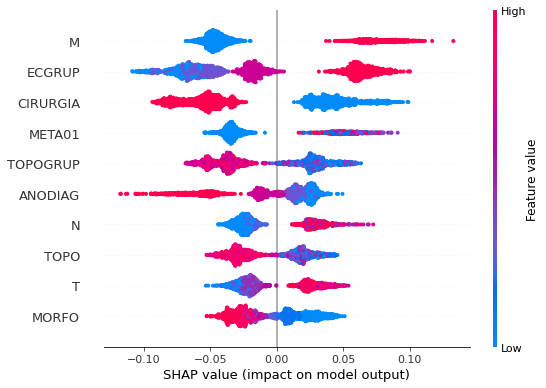

In [ ]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `M` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0.

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.44)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.44)

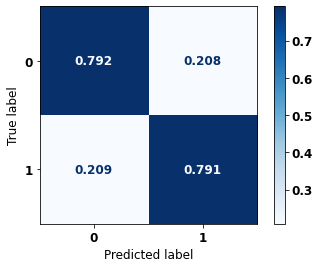


              precision    recall  f1-score   support

           0      0.632     0.792     0.703      4788
           1      0.894     0.791     0.839     10579

    accuracy                          0.791     15367
   macro avg      0.763     0.792     0.771     15367
weighted avg      0.812     0.791     0.797     15367



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with the SP data from 2000 to 2003, shows a good performance of the model, here with 79% of accuracy.

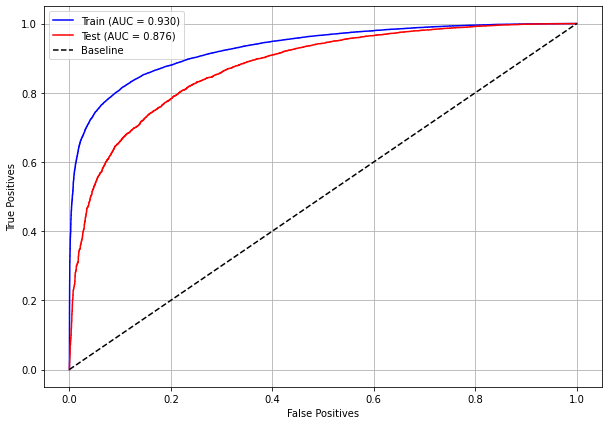

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

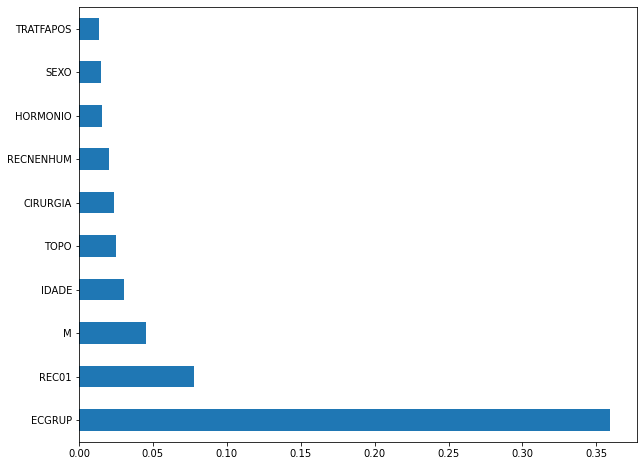

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `REC01`, `M` and `IDADE`.

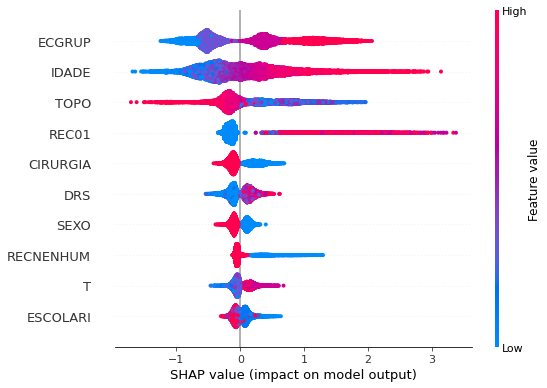

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.71)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.71)

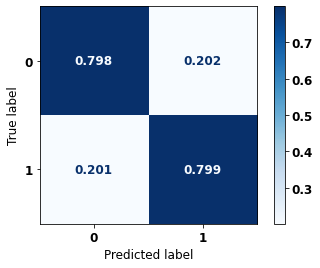


              precision    recall  f1-score   support

           0      0.718     0.798     0.756      7582
           1      0.860     0.799     0.829     11808

    accuracy                          0.799     19390
   macro avg      0.789     0.798     0.792     19390
weighted avg      0.805     0.799     0.800     19390



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with the SP data from 2004 to 2007, shows a good performance of the model, with 80% of accuracy.


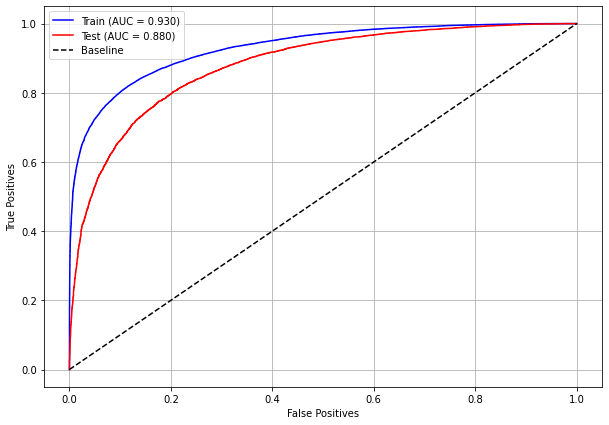

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

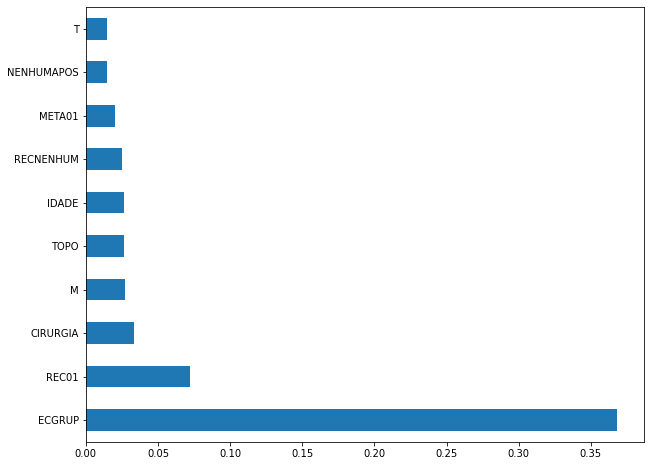

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `CIRURGIA` and `M`. 

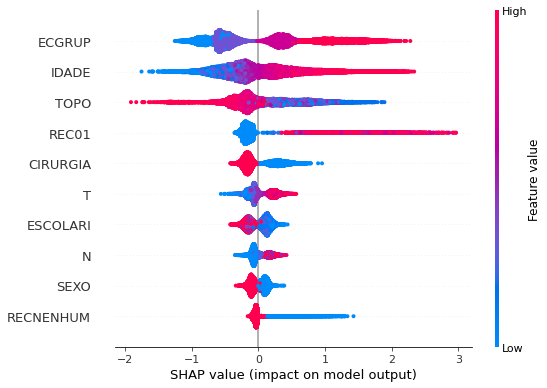

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = XGBClassifier(max_depth=8, 
                             scale_pos_weight=1.02,
                             random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.02)

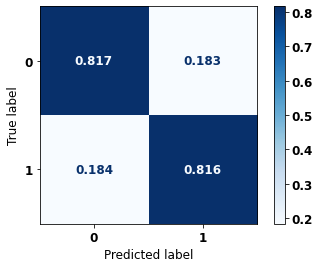


              precision    recall  f1-score   support

           0      0.795     0.817     0.806     12014
           1      0.836     0.816     0.826     13790

    accuracy                          0.817     25804
   macro avg      0.816     0.817     0.816     25804
weighted avg      0.817     0.817     0.817     25804



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 82% of accuracy.

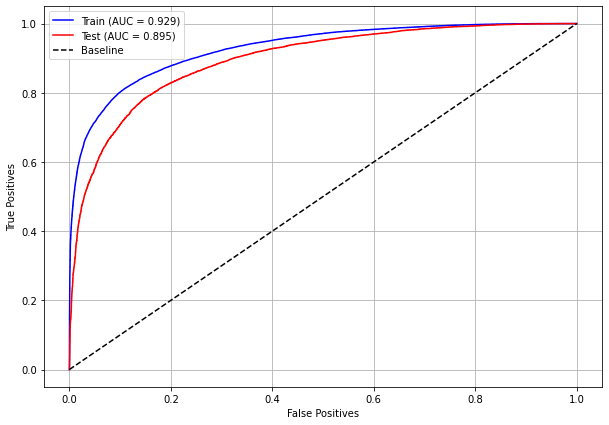

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

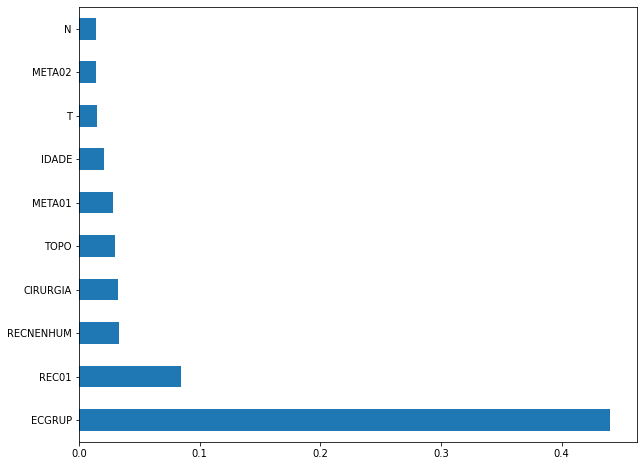

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `RECNENHUM` and `CIRURGIA`. 

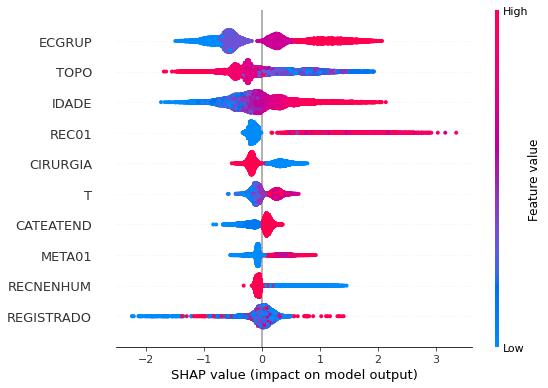

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = XGBClassifier(max_depth=8, 
                             random_state=seed,
                             scale_pos_weight=1.6)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.6)

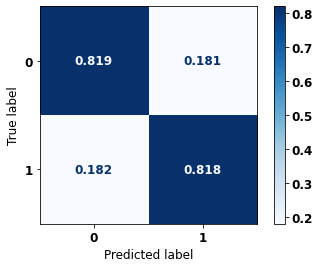


              precision    recall  f1-score   support

           0      0.867     0.819     0.842     18944
           1      0.758     0.818     0.787     13098

    accuracy                          0.819     32042
   macro avg      0.812     0.819     0.815     32042
weighted avg      0.822     0.819     0.820     32042



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

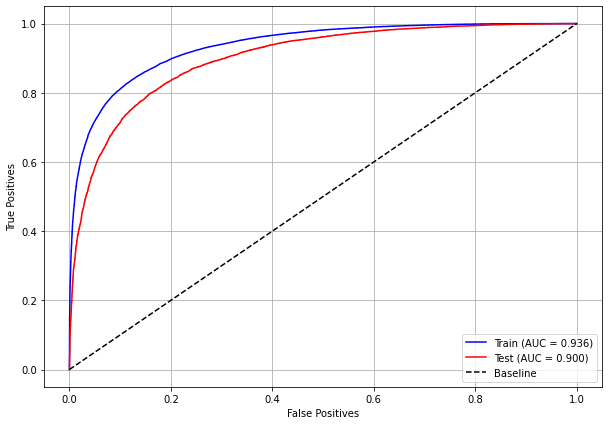

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

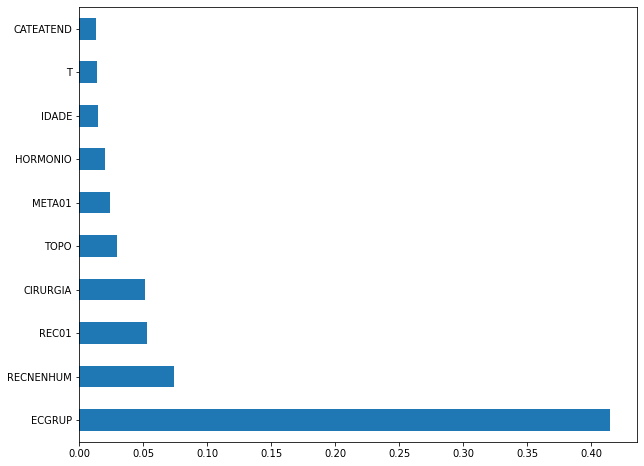

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with some advantage. Following we have `RECNENHUM`, `REC01` and `CIRURGIA`. 

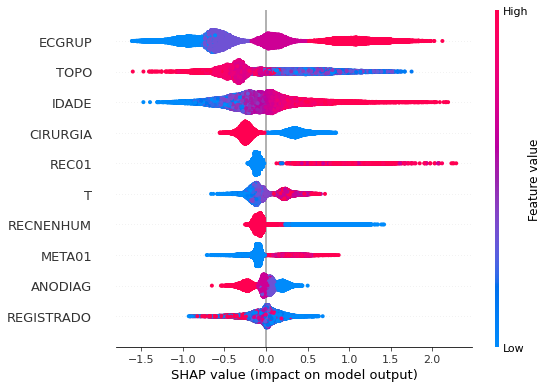

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=2.7)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=2.7)

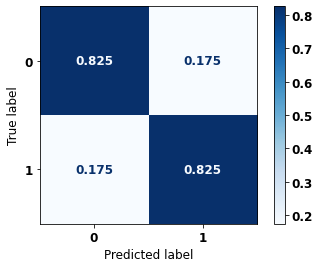


              precision    recall  f1-score   support

           0      0.921     0.825     0.871     17508
           1      0.656     0.825     0.731      7053

    accuracy                          0.825     24561
   macro avg      0.788     0.825     0.801     24561
weighted avg      0.845     0.825     0.831     24561



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, for SP data from 2016 to 2021, shows a good performance of the model, with 82% of accuracy.


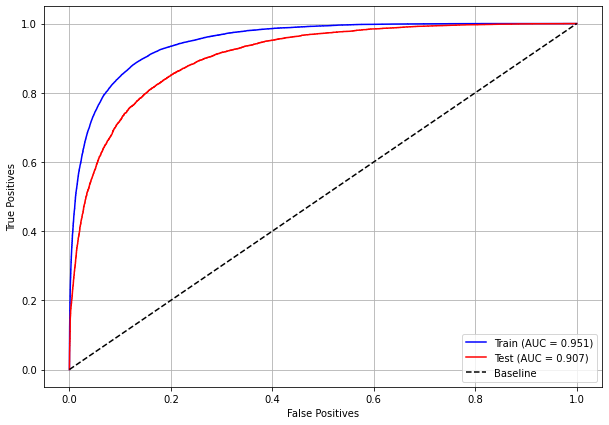

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

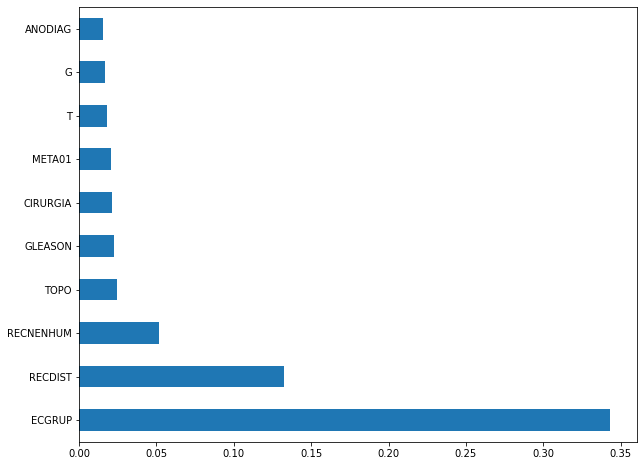

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `RECDIST`, `RECNENHUM` and `TOPO`.



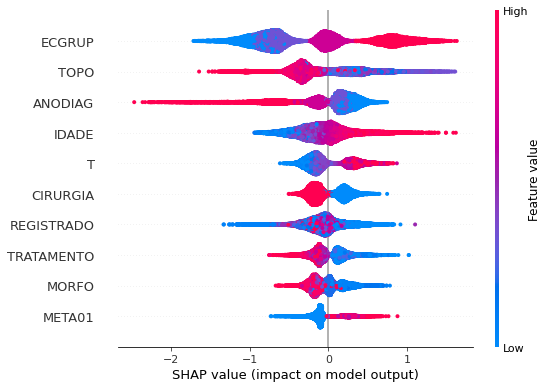

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.647,
                               random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.647)

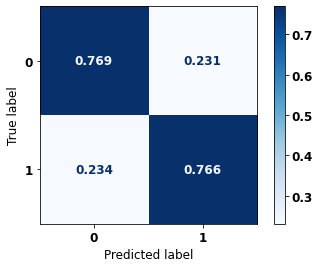


              precision    recall  f1-score   support

           0      0.675     0.769     0.719       334
           1      0.841     0.766     0.802       531

    accuracy                          0.768       865
   macro avg      0.758     0.768     0.760       865
weighted avg      0.777     0.768     0.770       865



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 77% of accuracy.

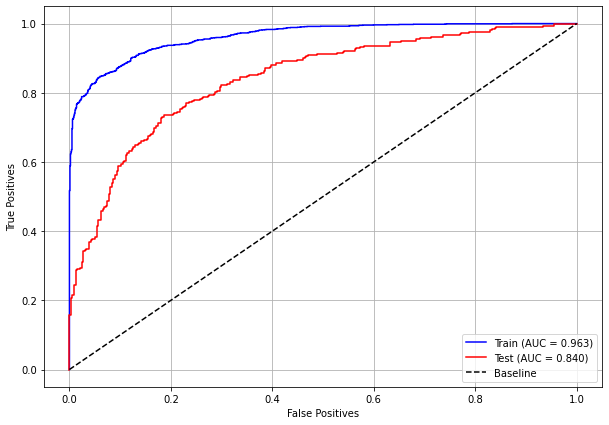

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

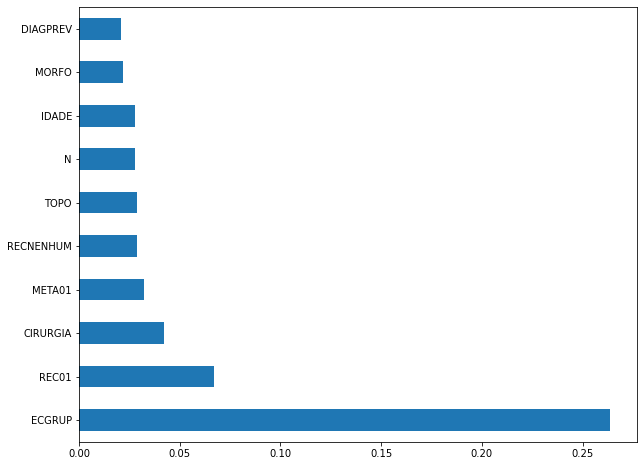

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `CIRURGIA` and `META01`.

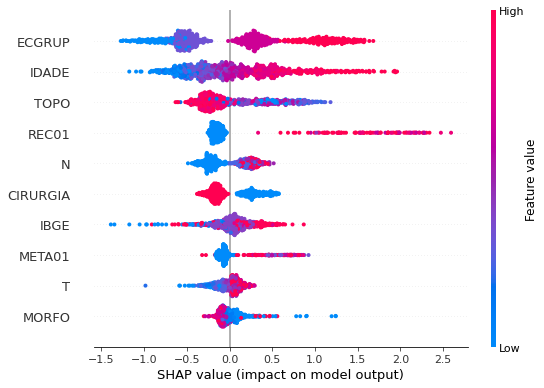

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=1.032,
                               random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.032)

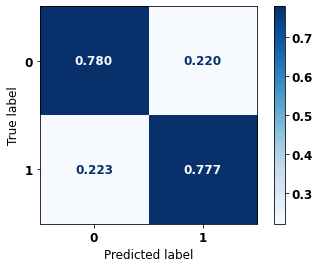


              precision    recall  f1-score   support

           0      0.768     0.780     0.774       600
           1      0.788     0.777     0.782       632

    accuracy                          0.778      1232
   macro avg      0.778     0.778     0.778      1232
weighted avg      0.779     0.778     0.778      1232



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 78% of accuracy.

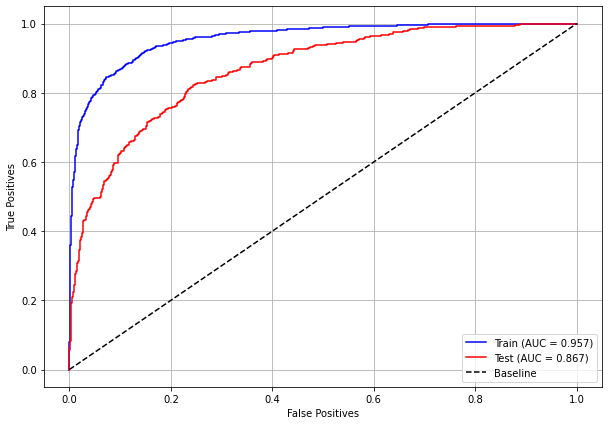

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

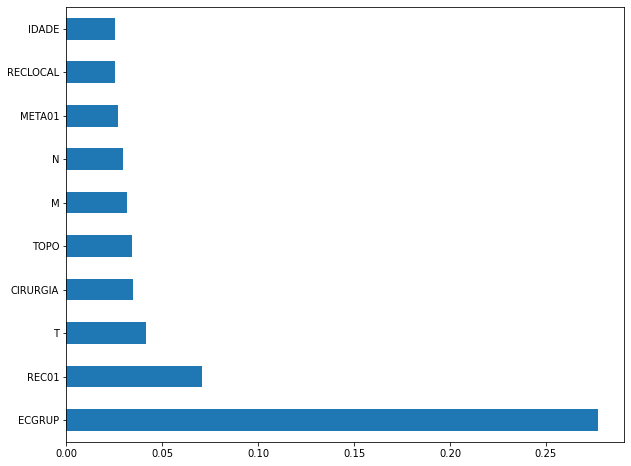

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `T` and `CIRURGIA`.

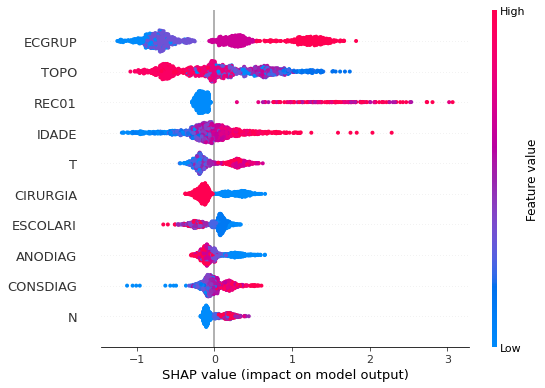

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = XGBClassifier(max_depth=6, 
                               scale_pos_weight=1.28,
                               random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.28)

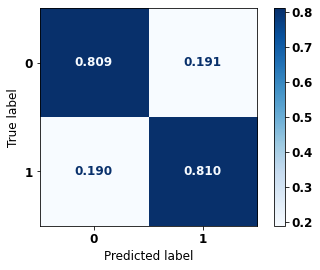


              precision    recall  f1-score   support

           0      0.837     0.809     0.823       827
           1      0.779     0.810     0.794       686

    accuracy                          0.810      1513
   macro avg      0.808     0.810     0.809      1513
weighted avg      0.811     0.810     0.810      1513



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 81% of accuracy.

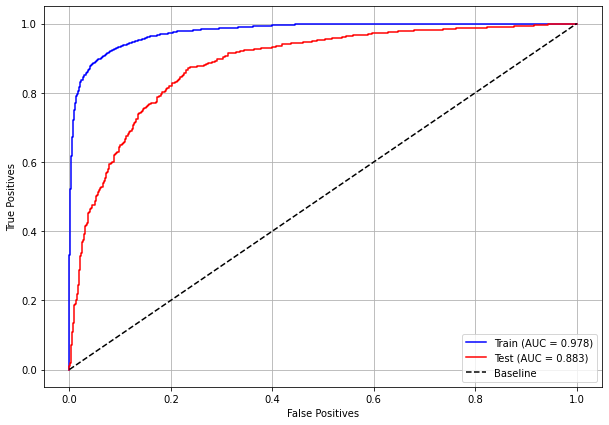

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

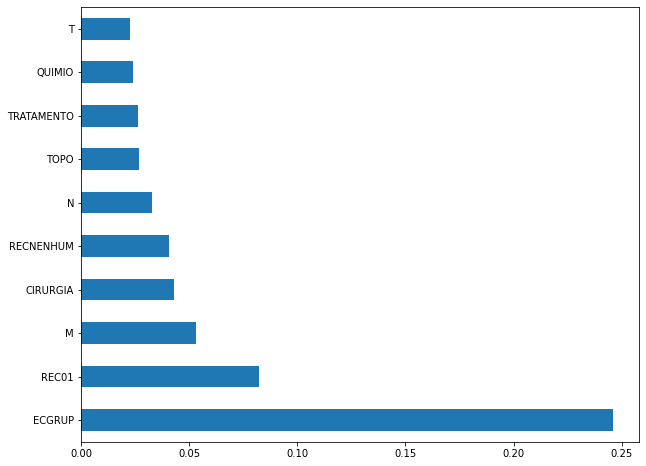

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `REC01`, `M` and `CIRURGIA`.

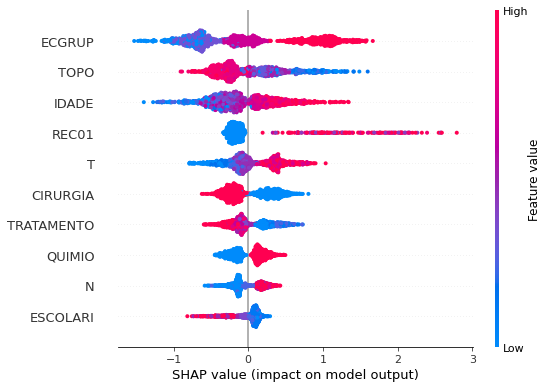

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = XGBClassifier(max_depth=6, 
                               scale_pos_weight=2.65,
                               random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=2.65)

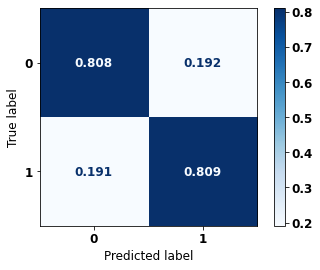


              precision    recall  f1-score   support

           0      0.890     0.808     0.847      1327
           1      0.689     0.809     0.744       697

    accuracy                          0.808      2024
   macro avg      0.789     0.809     0.795      2024
weighted avg      0.820     0.808     0.811      2024



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 81% of accuracy.

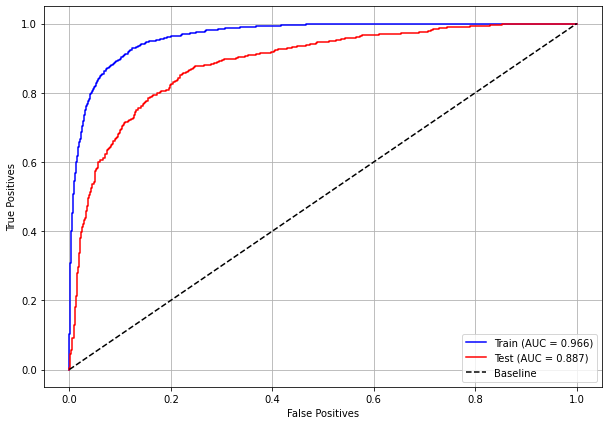

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

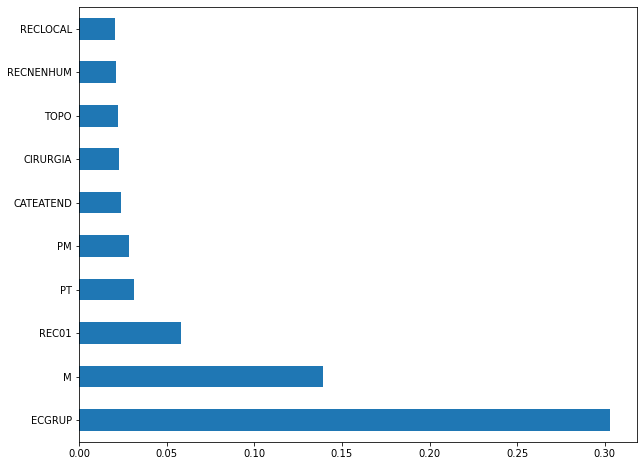

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `M`, `REC01` and `PT`.

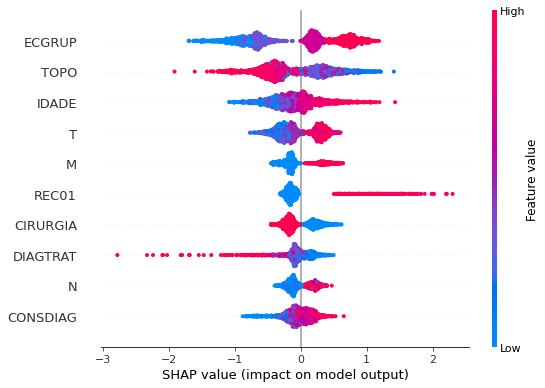

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=3,
                               random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=3)

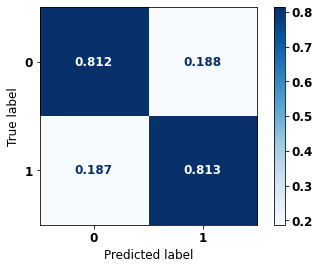


              precision    recall  f1-score   support

           0      0.921     0.812     0.863      1501
           1      0.618     0.813     0.702       561

    accuracy                          0.812      2062
   macro avg      0.769     0.812     0.783      2062
weighted avg      0.838     0.812     0.819      2062



In [ ]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states data from 2016 to 2020, shows the best performance comparing with the other models, with 81% of accuracy.

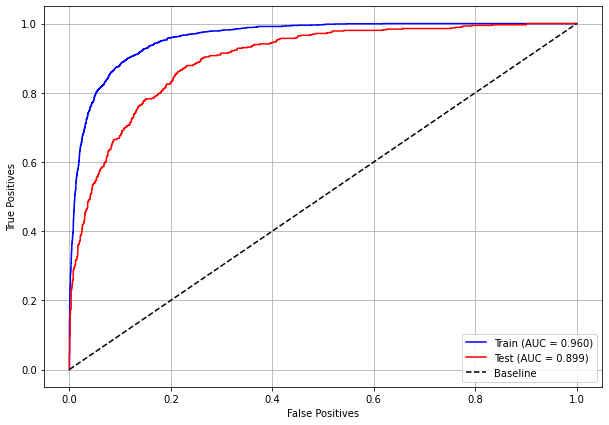

In [ ]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

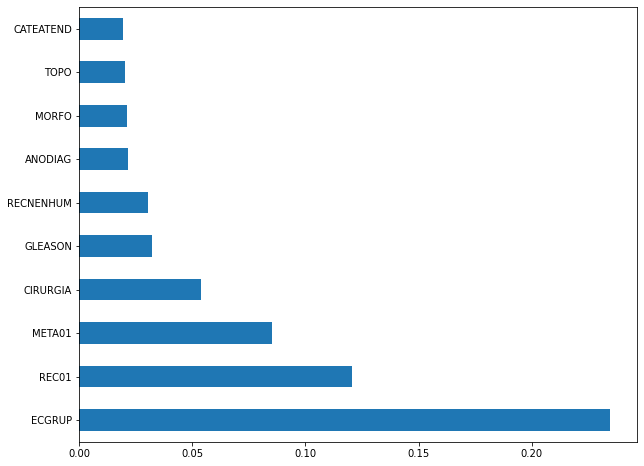

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `ECGRUP`, `REC01`, `META01` and `CIRURGIA`.

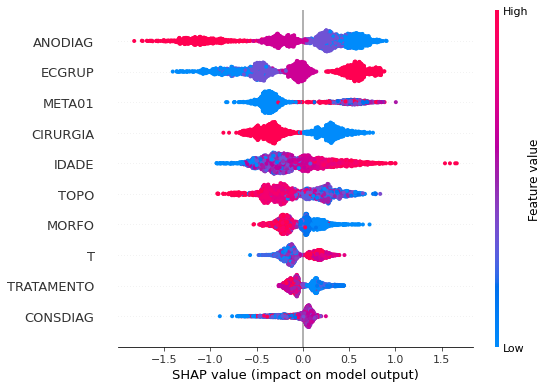

In [ ]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1.

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

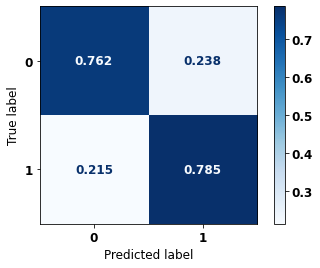


              precision    recall  f1-score   support

           0      0.695     0.762     0.727      7582
           1      0.837     0.785     0.810     11808

    accuracy                          0.776     19390
   macro avg      0.766     0.774     0.769     19390
weighted avg      0.781     0.776     0.778     19390



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

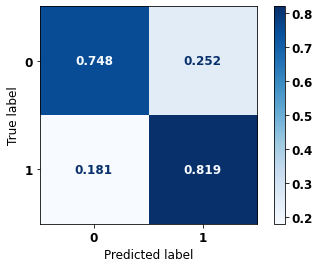


              precision    recall  f1-score   support

           0      0.782     0.748     0.765     12014
           1      0.788     0.819     0.803     13790

    accuracy                          0.786     25804
   macro avg      0.785     0.783     0.784     25804
weighted avg      0.785     0.786     0.785     25804



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

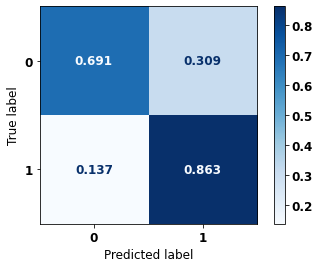


              precision    recall  f1-score   support

           0      0.879     0.691     0.774     18944
           1      0.659     0.863     0.747     13098

    accuracy                          0.761     32042
   macro avg      0.769     0.777     0.761     32042
weighted avg      0.789     0.761     0.763     32042



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

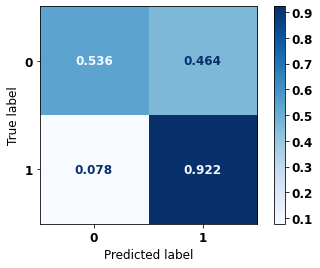


              precision    recall  f1-score   support

           0      0.944     0.536     0.684     17508
           1      0.445     0.922     0.600      7053

    accuracy                          0.647     24561
   macro avg      0.695     0.729     0.642     24561
weighted avg      0.801     0.647     0.660     24561



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

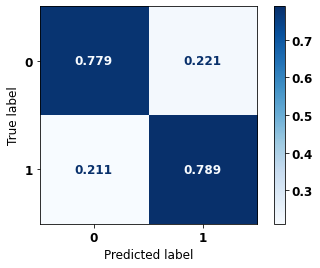


              precision    recall  f1-score   support

           0      0.703     0.779     0.739      7582
           1      0.848     0.789     0.817     11808

    accuracy                          0.785     19390
   macro avg      0.776     0.784     0.778     19390
weighted avg      0.791     0.785     0.787     19390



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

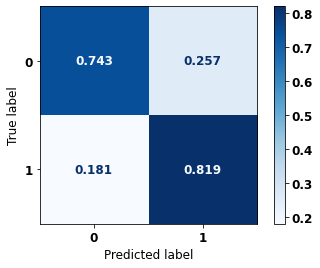


              precision    recall  f1-score   support

           0      0.781     0.743     0.762     12014
           1      0.785     0.819     0.802     13790

    accuracy                          0.784     25804
   macro avg      0.783     0.781     0.782     25804
weighted avg      0.783     0.784     0.783     25804



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

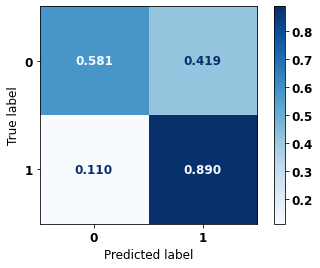


              precision    recall  f1-score   support

           0      0.884     0.581     0.702     18944
           1      0.595     0.890     0.713     13098

    accuracy                          0.708     32042
   macro avg      0.740     0.736     0.707     32042
weighted avg      0.766     0.708     0.706     32042



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

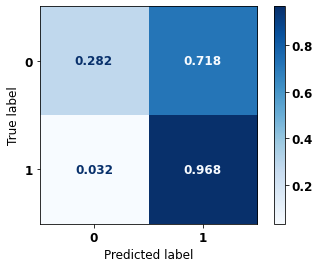


              precision    recall  f1-score   support

           0      0.956     0.282     0.435     17508
           1      0.352     0.968     0.516      7053

    accuracy                          0.479     24561
   macro avg      0.654     0.625     0.476     24561
weighted avg      0.783     0.479     0.458     24561



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

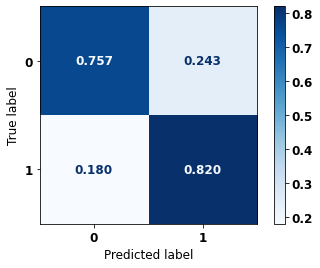


              precision    recall  f1-score   support

           0      0.785     0.757     0.771     12014
           1      0.795     0.820     0.807     13790

    accuracy                          0.791     25804
   macro avg      0.790     0.789     0.789     25804
weighted avg      0.791     0.791     0.790     25804



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

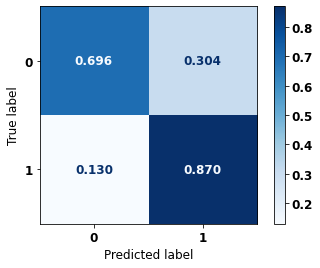


              precision    recall  f1-score   support

           0      0.886     0.696     0.780     18944
           1      0.664     0.870     0.753     13098

    accuracy                          0.767     32042
   macro avg      0.775     0.783     0.766     32042
weighted avg      0.795     0.767     0.769     32042



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

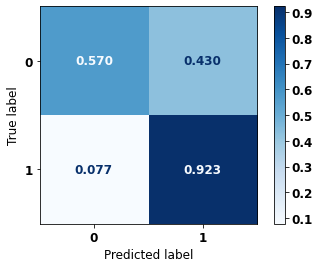


              precision    recall  f1-score   support

           0      0.948     0.570     0.712     17508
           1      0.464     0.923     0.617      7053

    accuracy                          0.671     24561
   macro avg      0.706     0.746     0.665     24561
weighted avg      0.809     0.671     0.685     24561



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

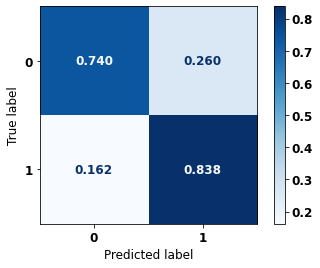


              precision    recall  f1-score   support

           0      0.799     0.740     0.769     12014
           1      0.787     0.838     0.812     13790

    accuracy                          0.793     25804
   macro avg      0.793     0.789     0.790     25804
weighted avg      0.793     0.793     0.792     25804



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

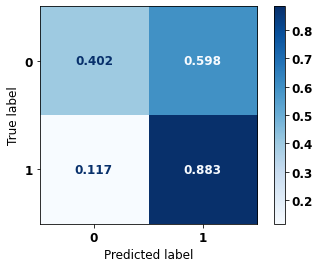


              precision    recall  f1-score   support

           0      0.833     0.402     0.542     18944
           1      0.505     0.883     0.643     13098

    accuracy                          0.598     32042
   macro avg      0.669     0.642     0.592     32042
weighted avg      0.699     0.598     0.583     32042



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

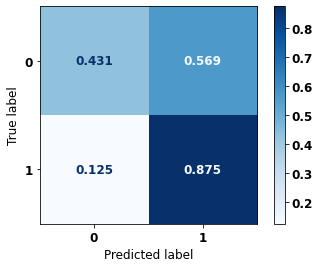


              precision    recall  f1-score   support

           0      0.896     0.431     0.582     17508
           1      0.383     0.875     0.533      7053

    accuracy                          0.559     24561
   macro avg      0.639     0.653     0.557     24561
weighted avg      0.748     0.559     0.568     24561



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

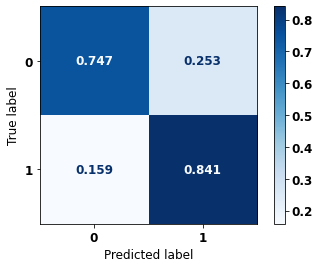


              precision    recall  f1-score   support

           0      0.872     0.747     0.805     18944
           1      0.697     0.841     0.762     13098

    accuracy                          0.786     32042
   macro avg      0.785     0.794     0.784     32042
weighted avg      0.801     0.786     0.788     32042



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

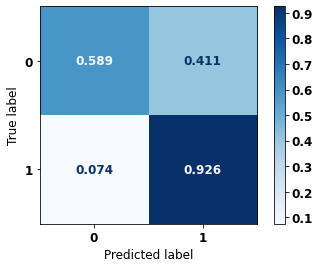


              precision    recall  f1-score   support

           0      0.952     0.589     0.728     17508
           1      0.476     0.926     0.629      7053

    accuracy                          0.686     24561
   macro avg      0.714     0.757     0.678     24561
weighted avg      0.815     0.686     0.699     24561



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

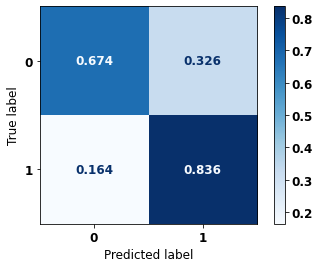


              precision    recall  f1-score   support

           0      0.856     0.674     0.754     18944
           1      0.639     0.836     0.725     13098

    accuracy                          0.740     32042
   macro avg      0.748     0.755     0.739     32042
weighted avg      0.767     0.740     0.742     32042



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

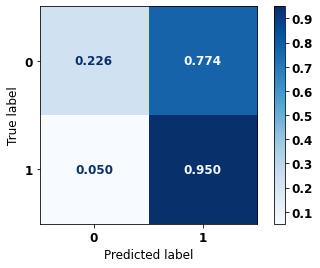


              precision    recall  f1-score   support

           0      0.918     0.226     0.363     17508
           1      0.331     0.950     0.491      7053

    accuracy                          0.434     24561
   macro avg      0.624     0.588     0.427     24561
weighted avg      0.749     0.434     0.400     24561



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

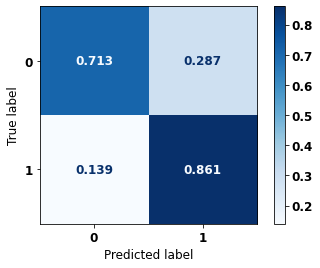


              precision    recall  f1-score   support

           0      0.927     0.713     0.806     17508
           1      0.547     0.861     0.669      7053

    accuracy                          0.755     24561
   macro avg      0.737     0.787     0.737     24561
weighted avg      0.818     0.755     0.767     24561



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

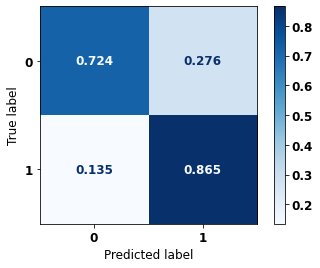


              precision    recall  f1-score   support

           0      0.930     0.724     0.815     17508
           1      0.559     0.865     0.679      7053

    accuracy                          0.765     24561
   macro avg      0.744     0.795     0.747     24561
weighted avg      0.824     0.765     0.776     24561



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

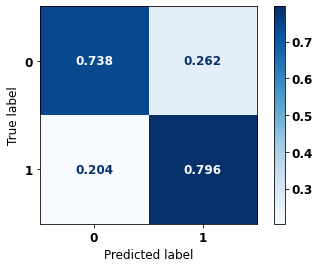


              precision    recall  f1-score   support

           0      0.774     0.738     0.756       600
           1      0.762     0.796     0.779       632

    accuracy                          0.768      1232
   macro avg      0.768     0.767     0.767      1232
weighted avg      0.768     0.768     0.768      1232



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

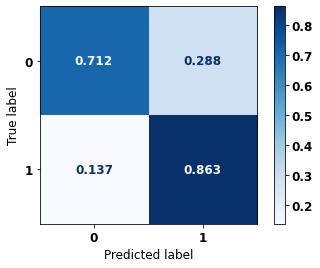


              precision    recall  f1-score   support

           0      0.862     0.712     0.780       827
           1      0.713     0.863     0.781       686

    accuracy                          0.781      1513
   macro avg      0.788     0.788     0.781      1513
weighted avg      0.795     0.781     0.781      1513



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

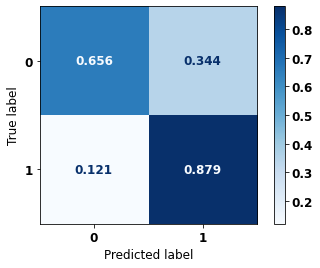


              precision    recall  f1-score   support

           0      0.912     0.656     0.763      1327
           1      0.573     0.879     0.694       697

    accuracy                          0.733      2024
   macro avg      0.743     0.768     0.729      2024
weighted avg      0.795     0.733     0.740      2024



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

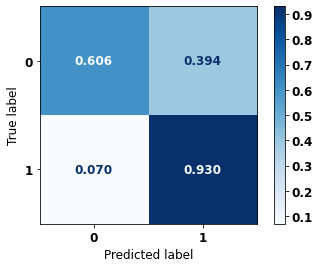


              precision    recall  f1-score   support

           0      0.959     0.606     0.742      1501
           1      0.469     0.930     0.623       561

    accuracy                          0.694      2062
   macro avg      0.714     0.768     0.683      2062
weighted avg      0.825     0.694     0.710      2062



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

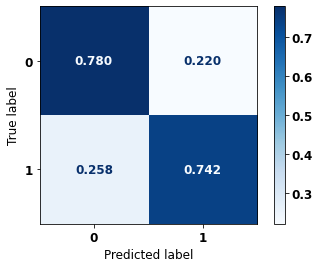


              precision    recall  f1-score   support

           0      0.742     0.780     0.760       600
           1      0.780     0.742     0.761       632

    accuracy                          0.761      1232
   macro avg      0.761     0.761     0.761      1232
weighted avg      0.762     0.761     0.761      1232



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

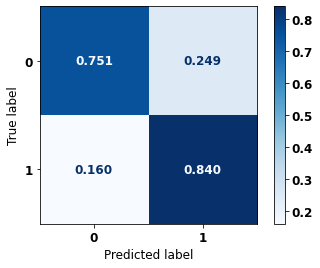


              precision    recall  f1-score   support

           0      0.850     0.751     0.797       827
           1      0.737     0.840     0.785       686

    accuracy                          0.791      1513
   macro avg      0.793     0.795     0.791      1513
weighted avg      0.798     0.791     0.792      1513



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

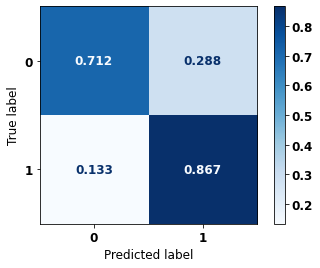


              precision    recall  f1-score   support

           0      0.910     0.712     0.799      1327
           1      0.613     0.867     0.718       697

    accuracy                          0.765      2024
   macro avg      0.761     0.789     0.758      2024
weighted avg      0.808     0.765     0.771      2024



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

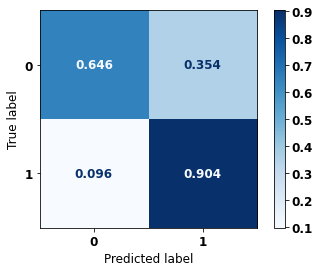


              precision    recall  f1-score   support

           0      0.947     0.646     0.768      1501
           1      0.488     0.904     0.634       561

    accuracy                          0.716      2062
   macro avg      0.718     0.775     0.701      2062
weighted avg      0.822     0.716     0.732      2062



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

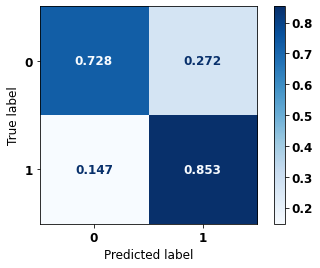


              precision    recall  f1-score   support

           0      0.856     0.728     0.787       827
           1      0.722     0.853     0.782       686

    accuracy                          0.785      1513
   macro avg      0.789     0.790     0.785      1513
weighted avg      0.796     0.785     0.785      1513



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

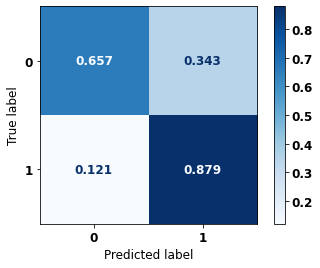


              precision    recall  f1-score   support

           0      0.912     0.657     0.764      1327
           1      0.574     0.879     0.695       697

    accuracy                          0.734      2024
   macro avg      0.743     0.768     0.729      2024
weighted avg      0.796     0.734     0.740      2024



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

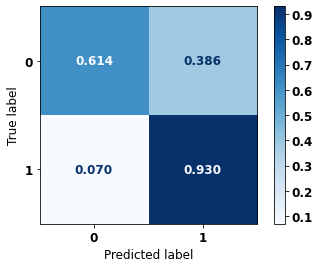


              precision    recall  f1-score   support

           0      0.959     0.614     0.748      1501
           1      0.474     0.930     0.628       561

    accuracy                          0.700      2062
   macro avg      0.717     0.772     0.688      2062
weighted avg      0.827     0.700     0.716      2062



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

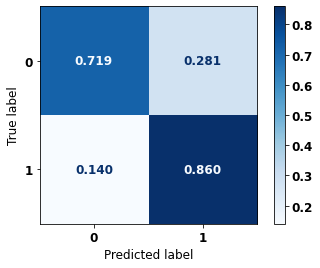


              precision    recall  f1-score   support

           0      0.861     0.719     0.784       827
           1      0.718     0.860     0.782       686

    accuracy                          0.783      1513
   macro avg      0.789     0.790     0.783      1513
weighted avg      0.796     0.783     0.783      1513



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

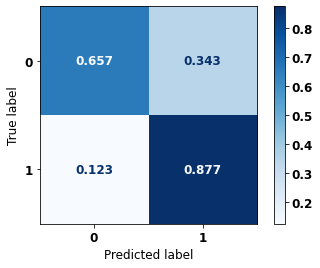


              precision    recall  f1-score   support

           0      0.910     0.657     0.763      1327
           1      0.573     0.877     0.693       697

    accuracy                          0.733      2024
   macro avg      0.742     0.767     0.728      2024
weighted avg      0.794     0.733     0.739      2024



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

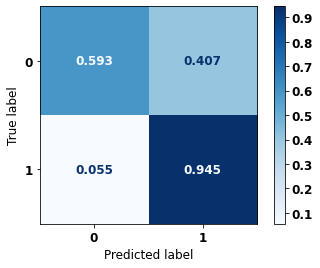


              precision    recall  f1-score   support

           0      0.966     0.593     0.735      1501
           1      0.465     0.945     0.623       561

    accuracy                          0.689      2062
   macro avg      0.715     0.769     0.679      2062
weighted avg      0.830     0.689     0.704      2062



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

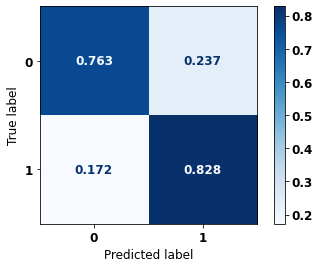


              precision    recall  f1-score   support

           0      0.894     0.763     0.824      1327
           1      0.648     0.828     0.727       697

    accuracy                          0.786      2024
   macro avg      0.771     0.796     0.775      2024
weighted avg      0.809     0.786     0.790      2024



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

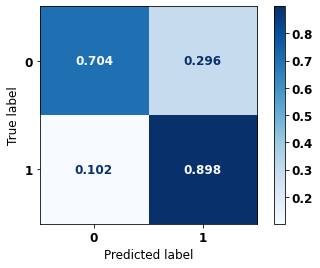


              precision    recall  f1-score   support

           0      0.949     0.704     0.808      1501
           1      0.531     0.898     0.668       561

    accuracy                          0.757      2062
   macro avg      0.740     0.801     0.738      2062
weighted avg      0.835     0.757     0.770      2062



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

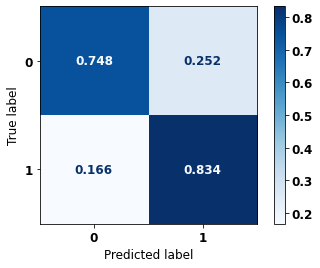


              precision    recall  f1-score   support

           0      0.895     0.748     0.815      1327
           1      0.635     0.834     0.721       697

    accuracy                          0.778      2024
   macro avg      0.765     0.791     0.768      2024
weighted avg      0.806     0.778     0.783      2024



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

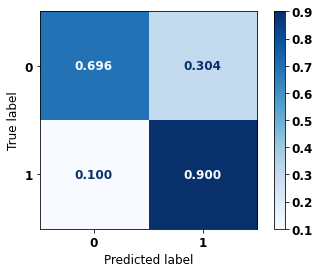


              precision    recall  f1-score   support

           0      0.949     0.696     0.803      1501
           1      0.525     0.900     0.663       561

    accuracy                          0.751      2062
   macro avg      0.737     0.798     0.733      2062
weighted avg      0.834     0.751     0.765      2062



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

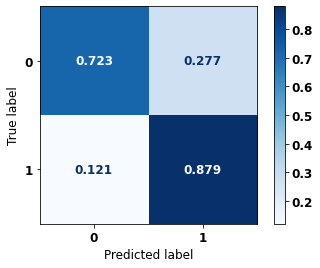


              precision    recall  f1-score   support

           0      0.941     0.723     0.818      1501
           1      0.542     0.879     0.671       561

    accuracy                          0.765      2062
   macro avg      0.742     0.801     0.744      2062
weighted avg      0.833     0.765     0.778      2062



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

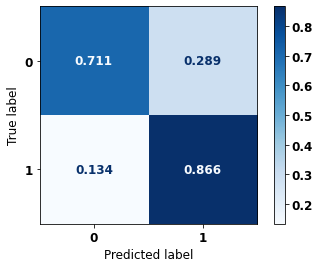


              precision    recall  f1-score   support

           0      0.934     0.711     0.807      1501
           1      0.528     0.866     0.656       561

    accuracy                          0.753      2062
   macro avg      0.731     0.789     0.732      2062
weighted avg      0.824     0.753     0.766      2062



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)